# 「ヒューマノイドロボット」の本に記載されているプログラムをPythonで動かす！

「<a href="https://www.amazon.co.jp/%E3%83%92%E3%83%A5%E3%83%BC%E3%83%9E%E3%83%8E%E3%82%A4%E3%83%89%E3%83%AD%E3%83%9C%E3%83%83%E3%83%88-%E6%94%B9%E8%A8%822%E7%89%88-%E6%A2%B6%E7%94%B0-%E7%A7%80%E5%8F%B8/dp/4274226026/ref=sr_1_2?crid=2DGXE43QVGNMF&keywords=%E3%83%92%E3%83%A5%E3%83%BC%E3%83%9E%E3%83%8E%E3%82%A4%E3%83%89&qid=1645525881&sprefix=%E3%83%92%E3%83%A5%E3%83%BC%E3%83%9E%E3%83%8E%E3%82%A4%E3%83%89%2Caps%2C173&sr=8-2">ヒューマノイドロボット</a>(著：梶田修司，オーム社)」の本に記載されているプログラムは<a href="https://github.com/s-kajita/IntroductionToHumanoidRobotics">Matlab形式</a>で，無料のOctaveでも実行が可能ですが，Pythonのプログラムでも確認できるようにできないかと考えてPythonの練習も兼ねて移植してみました．

一応，最後の2足歩行ロボットが崩れ落ちる動力学まで動くようになりました．Octaveで実行したよりPythonのほうが速く動いています．（2022年2月22日ノートパソコンMSI GS65-8RFで確認）

もっと速くするために，余裕があればC++に移植したい．（Choreonoid使えばいいだけですが．．．）

今後の予定<br>
・ <a href="http://royfeatherstone.org/spatial/">Feather Stone</a>先生のアルゴリズムを移植してみる？<br>
・ C++に変換してみる．<br>

## １．データ構造の定義
ヒューマノイドロボットの本と同じくpythonのclassでuLINKの構造を定義する．

下記のデータ構造の例は，「ヒューマノイドロボット」の第２章の例と同じく「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」を加えている．


In [ ]:
class uLINK:
  def __init__(self, name, sister, child, m, mother):
    self.name = name
    self.sister = sister
    self.child = child
    self.m = m
    self.mother = mother

上記のクラスを使ってリスト構造にデータを代入する．

初期化では，２分木の構造の兄弟（姉妹）と子供のリンク構造だけ与えておき，リンクの親についてはゼロを代入している．

親リンク(mother)については，後にあるFindmotherの関数で自動的に代入されるようになっている．

In [ ]:
arr=[0]*10 #10個のリストをゼロで初期化
arr[0]=uLINK("empty",0,0,0,0) #uLINKクラスの定義に沿ってデータを代入
arr[1]=uLINK("BODY",0,2,10,0)
arr[2]=uLINK("RARM",4,3,5,0)
arr[3]=uLINK("RHAND",0,0,1,0)
arr[4]=uLINK("LARM",6,5,5,0)
arr[5]=uLINK("LHAND",0,0,1,0)
arr[6]=uLINK("RLEG",8,7,6,0)
arr[7]=uLINK("RFOOT",0,0,2,0)
arr[8]=uLINK("LLEG",0,9,6,0)
arr[9]=uLINK("LFOOT",0,0,2,0)

### FindMther関数

兄弟と子供のリンク構造を定義しておけば，この関数を使うことで，リンクの親の情報を求めることができる．

In [ ]:
def FindMother(j):
    if j != 0:
        if j == 1:
            arr[j].mother = 0;
        if arr[j].child != 0:
            arr[arr[j].child].mother = j;
            FindMother(arr[j].child);
        if arr[j].sister != 0:
            arr[arr[j].sister].mother = arr[j].mother;
            FindMother(arr[j].sister);

下記は，FindMother関数の実行例

FindMother関数の引数に与えたリンク番号の下に位置している兄弟リンクと子供リンクのすべての親のIDをリンク構造の定義motherに代入してくれる．

In [ ]:
FindMother(1) #ID1以下のリンクの親のIDを登録
print("arr[8].mother: ", arr[8].mother) #リンク8の親のIDを表示

### TotalMass関数

引数に与えたリンク番号以下のリンク構造すべての質量の和を計算する．

In [ ]:
def TotalMass(x):
  if x == 0:
    m = 0
    return m
  else:
    m = arr[x].m + TotalMass(arr[x].sister) + TotalMass(arr[x].child)
    return m

In [ ]:
TotalMass(1) #リンク１以下のすべての質量の和．

### PrintLinkName関数

引数に与えたリンク番号以下のリンク番号と名前を表示する関数．再帰関数を使って自分のリンクの子供と兄弟のリンクの名前を呼び出すことで指定したリンク以下の名前が表示されるようになっている．ただし，最初のIDの付け方を間違えると無限ループするので注意が必要．この関数を実行することで，きちんとリンクのつながりを定義できているか確認することができる．

In [ ]:
def PrintLinkName(j):
    if j != 0:
        print('ID=', j, arr[j].name)
        PrintLinkName(arr[j].child);
        PrintLinkName(arr[j].sister);
    

In [ ]:
PrintLinkName(1) #リンク１以下のすべてのリンク番号と名前を表示

### Rodriges関数

ロドリゲスの式を使った回転行列の計算を行うための関数．
入力は，第１引数に回転ベクトル（回転軸を表す単位ベクトル），第２引数に回転軸周りに回転した角度を与えることで，回転行列を得ることができる．

In [ ]:
def Rodrigues(w,dt):
    norm_w = np.linalg.norm(w);
    if norm_w < sys.float_info.epsilon :
        R = np.eye(3);
    else :
        th = norm_w * dt;
        wn = w/norm_w;
        w_wedge = np.array([ [0, -wn[2], wn[1]],[wn[2], 0, -wn[0]],[-wn[1], wn[0], 0]]);
        R = np.eye(3) + w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1-math.cos(th));
    return R

In [ ]:
#Rodrigues関数の利用例
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
w=[1.0, 0.0, 0.0]; #回転ベクトルを定義：x軸回りの回転を表す
dt=0.5;            #回転ベクトル周りの回転量(rad)を与える
Rodrigues(w,dt)    #回転行列R(3x3行列)を計算

## 順運動学
これまでに定義した関数を使って再帰的に関数を呼び出すことで現在の関節角で決定される各リンクの位置を求めていく．

### ForwardKinematics関数

順運動学の計算を行う関数．引数を与えたリンク以下のすべてのリンクの関節位置を現在の関節角度から計算する．再帰関数を利用しているため非常にシンプルにすべての関節の位置と姿勢（回転行列）を得ることができる．

In [ ]:
def ForwardKinematics(j):
    if j == 0: return
    if j != 1:
        mom = arr[j].mother;
        arr[j].p = np.matmul(arr[mom].R, arr[j].b) + arr[mom].p #　絶対座標系の位置に回転行列で戻してから位置を加えていくことで絶対座標系での関節位置を求める
        ROD = Rodrigues(arr[j].a, arr[j].q); #　回転行列をロドリゲスの関数から導く
        arr[j].R = np.matmul(arr[mom].R, ROD); #　一つ手前（親）のリンクの回転行列をかけて，絶対座標系でのリンクの姿勢行列を求める
    ForwardKinematics(arr[j].sister);
    ForwardKinematics(arr[j].child);

### データ構造の定義の追加

一番初めに定義した「name（名前）」，「sister（リンクの兄弟（姉妹））」，「child（リンク子供）」，「m（リンクの質量）」の他に，「mother（リンクの親）」の他に，順運動学計算に必要となるリンク間距離(b：３次元ベクトル)や関節の回転軸(a：３次元ベクトル)，関節の回転角(q：スカラ)，リンクの回転行列(R：絶対座標基準)，リンクの位置(p：絶対座標基準)を追加している．

In [ ]:
class uLINK:
  def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b # リンク間距離（親リンク座標系相対位置でのリンクの長さ）
    self.a = a # 関節軸の方向（親リンク座標系相対の回転ベクトル方向）
    self.q = q # 関節の回転角度
    self.R = R # リンクの姿勢行列（回転行列）：絶対座標基準
    self.p = p # リンクの関節の位置：絶対座標基準

新しく設定した定義に合わせて，リンクの情報の設定例を下記に示す．

右足(RLEG）と左足（LLEG）はそれぞれJ0からJ5の６つの関節を有しているロボットアーム（レッグ）となっている．

股関節（肩関節）に３軸直交（J0のZ軸回転（ヨー）とJ1のX軸回転（ロール），J2のY軸回転（ピッチ）が同じ位置に設定されている）となっており，膝関節はJ3関節にY軸回り（ピッチ）の関節，足首には，J4関節にY軸（ヨー）とJ5関節にX軸（ロール）の関節を与えている．


In [ ]:
ToDeg = 180/math.pi;   #r adianからdegreeに変換するときの係数
ToRad = math.pi/180;   #d egreeからradianに変換するときの係数

UX = [1.0,0.0,0.0];    # X軸の単位ベクトルで関節軸を設定するためのシンボル設定
UY = [0.0,1.0,0.0];    # Y軸の単位ベクトルで関節軸を設定するためのシンボル設定
UZ = [0.0,0.0,1.0];    # Z軸の単位ベクトルで関節軸を設定するためのシンボル設定

R0=np.eye(3);          # 単位行列のシンボル設定
p0= [0,0,0];           # ゼロ位置のシンボル設定

arr = [0]*14          # リンクの数（この例では14リンク）の配列を初期化

arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[1]=uLINK("BODY", 0, 2, 0, 10, [0.0, 0.0, 0.7],UZ,0,R0,p0) # Bodyのリンク初期化

# 右足のリンクの初期化：第3関節（股関節のピッチ）と第4関節（膝関節）のピッチ角を与えている）
arr[2]=uLINK("RLEG_J0", 8, 3, 0, 5, [0.0,-0.1, 0.0],UZ,0,R0,p0)
arr[3]=uLINK("RLEG_J1", 0, 4, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[4]=uLINK("RLEG_J2", 0, 5, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[5]=uLINK("RLEG_J3", 0, 6, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[6]=uLINK("RLEG_J4", 0, 7, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[7]=uLINK("RLEG_J5", 0, 0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

# 左足のリンクの初期化：第10関節（股関節のピッチ）と第11関節（膝関節）のピッチ角を与えている）
arr[8] =uLINK("LLEG_J0", 0,  9, 0, 5, [0.0, 0.1, 0.0],UZ,0,R0,p0)
arr[9] =uLINK("LLEG_J1", 0, 10, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0)
arr[10]=uLINK("LLEG_J2", 0, 11, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0)
arr[11]=uLINK("LLEG_J3", 0, 12, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0)
arr[12]=uLINK("LLEG_J4", 0, 13, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0)
arr[13]=uLINK("LLEG_J5", 0,  0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0)

FindMother(1)

上記の様に各リンクの設定が適切に行われていれば，ForwardKinematics関数を呼び出すだけで，各関節の位置と姿勢を求めることができる．

下記に使用例を示す．

In [ ]:
ForwardKinematics(1) #第１リンク以下のすべてのリンク位置と姿勢を計算
print(arr[7].p)      #第７リンクの関節位置を表示（右足首の位置）
print(arr[7].R)      #第７リンクの関節の姿勢行列を表示（右足首の姿勢行列）
print(arr[13].p)     #第13リンクの関節位置を表示（左足首の位置）
print(arr[13].R)     #第13リンクの関節の姿勢行列を表示（左足首の姿勢行列）

イメージがつきやすいように下記のコードで，3次元のグラフに各関節の位置をプロットして線でつなげた図を示す．

「#inline」をつけることで，プロット図をjupyternotebook上でも見ることができる．

下記では記載していないが「%matplotlib notebook」と記載をしておくと，3次元プロットをドラッグして別の視点からも見ることができる．

In [ ]:
# 描画の例　関節に丸を描いて，関節と関節を線で結んだだけの図
# #inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b') # 右足の位置を線で接続したプロット
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b') # 左足の位置を線で接続したプロット
ax.set_xticks(np.linspace(-1.0, 1.0, 5)) # X軸の表示範囲
ax.set_yticks(np.linspace(-1.0, 1.0, 5)) # Y軸の表示範囲
ax.set_zticks(np.linspace(-1.0, 1.0, 5)) # Z軸の表示範囲

plt.show()

### RPY2R関数

roll(X軸回りの回転角），pitch(Y軸回りの回転角），yaw(Z軸回りの回転角）の角度から回転行列R（３ｘ３）を求める関数．


In [ ]:
def RPY2R(rpy): # 入力rpyはnumpyのarrayで1行3列のベクトル
    roll = rpy[0]; pitch = rpy[1]; yaw = rpy[2];
    Cphi = math.cos(roll);  Sphi = math.sin(roll);
    Cthe = math.cos(pitch); Sthe = math.sin(pitch);
    Cpsi = math.cos(yaw);   Spsi = math.sin(yaw);

    R = [[Cpsi*Cthe,  -Spsi*Cphi+Cpsi*Sthe*Sphi,  Spsi*Sphi+Cpsi*Sthe*Cphi],
       [Spsi*Cthe,  Cpsi*Cphi+Spsi*Sthe*Sphi,   -Cpsi*Sphi+Spsi*Sthe*Cphi],
       [-Sthe,      Cthe*Sphi,                  Cthe*Cphi]                 ]
    return R


### FindRoute関数

求めたい位置・姿勢のリンクを引数に与えると，Bodyリンクからのリンクのつながり（ルート）を配列で返してくれる．

例えば，引数に右足首の最終関節のリンク番号7を与えるとボディリンク１からどの関節を経由してリンク７につながっているか配列で返してくれる．<br>
FindRoute(7)　と入力すると<br>
[2,3,4,5,6,7]　という配列が返ってくる

In [ ]:
def FindRoute(to): # 入力toには経路を知りたいリンクのIDを与える
#return the list of joint number connecting ROOT to 'to'
    i = arr[to].mother;
#if i == 0
#    idx = [];    # search failed
#    fprintf('FindRoute: search failed\n');
#else
    if i == 1:
        idx = [to];
    else:
        idx = FindRoute(i) + [to];
    return idx


In [ ]:
FindRoute(7) # 第７リンクまでの関節のつながりを表示 # BodyのID 1から[2,3,4,5,6,7]とつながっていることがわかる

## ３．逆運動学１

ヤコビ行列を使った逆運動学の導出．

### rot2omega関数

回転行列R(:３ｘ３行列)から[roll(X軸回りの回転), pitch(Y軸回りの回転), yaw(Z軸回りの回転)]の１行３列のベクトルを算出．単位はradian．

In [ ]:
def rot2omega(R):
    # T.Sugihara "Solvability-unconcerned Inverse Kinemacics based on 
    # Levenberg-Marquardt method with Robust Damping," Humanoids 2009
    #el = [R[3,2]-R[2,3], R[1,3]-R[3,1], R[2,1]-R[1,2]];
    el = np.array([R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]]);
    norm_el = np.linalg.norm(el);
    if norm_el >  sys.float_info.epsilon :
        #print("el ",el)
        #print("norm_el ",norm_el)
        #print("np.trace(R)", (np.trace(R)-1))
        #print("atan2 ",math.atan2(norm_el, np.trace(R)-1))
        w = math.atan2(norm_el, np.trace(R)-1)/norm_el * el;
    elif R[0,0]>0 and R[1,1]>0 and R[2,2]>0 :#elif R[1,1]>0 and R[2,2]>0 and R[3,3]>0 :
        w = [0, 0, 0];
    else :
        w = math.pi/2*[R(0,0)+1, R(1,1)+1, R(2,2)+1];#w = math.pi/2*[R(1,1)+1, R(2,2)+1, R(3,3)+1];
    return w # [roll, pitch, yaw]の単位はrad  

### CalcWerr関数

目標位置・姿勢と現在位置の誤差を算出する関数．

第１引数(arr1)：現在位置・姿勢の６次元ベクトル(x,y,z,roll,pitch,yaw)
第２引数(arr2)：目的位置・姿勢の６次元ベクトル(x,y,z,roll,pitch,yaw)

In [ ]:
def CalcVWerr(arr1, arr2):
    perr = arr1.p - arr2.p;
    Rerr = np.matmul(arr2.R.T, arr1.R);
    werr = np.matmul(arr2.R, rot2omega(Rerr));
    #print("rot2omega",rot2omega(Rerr))
    #err = [perr, werr];
    err = [0]*6

    for k in range(3):
        err[k] = perr[k];
        err[k+3] = werr[k];
    return err

### CalcJacobian_rot関数
回転行列だけのヤコビアンを計算する関数．使わないと思うけど一応用意．


In [ ]:
def  CalcJacobian_rot(idx) :
    #Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;#   absolute target position
    J = np.zeros(3,jsize);

    for n in range(jsize):
        j = idx[n];
        a = np.matmul(arr[j].R, arr[j].a);#  joint axis vector in world frame
        J[:,n] = np.cross(a, target - arr[j].p);
    return J

### CalcJacobian関数
並進と回転のヤコビアンを計算する関数．通常はこちらだけ使う．

引数はリンクID．

引数にIDを与えると，基準のIDから引数に与えたIDまでのヤコビアンの計算をしてくれる．

In [ ]:
def CalcJacobian(idx) :
    # Jacobian matrix of current configration in World frame
    jsize = len(idx);
    target = arr[idx[jsize-1]].p;   # absolute target position
    J = np.zeros((6,jsize));
    #JT = np.zeros((jsize,6));

    for n in range(jsize) : #n=1:jsize
        j = idx[n];
        #print("j ", j)
        #print("arr.R ", arr[j].R)
        #print("arr.a ", arr[j].a)
        a = np.matmul(arr[j].R, arr[j].a);  # joint axis vector in world frame
        #print("cross ", np.cross(a, target - arr[j].p) )
        #print("a ", a)
        cross = np.cross(a, target - arr[j].p);
        #print("len(cross) ", len(cross))
        for k in range(len(cross)):
            J[k, n] = cross[k];
            J[k+len(cross),n] = a[k];

    return J



### InverseKinematics関数
ヤコビ行列を使って，現在位置と目標位置の差のある方向にニュートン法を使って少しずつ動かして目的の位置姿勢へリンク先端を動かす逆行列計算．現在位置と目標位置の差はCalcWerr関数で求める．

引数は第１引数（to）：動かすリンクID，第２引数(Target)：目標位置・姿勢（x,y,z,roll,pitch,yaw)の６次元ベクトル

In [ ]:
def InverseKinematics(to, Target):
    lam = 0.9;
    idx = FindRoute(to);
    #print("idx ", idx)
    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
   # print("err ",err)
    for n in range(10):
        if np.linalg.norm(err) < 1e-6 : break;
        J  = CalcJacobian(idx);
        #print("J ", J )
        dq = lam * np.matmul(np.linalg.inv(J), err);
        print("dq ",dq)
        #print("idx ", idx)
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        #print("err ", err)

    err_norm = np.linalg.norm(err);
    return err_norm

In [ ]:
def MoveJoints(idx, dq):
    for n in range(len(idx)):
        j = idx[n];
        arr0 = arr[j].q
        arr[j].q = arr[j].q + dq[n];
        #print("arr1, arr0, dq ",arr[n].q , arr0 , dq[n])
    #print("arr_q ", arr[0].q, arr[1].q, arr[2].q, arr[3].q, arr[4].q, arr[5].q)

In [ ]:
#ヤコビ行列を使った逆運動学計算
#初期姿勢がおかしいと計算できないことがあるので注意
Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
RLEG_J5 = 7;
LLEG_J5 = 13;

Rfoot.p = [0.0, -0.1, -0.3]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#   -pi/4 < q < pi/4
rerr_norm = InverseKinematics(RLEG_J5, Rfoot);

Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#   -pi/4 < q < pi/4
lerr_norm = InverseKinematics(LLEG_J5, Lfoot);

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
#inline
plt.show()
print("arr[7].p ", arr[7].p)
print("rerr_norm ", rerr_norm)
print("arr[13].p ", arr[13].p)
print("lerr_norm ", lerr_norm)

In [ ]:
def Draw_R(arr):
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])

    ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
    ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
    ax.set_xticks(np.linspace(-1.0, 1.0, 5))
    ax.set_yticks(np.linspace(-1.0, 1.0, 5))
    ax.set_zticks(np.linspace(-1.0, 1.0, 5))
    #inline
    plt.show()

In [ ]:
Draw_R(arr)

## ４．逆運動学２

LM法を使ったロバストな逆運動学の計算．

In [ ]:
def SetJointAngles(idx, q):
    for n in range(len(idx)):
        j = idx[n];
        arr[j].q = q[n];
        
    ForwardKinematics(1);

In [ ]:

def InverseKinematics_LM(to, Target):
# Levenberg-Marquardt, Chan-Lawrence, Sugihara's modification

    idx = FindRoute(to);
    wn_pos = 1/0.3;
    wn_ang = 1/(2*math.pi);
    We = np.diag([wn_pos, wn_pos, wn_pos, wn_ang, wn_ang, wn_ang]);#何やってる？
    Wn = np.eye(len(idx));#何やってるの？

    ForwardKinematics(1);
    err = CalcVWerr(Target, arr[to]);
    Ek = np.matmul(np.matmul(err, We),err); #Ek = err'*We*err;

    for n in range(10):
        J  = CalcJacobian(idx);
        #Jh = J'*We*J + Wn*(Ek + 0.002);  Hk + wn
        Jh = np.matmul(np.matmul(J.T,We),J) + Wn*(Ek+0.002)
        #gerr = J'*We*err;    gk
        gerr = np.matmul(np.matmul(J.T, We), err);
        #dq   = Jh \ gerr;    new
        dq = np.matmul(np.linalg.inv(Jh), gerr);
            
        MoveJoints(idx, dq);
        ForwardKinematics(1);
        err = CalcVWerr(Target, arr[to]);
        Ek2 = np.matmul(np.matmul(err, We),err);
        #print("Ek2 ",Ek2)
        #Ek2 = err'*We*err;
        if Ek2 < 1e-12:
          break;
        elif Ek2 < Ek:
          Ek = Ek2;
        else:
          MoveJoints(idx, -dq);#   revert
          ForwardKinematics(1);
        break; 
        #end
    #end

    #if nargout == 1 
    err_norm = np.linalg.norm(err);
    #end

    return err_norm

In [ ]:
# Numerical inverse kinematics and knee stretch
# ik_stretch_LM.m
# 2013 Sept.23 s.kajita AIST

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

# target foot position and orientation 
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#    -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#    -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);

#ここからまだ修正していない
#xd_m = 0:0.005:0.4';
Nstep = 150 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　 Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';     # Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        Draw_R(arr);
        print("Error ", rerr_norm);





In [ ]:
# ik_strechのgifアニメーションセーブバージョン

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

SkipFrame = 10;#描画のスキップ

RLEG_J0 = 2;
RLEG_J5 = 7;
LLEG_J5 = 13;

# target foot position and orientation
idx   = FindRoute(RLEG_J5);

target = np.array([0.0, 0.0, -25.0, 50.0, -25.0, 0.0])#deg
SetJointAngles(idx, target*ToRad);

Rfoot=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0)
#Lfoot=uLINK("Lfoot_target",0,0,0,0,0,0,0,R0,p0)
Rfoot.p = [0.0, -0.1, -0.4]; # [0, -0.1, 0] + 0.2*(np.random.rand(3)-0.5);
Rfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#    -pi/4 < q < pi/4

#Lfoot.p = [0, 0.1, -0.4]; # [0, 0.1, 0] + 0.2*(np.random.rand(3)-0.5);
#Lfoot.R = np.eye(3); #RPY2R(1/2*math.pi*(np.random.rand(3)-0.5));#    -pi/4 < q < pi/4


Height = np.linalg.norm(arr[RLEG_J0].p - arr[RLEG_J5].p);
LegLength = 0.6;
SingularPoint = math.sqrt(0.6*0.6 - Height*Height);


#xd_m = 0:0.005:0.4';
Nstep = 100 #length(xd_m);
#q_m = zeros(Nstep,6);
#analy_q_m = zeros(Nstep,6);
#x_m = zeros(Nstep,1);
#manip_m = zeros(Nstep,1);

print("Rfoot ", Rfoot.p[0] );

data = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

ims = []

def update(num, data, line):
    line.set_data(data[:2, :num])
    line.set_3d_properties(data[2, :num])


for n in range(Nstep):
    Rfoot.p[0] = 0.0 + 0.005 * n;  #右足のxを更新　 Right foot

    #print("Rfoot ", Rfoot.p[0] );
    #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])

    rerr_norm = InverseKinematics_LM(RLEG_J5, Rfoot);

    r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
    l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
    data = np.vstack((data,r_leg));
    
    #print("arr_p[0] ", arr[RLEG_J5].p[0]);
    #q_m(n,:) = [uLINK(idx).q];
    #analy_q_m(n,:) = IK_leg(uLINK(BODY),-0.1,0.3,0.3,Rfoot)';      # Analytical inverse kinematics solution

    #J = CalcJacobian(idx);
    #manip_m(n) = abs(det(J));
    
    if np.mod(n,SkipFrame) == 1:
        #print("arr[RLEG_J5].p[0]",arr[RLEG_J5].p[0])
        #Draw_R(arr);
        #Gen_R(arr);
        r_leg = np.array([arr[1].p,arr[2].p,arr[3].p,arr[4].p,arr[5].p,arr[6].p,arr[7].p])
        l_leg = np.array([arr[1].p,arr[8].p,arr[9].p,arr[10].p,arr[11].p,arr[12].p,arr[13].p])
        im1, = ax.plot(r_leg[:,0],r_leg[:,1],r_leg[:,2],"o-", c='b')
        im2, = ax.plot(l_leg[:,0],l_leg[:,1],l_leg[:,2],"o-", c='b')
        ims.append([im1,im2])
        print("Error ", rerr_norm);
        
ax.set_xticks(np.linspace(-1.0, 1.0, 5))
ax.set_yticks(np.linspace(-1.0, 1.0, 5))
ax.set_zticks(np.linspace(-1.0, 1.0, 5))
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('anim.gif', writer="pillow")
#ani.save('anim.mp4', writer="ffmpeg") # 動画はこちらをコメントアウトを外せば作成できる
plt.show()

## ５．動力学

動力学の計算を行う．リンク単体の動きから確認していく．

In [ ]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
arr=[0]*10

In [ ]:
#For Dynamic simulation dvo, w, vo　追加
class uLINK:
  def __init__(self, name, sister, child, mother, m,  b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, w, vo, dw, dvo):
    self.name = name
    self.sister = sister
    self.child = child
    self.mother = mother
    self.m = m
    self.b = b
    self.a = a
    self.q = q
    self.R = R
    self.p = p
    self.dq =dq
    self.ddq = ddq
    self.c  = c
    self.I  = I
    self.u  = u
    self.w = w 
    self.vo = vo 
    self.dw = dw 
    self.dvo = dvo

In [ ]:
def MakeRigidBody(j, wdh, mass):
    arr[j].m = mass;
    arr[j].c = [0, 0, 0];
    arr[j].I = np.array([[1/12*(wdh[1]*wdh[1] + wdh[2]*wdh[2]), 0.0, 0.0],
            [0.0, 1/12*(wdh[0]*wdh[0] + wdh[2]*wdh[2]),  0.0],
            [0.0, 0.0, 1/12*(wdh[0]*wdh[0] + wdh[1]*wdh[1])]]) * mass;
    arr[j].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
    for n in range(3):
        for i in range(8):
            arr[1].vertex[i,n] = arr[1].vertex[i,n] - wdh[n]/2;
        
    arr[j].face = [
        [1, 2, 3, 4], [2, 6, 7, 3], [4, 3, 7, 8],
        [1, 5, 8, 4], [1, 2, 6, 5], [5, 6, 7, 8]
        ];

In [ ]:
def EulerDynamics(j):
    I = np.matmul(np.matmul(arr[j].R, arr[j].I), arr[j].R.T); #     慣性テンソル
    L = np.matmul(I, arr[j].w);   # 角運動量
    arr[j].dw  = -np.matmul(np.linalg.inv(I), np.cross(arr[j].w, L)); #    Eulerの方程式
    return L

In [ ]:
def ShowObject(arr):
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#    adding x,y,z to all vertex

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
    im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    #ax.set_xticks(np.linspace(AX[0], AX[1], 5))
    #ax.set_yticks(np.linspace(AY[0], AY[1], 5))
    #ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
    ax.set_xticks(np.linspace(AX[0]+arr[BODY].p[0], AX[1]+arr[BODY].p[0], 5))
    ax.set_yticks(np.linspace(AY[0]+arr[BODY].p[1], AY[1]+arr[BODY].p[1], 5))
    ax.set_zticks(np.linspace(AZ[0]+arr[BODY].p[2], AZ[1]+arr[BODY].p[2], 5))
    #ims.append(im);
    plt.show()


In [ ]:
#rigidbody_rotate.m
lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)
boxsize=np.array([lx, ly, lz]);
MakeRigidBody(1, boxsize, mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      # 初期角速度 [rad/s]
Dtime   = 0.001; #0.001s(1ms)にしないと本と同じような結果にはならない．サンプルプログラムは0.02s(20ms)だとかなり誤差が発生する．
EndTime = 10.0;

time  = int(EndTime//Dtime)+1;

L_w = np.zeros([time,3])
w_w = np.zeros([time,3])

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];

for n in range(time):
    L_w[n,:] = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    w_w[n,:] = arr[1].w;
    #print(arr[1].R)
    #ShowObject(arr);  # 姿勢を描画．

times = np.arange(0,EndTime,Dtime)
fig = plt.figure();
ax = fig.add_subplot(2, 1, 1) # 角運動量保存を確認するための図(サンプリングタイムを1msぐらいにしないと精度は悪い)
ax.plot(times, L_w[:,0])
ax.plot(times, L_w[:,1])
ax.plot(times, L_w[:,2])
ax = fig.add_subplot(2, 1, 2) # 各軸の角速度の変化
ax.plot(times, w_w[:,0])
ax.plot(times, w_w[:,1])
ax.plot(times, w_w[:,2])
plt.show()

In [ ]:
#rigidbody_rotate.m アニメーション出力
#matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

ims =[]
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

lx  = 0.1; ly  = 0.4; lz  = 0.9;
mass = 36.0; 
R0=np.eye(3);
p0= [0,0,0];

arr = [0]*2
arr[1]=uLINK("Rfoot_target",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

MakeRigidBody(1, [lx, ly, lz], mass); #直方体のデータを作成

arr[1].p = [0.0, 0.0, 0.0];
arr[1].R = np.eye(3); 
arr[1].w = [1, 1, 1];      # 初期角速度 [rad/s]
Dtime   = 0.02;            # 20ms刻みなので，角運動量が一定にならない誤差が発生している
EndTime = 5.0;

time  = int(EndTime//Dtime)+1;
print(time)

#figure
AX=[-0.5, 0.5]; AY=[-0.5, 0.5]; AZ=[-0.5, 1.0];
L_w = np.zeros([time,3])
w_w = np.zeros([time,3])

for n in range(time):
    L_w[n,:] = EulerDynamics(1);
    arr[1].R = np.matmul(Rodrigues(arr[1].w, Dtime), arr[1].R);
    arr[1].w = arr[1].w + Dtime * arr[1].dw; 
    w_w[n,:] = arr[1].w;
    #print(arr[1].R)
    
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3) :# 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k];#   adding x,y,z to all vertex


    im = ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ims.append(im)
    

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('rotate.gif', writer="pillow")
plt.show()

times = np.arange(0,EndTime,Dtime)
fig = plt.figure();
ax = fig.add_subplot(2, 1, 1)
ax.plot(times, L_w[:,0])
ax.plot(times, L_w[:,1])
ax.plot(times, L_w[:,2])
ax = fig.add_subplot(2, 1, 2)
ax.plot(times, w_w[:,0])
ax.plot(times, w_w[:,1])
ax.plot(times, w_w[:,2])
plt.show()
    

In [ ]:
start = 50
stop = 100
step = 2
np.arange(stop)
#0 ≦ n < stopで間隔は1
np.arange(start, stop)
#start ≦ n < stopで間隔は1
np.arange(start, stop, step)
#start ≦ n < stopで間隔はstep

## ６．順運動学

単位ベクトル法による順運動学の計算．単一剛体の並進と回転の運動をシミュレーションするプログラム．

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
fig = plt.figure(facecolor="w")
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
# 0 <=x < 2pi の範囲の点列を作成。
x = np.linspace(0, 2*np.pi, 101)[: -1]
# 各コマの画像を格納する配列
image_list = []
# 1周だと短すぎたので5回繰り返す
for _ in range(1):
    for i in range(100):
        # ずらしながらsinカーブを描写し、配列に格納
        y1 = np.sin(np.roll(x, -i))
        y2 = np.cos(np.roll(x, -i))
        # 一つ目のグラフを描写する
        image1 = ax1.plot(x, y1, c="b")
        # 二つ目のグラフを描写する
        image2 = ax2.plot(x, y2, c="g")
        # 同時に描写したいグラフを連結したものを配列に追加する。
        image_list.append(image1+image2)
# アニメーションを作成
ani = ArtistAnimation(fig, image_list, interval=10)
# mp4ファイルに保存
ani.save('animation.mp4', writer='ffmpeg')
# gifファイルに保存する場合
# ani.save('animation.gif', writer='pillow')

In [ ]:
def DrawAllJoints(j):
    radius    = 0.02;
    len       = 0.06;
    joint_col = 0;

    if j != 0 : 
        #if arr[j].vertex.any() : #vertexが空じゃなかったら．~isempty(uLINK(j).vertex)
        if hasattr(arr[j], 'vertex') : #vertexメンバ変数を持っているかのチェック
            vert = np.matmul(arr[j].vertex, arr[j].R);
            for k in range(3): # 1:3
                vert[k,:] = vert[k,:] + arr[j].p[k]; # adding x,y,z to all vertex
            #ShowObject(arr) #DrawPolygon(vert, uLINK(j).face,0);
            vert = np.matmul(arr[1].R, arr[1].vertex.T);
            for k in range(3) :# 1:3
                vert[k,:] = vert[k,:] + arr[1].p[k];#    adding x,y,z to all vertex

            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
            ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
            #ax.set_xticks(np.linspace(AX[0], AX[1], 5))
            #ax.set_yticks(np.linspace(AY[0], AY[1], 5))
            #ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
            ax.set_xticks(np.linspace(AX[0], AX[1], 5))
            ax.set_yticks(np.linspace(AY[0], AY[1], 5))
            ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
            #ims.append(im);
            #plt.show()
    
        i = arr[j].mother;
        if i != 0:
            #Connect3D(uLINK(i).p,uLINK(j).p,'k',2);
            #function Connect3D(p1,p2,option,pt)
            #h = plot3([p1(1) p2(1)],[p1(2) p2(2)],[p1(3) p2(3)],option);
            #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
            ax.plot([arr[i].p[0],arr[j].p[0]],[arr[i].p[1],arr[j].p[1]],[arr[i].p[2],arr[j].p[2]],"o-", c='b')
            #set(h,'LineWidth',pt)
            #ims.append(im)

        #DrawCylinder(uLINK(j).p, uLINK(j).R * uLINK(j).a, radius,len, joint_col);
    
    
        DrawAllJoints(arr[j].child);
        DrawAllJoints(arr[j].sister);


In [ ]:
def DrawAllJoints_org(j): #　DrawAllJointsバックアップ
    radius    = 0.02;
    len       = 0.06;
    joint_col = 0;

    if j != 0 : 
        #if arr[j].vertex.any() : #vertexが空じゃなかったら．~isempty(uLINK(j).vertex)
        if hasattr(arr[j], 'vertex') : #vertexメンバ変数を持っているかのチェック
            vert = np.matmul(arr[j].vertex, arr[j].R);
            for k in range(3): # 1:3
                vert[k,:] = vert[k,:] + arr[j].p[k]; # adding x,y,z to all vertex
            ShowObject(arr) #DrawPolygon(vert, uLINK(j).face,0);
    
        i = arr[j].mother;
        if i != 0:
            #Connect3D(uLINK(i).p,uLINK(j).p,'k',2);
            #function Connect3D(p1,p2,option,pt)
            #h = plot3([p1(1) p2(1)],[p1(2) p2(2)],[p1(3) p2(3)],option);
            #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
            im=ax.plot([arr[i].p[0],arr[j].p[0]],[arr[i].p[1],arr[j].p[1]],[arr[i].p[2],arr[j].p[2]],"o-", c='b')
            #set(h,'LineWidth',pt)
            ims.append(im)

        #DrawCylinder(uLINK(j).p, uLINK(j).R * uLINK(j).a, radius,len, joint_col);
    
    
        DrawAllJoints(arr[j].child);
        DrawAllJoints(arr[j].sister);


In [ ]:
def hat(c):
    c_hat = np.array([[0, -c[2], c[1]], [c[2], 0., -c[0]], [-c[1], c[0], 0.]]);
    return c_hat
    

In [ ]:
# 縦ベクトル（3x1)掛ける横ベクトル(1x3)のサンプル：結果は３ｘ３の行列：演算子は「@」で計算できる．
# aの形状 (3, 1)：３行１列
a = np.array([[1],
              [2],
              [3]])
print(a.reshape([1,3]))
# bの形状 (1, 3)：１行３列
b = np.array([[1, 2, 3]])

c = a @ b
print(c)


In [ ]:
def SE3exp(j, dt):
# see Murray, Li, Sastry p.42
    norm_w = np.linalg.norm(arr[j].w);
    if norm_w < sys.float_info.epsilon :
        p2 = arr[j].p + arr[j].vo * dt;
        R2 = arr[j].R;
    else :
        th = norm_w*dt;
        wn = arr[j].w/norm_w;  # normarized vector
        vo = arr[j].vo/norm_w;
        print("th",th)
        print("sin(th)",math.sin(th))
        w_wedge = np.array([[0., -wn[2], wn[1]],[wn[2], 0., -wn[0]],[-wn[1], wn[0], 0.]]);
        print("wedge",w_wedge)
        drot = w_wedge * math.sin(th) + np.matmul(w_wedge,w_wedge) * (1.0-math.cos(th));
        rot  = np.eye(3) + drot;
        #print("test2 ", wn.reshape([3,1])@wn.reshape([1,3])) # 「＠」は縦ベクトル(3x1)x横ベクトル(1x3)=３ｘ３行列の計算．あと，reshapeも必要．転置では対応できない
        #p2 = np.matmul(rot, arr[j].p) - np.matmul(drot, np.cross(wn,bb vo)) + np.dot(wn, wn.T)* vo * th;
        p2 = np.matmul(rot, arr[j].p) - np.matmul(drot, np.matmul(w_wedge, vo)) + np.matmul(wn.reshape([3,1])@wn.reshape([1,3]), vo) * th;
        R2 = np.matmul(rot, arr[j].R);
        
    return p2, R2

In [ ]:
# screw motionのシミュレーション．並進＋X軸回りの回転．図を逐次書き出し．
# #inline
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
WAIST = 1;
R0=np.eye(3);
p0= [0,0,0];
mass = 10.0; 
AX=[-1.0, 3.]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, mother, m, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,0,mass,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

#uLINK = struct('name','BODY'    , 'm', 10, 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','q',0);
#uLINK.mother = 0;

# Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

#[uLINK(1).vertex,uLINK(1).face]   = MakeBox([lx ly lz]  ,[lx/2 ly/2 lz/2] );# BODY
wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
#print("arr.vertex1 ", arr[1].vertex);
for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;
#print("arr.vertex2 ", arr[1].vertex);



# body state
#arr[WAIST]=uLINK("WAIST",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)
#uLINK(WAIST).p = [0, 0, 0]';
#uLINK(WAIST).R = eye(3);
arr[WAIST].w = [1, 0, 0]; #uLINK(WAIST).w  = [1, 0, 0]';
arr[WAIST].vo = [0.3, 0, 0]; # uLINK(WAIST).vo = [0.3 0 1]';
#arr[WAIST].vertex=[];

for n in range(len(arr)):
    arr[n].u = 0.0;

Dtime = 0.3;
time  = 10.0;
tsize = int(time//Dtime); # length(time);「//」は商だけ求める演算子
print("tsize ",tsize)
for n in range(tsize):
    DrawAllJoints(1);
    plt.show();
    [arr[WAIST].p, arr[WAIST].R] = SE3exp(1, Dtime);       


In [ ]:
# screw のシミュレーション．並進移動vo = [0.3, 0, 1.0]＋x軸回りの回転w  = [1, 0, 0]
# アニメーション作成（screwmotion.gif）
#inline
import numpy as np #行列計算のためnumpyをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
WAIST = 1;
R0=np.eye(3);
p0= [0,0,0];
mass = 10.0; 
AX=[-1.0, 3.]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
ax.set_xticks(np.linspace(AX[0], AX[1], 5))
ax.set_yticks(np.linspace(AY[0], AY[1], 5))
ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, mother, m, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,0,mass,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,p0,p0,p0,p0)

#uLINK = struct('name','BODY'    , 'm', 10, 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','q',0);
#uLINK.mother = 0;

# Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])

for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;
#print("arr.vertex2 ", arr[1].vertex);



# body state
#arr[WAIST]=uLINK("WAIST",0,0,mass,0,[0, 0, 0],[0.0, 0.0, 1.0],0,R0,p0,0,0,0,0,0,0,0,0)
#uLINK(WAIST).p = [0, 0, 0]';
#uLINK(WAIST).R = eye(3);
arr[WAIST].w = [1, 0, 0]; #uLINK(WAIST).w  = [1, 0, 0]'; # 角速度の初速
arr[WAIST].vo = [0.3, 0, 1.0]; # uLINK(WAIST).vo = [0.3 0 1]'; # 並進速度の初速
#arr[WAIST].vertex=[];

for n in range(len(arr)):
    arr[n].u = 0.0;

Dtime = 0.3;
time  = 10.0;
tsize = int(time//Dtime); # length(time);「//」は商だけ求める演算子
print("tsize ",tsize)
for n in range(tsize):
    #DrawAllJoints(1);
    vert = np.matmul(arr[1].R, arr[1].vertex.T);
    for k in range(3): # 1:3
        vert[k,:] = vert[k,:] + arr[1].p[k]; # adding x,y,z to all vertex
    im = ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    ax.set_xticks(np.linspace(AX[0], AX[1], 5))
    ax.set_yticks(np.linspace(AY[0], AY[1], 5))
    ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
    ims.append(im)
    [arr[WAIST].p, arr[WAIST].R] = SE3exp(1, Dtime);       

    
ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('screwmotion.gif', writer="pillow")
plt.show()


In [ ]:
def hat(c):
    c_hat = np.array([[0, -c[2], c[1]], [c[2], 0., -c[0]], [-c[1], c[0], 0.]]);
    return c_hat
    

In [ ]:
def SE3dynamics(j,f,tau):

    w_c = np.matmul(arr[j].R, arr[j].c) + arr[j].p;   # center of mass
    w_I = np.matmul(np.matmul(arr[j].R, arr[j].I),  arr[j].R.T);  # inertia in world frame
    c_hat = hat(w_c);
    Iww = w_I + arr[j].m * np.matmul(c_hat,  c_hat.T); 
    Ivv = arr[j].m * np.eye(3);
    Iwv = arr[j].m * c_hat;

    #AB()で使うために保存 20220527 そもそもこの関数をどこでコールするべきなのか？
    arr[j].Iww = Iww;
    arr[j].Ivv = Ivv;
    arr[j].Iwv = Iwv;

    P = arr[j].m * (arr[j].vo + np.cross(arr[j].w, w_c));     #  linear  momentum
    L = arr[j].m * np.cross(w_c, arr[j].vo) + np.matmul(Iww, arr[j].w); #  angular momentum
    
    #pp = [];
    pp = np.hstack([np.cross(arr[j].w, P),
        np.cross(arr[j].vo,P) + np.cross(arr[j].w, L)]);
    pp = pp - np.hstack([f, tau]);   # 外力，外モーメントを加算
   
    Ia = np.vstack([np.hstack([Ivv, Iwv.T]), np.hstack([Iwv, Iww])]);
    #print("Iwv ", Iwv)
    #print("Ia ", Ia)
    a0 = -np.matmul(np.linalg.inv(Ia),  pp);
    #print("a0 ", a0)
    for k in range(3):
        arr[j].dvo[k] = a0[k];
        arr[j].dw[k] = a0[k+3];
      
    return P, L

In [ ]:
# rigidbody_fly 並進＋X,Z軸回りの回転
#inline
import numpy as np #行列計算のためnumpyをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

#global uLINK G
ToRad = math.pi/180;
G = 9.8;
BODY=1;
R0=np.eye(3);
p0= np.zeros(3);
mass = 36.0; 
AX=[-1.0, 2.5]; AY=[-2., 2.]; AZ=[-2., 2.0];
ims=[];

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
#ax.set_xticks(np.linspace(AX[0], AX[1], 5))
#ax.set_yticks(np.linspace(AY[0], AY[1], 5))
#ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("BODY",0,0,0,mass,np.zeros(3),np.array([0.0, 0.0, 1.0]),0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
#uLINK = struct('name','BODY' , 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','mother',0);

# Inertia tensor
lx  = 0.1;
ly  = 0.4;
lz  = 0.9;

wdh=[lx, ly, lz];
arr[BODY].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
for n in range(3): #原点移動
    for j in range(8):
        arr[BODY].vertex[j,n] = arr[BODY].vertex[j,n] - wdh[n]/2;


arr[BODY].I = np.array([[ 1/12*(ly*ly + lz*lz), 0., 0.],
            [0., 1/12*(lx*lx + lz*lz),  0],
            [0., 0., 1/12*(lx*lx + ly*ly)]]) * arr[BODY].m;
arr[BODY].c = np.array([0., 0., 0.]);
        
# initial state
arr[BODY].p = np.array([0.0, 0.0, 0.0]);
arr[BODY].R = np.eye(3);
arr[BODY].w = np.array([1., 0., 1.]); #回転ベクトル
arr[BODY].vo= np.array([0.5, 0.1, 0.]); #並進速度

Dtime   = 0.005;
EndTime = 5.0;
tsize  = int(EndTime//Dtime);
frame_skip = 60;

L_m = np.zeros((tsize,3));
P_m = np.zeros((tsize,3));
w_m = np.zeros((tsize,3));
vo_m = np.zeros((tsize,3));

for n in range(tsize):
    vo_m[n,:] = arr[BODY].vo;
    w_m[n,:] = arr[BODY].w;
    if n == 0:
        time = [0]
    else:
        time = np.hstack([time, n*Dtime])
    [P,L] = SE3dynamics(1, np.zeros(3), np.zeros(3));
    P_m[n,:] = P.T;
    L_m[n,:] = L.T;
    
    [arr[BODY].p, arr[BODY].R] = SE3exp(1, Dtime);
    arr[BODY].w = arr[BODY].w + Dtime * arr[BODY].dw;
    arr[BODY].vo= arr[BODY].vo+ Dtime * arr[BODY].dvo;
        
    if np.mod(n,frame_skip) == 1:
        #DrawAllJoints(1);
        vert = np.matmul(arr[1].R, arr[1].vertex.T);
        for k in range(3) :# 1:3
            vert[k,:] = vert[k,:] + arr[1].p[k];# adding x,y,z to all vertex

        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
        im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
        ax.set_xticks(np.linspace(AX[0], AX[1], 5))
        ax.set_yticks(np.linspace(AY[0], AY[1], 5))
        ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
        ims.append(im);

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('rigidbody_fly.gif', writer="pillow")
plt.show()

fig = plt.figure();
ax = fig.add_subplot(2, 1, 1)
ax.plot(time, vo_m[:,0])
ax.plot(time, vo_m[:,1])
ax.plot(time, vo_m[:,2])
ax = fig.add_subplot(2, 1, 2)
ax.plot(time, P_m[:,0])
ax.plot(time, P_m[:,1])
ax.plot(time, P_m[:,2])
plt.show()

### コマのシミュレーション


In [ ]:
def MakeZcylinder(pos, radius,len):

    a = 10;    # number of side faces

    for i in range(a):
        theta = i/a * 2*math.pi;
        if i == 0:
            x = np.array(radius*math.cos(theta))
            y = np.array(radius*math.sin(theta))
        x  = np.hstack([x, radius*math.cos(theta)]);
        y  = np.hstack([y, radius*math.sin(theta)]);

    z1 = len/2 * np.ones(a+1); #ones(1,a);
    z2 = -z1;
    #print("x ", x)
    #print("y ", y)
    #print("z1 ", z1)

    vert    = np.vstack([np.hstack([x, x, 0., 0.]),
            np.hstack([y, y, 0., 0.]),
            np.hstack([z1, z2, len/2., -len/2.])]);
    for n in range(3): # 1:3
        vert[n,:] = vert[n,:] + pos[n];
    
    #print("vert ", vert)
 
    # make index data specifying polygons
    #face_side = [1:a; a+1:2*a; a+2:2*a a+1; 2:a 1];
    #face_up   = [1:a; 2:a 1];
    #face_up(3:4,:) = 2*a+1;  # index of up center
    #face_down = [a+2:2*a a+1; a+1:2*a];
    #face_down(3:4,:) = 2*a+2; # index of down center
    #face = [face_side face_up face_down];

    return vert


In [ ]:
def MakeTop(j, r, a, c):
    pos = np.array([0., 0., c]);
    vertex1 = MakeZcylinder(pos, r, a);             # 円盤部の形状
    vertex2 = MakeZcylinder(pos, 0.01, 2*c); # 軸の形状
    vertex = np.hstack([vertex1, vertex2]);  # １つに合成
    arr[j].vertex = vertex.T;                # 転置しておいてShowObjectに渡せるようにしている．

    density = 2.7E+3;                     #  アルミニウムの比重　[kg/m^2]
    arr[j].m = math.pi*r*r*a*density;         # 円盤部の質量 [kg]
    arr[j].I = np.array([ [(a*a + 3*r*r)/12, 0., 0.],   
                [0., (a*a + 3*r*r)/12.,  0.],
                [0., 0., r*r/2]]) * arr[j].m;   # 円盤部の慣性テンソル
    arr[j].c = [0., 0., c];                 # 重心


In [ ]:
def TopForce(j):
    w_c = np.matmul(arr[j].R, arr[j].c) + arr[j].p;   # 重心位置
    f = np.array([0., 0., -arr[j].m * G]);  # 重力
    t = np.cross(w_c, f);                   # 重力による原点回りモーメント

    if arr[j].p[2] < 0.0 : # 支点は床面と接触している
        Kf = 1.0E+4;      # 床面の剛性[N/m]
        Df = 1.0E+3;      # 床面の粘性[N/(m/s)]
        v = arr[j].vo + np.cross(arr[j].w, arr[j].p);  # 支点の速度
        fc = np.array([-Df*v[0],  -Df*v[1], -Kf*arr[j].p[2]-Df*v[2]]);
        f = f + fc;
        t = t + np.cross(arr[j].p, fc);

    return f,t

In [ ]:
# top_simulation.m
# コマの運動のシミュレーション
#inline
import numpy as np #行列計算のためnumpyをインポート
import sys         #計算機イプシロンを使うためにsysをインポート
import math        #三角関数を使うためにmathをインポート
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})

R0=np.eye(3);
p0= [0,0,0];
BODY = 1;

arr = [0]*2
arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
arr[0].vertex=np.array([]);
# def __init__(self, name, sister, child, mother,　m,  b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[BODY]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) 
#uLINK = struct('name','BODY' , 'sister', 0, 'child', 0, 'b',[0  0  0]','a',[0 0 1]','mother',0);

G = 9.8;
r = 0.2; a = 0.05; c = 0.2;#           # 円盤の半径,厚み，軸の長さ/2 [m]
MakeTop(1, r,a,c);


arr[1].p = np.array([0., 0., 0.3]);                # 初期位置 [m]
arr[1].R = Rodrigues([1., 0., 0.],math.pi/50.); # 初期姿勢
arr[1].vo= [0., 0., 0.];                 # 初速度 [m/s]
arr[1].w = [0., 0., 50.];                # 初期角速度 [rad/s]
Dtime   = 0.002;
EndTime = 2.0;
time  = int(EndTime//Dtime);
frame_skip = 3;

ims = [] # 空のイメージ保存用の配列用意

AX=[-0.2, 0.4];  AY=[-0.3, 0.3]; AZ=[0., 0.8];  # 3D表示範囲
for n in range(time):
    [f,tau] = TopForce(1);                           # 外力の計算
    [P,L]   = SE3dynamics(1,f,tau);                  # 加速度の計算    
    [arr[1].p, arr[1].R] = SE3exp(1, Dtime);     # 位置・姿勢の更新       
    arr[1].w = arr[1].w + Dtime * arr[1].dw;   # 角速度の更新
    arr[1].vo= arr[1].vo+ Dtime * arr[1].dvo;  # 速度の更新
    if np.mod(n,frame_skip) == 1 :
        #ShowObject(arr);                               # 表示
        vert = np.matmul(arr[1].R, arr[1].vertex.T);
        for k in range(3) :# 1:3
            vert[k,:] = vert[k,:] + arr[1].p[k];#   adding x,y,z to all vertex
        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'})
        im=ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
        ax.set_xticks(np.linspace(AX[0], AX[1], 5))
        ax.set_yticks(np.linspace(AY[0], AY[1], 5))
        ax.set_zticks(np.linspace(AZ[0], AZ[1], 5))
        ims.append(im);

ani = animation.ArtistAnimation(fig, ims, interval=100)
ani.save('top_anim.gif', writer="pillow")
plt.show()



## ７．ヒューマノイドロボットの動力学シミュレーション
全ての関節トルクゼロで床に落ちていくシミュレーション．<br>
足裏だけ接触判定を行っている．

In [ ]:
def SetupRigidBody(j, wdh, com): #ほぼMakeRigidBodyと同じ．引数の違いは第３引数の質量と重心位置の違い
    #arr[j].m = mass;
    arr[j].c = com;
    arr[j].I = np.array([[1/12*(wdh[1]*wdh[1] + wdh[2]*wdh[2]), 0.0, 0.0],
            [0.0, 1/12*(wdh[0]*wdh[0] + wdh[2]*wdh[2]),  0.0],
            [0.0, 0.0, 1/12*(wdh[0]*wdh[0] + wdh[1]*wdh[1])]]) * arr[j].m;
    arr[j].vertex = np.array([
        [0.0,      0.0,      0.0],
        [0.0,      wdh[1], 0.0],
        [wdh[0],   wdh[1],  0.0],
        [wdh[0],   0.0,     0.0],
        [0.0,      0.0,     wdh[2]],
        [0.0,      wdh[1],  wdh[2]],
        [wdh[0],   wdh[1],  wdh[2]],
        [wdh[0],   0.0,     wdh[2]]
        ])
    for n in range(3):
        for i in range(8):
            arr[j].vertex[i,n] = arr[j].vertex[i,n] - wdh[n]/2 + com[n];

    arr[j].face = [
        [1, 2, 3, 4], [2, 6, 7, 3], [4, 3, 7, 8],
        [1, 5, 8, 4], [1, 2, 6, 5], [5, 6, 7, 8]
        ];

In [ ]:
# ２足歩行ロボットのモデルを動力学対応のため再定義
def SetupRobot(arr): # arr = [0]*14（１３リンク＋ゼロ番目の空のリンク）を引数にしないとだめ．
    ToDeg = 180/math.pi;   #r adianからdegreeに変換するときの係数
    ToRad = math.pi/180;   #d egreeからradianに変換するときの係数

    UX = [1.0,0.0,0.0];    # X軸の単位ベクトルで関節軸を設定するためのシンボル設定
    UY = [0.0,1.0,0.0];    # Y軸の単位ベクトルで関節軸を設定するためのシンボル設定
    UZ = [0.0,0.0,1.0];    # Z軸の単位ベクトルで関節軸を設定するためのシンボル設定

    R0=np.eye(3);          # 単位行列のシンボル設定
    p0= [0,0,0];           # ゼロ位置のシンボル設定

    #arr = [0]*14          # リンクの数（この例では14リンク）の配列を初期化

    # def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
    arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
    #arr[0].vertex=np.array([]);
    arr[1]=uLINK("BODY",0, 2, 0, 10, [0.0, 0.0, 0.7],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

    # 右足のリンクの初期化：第3関節（股関節のピッチ）と第4関節（膝関節）のピッチ角を与えている）
    arr[2]=uLINK("RLEG_J0", 8, 3, 0, 5, [0.0,-0.1, 0.0],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[3]=uLINK("RLEG_J1", 0, 4, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[4]=uLINK("RLEG_J2", 0, 5, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[5]=uLINK("RLEG_J3", 0, 6, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[6]=uLINK("RLEG_J4", 0, 7, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[7]=uLINK("RLEG_J5", 0, 0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

    # 左足のリンクの初期化：第10関節（股関節のピッチ）と第11関節（膝関節）のピッチ角を与えている）
    arr[8] =uLINK("LLEG_J0", 0,  9, 0, 5, [0.0, 0.1, 0.0],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[9] =uLINK("LLEG_J1", 0, 10, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[10]=uLINK("LLEG_J2", 0, 11, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[11]=uLINK("LLEG_J3", 0, 12, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[12]=uLINK("LLEG_J4", 0, 13, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
    arr[13]=uLINK("LLEG_J5", 0,  0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

    FindMother(1)

    #フィールドの追加
    # for n=1:length(uLINK)
    #     uLINK(n).dq     = 0;             関節速度   [rad/s]
    #     uLINK(n).ddq    = 0;             関節加速度 [rad/s^2]
    #     uLINK(n).c      = [0 0 0]';      重心位置   [m]
    #     uLINK(n).I      = zeros(3,3);    重心回りの慣性テンソル [kg.m^2]
    #     uLINK(n).Ir     = 0.0;           モータの電気子慣性モーメント [kg.m^2]
    #     uLINK(n).gr     = 0.0;           モータの減速比 [-]
    #     uLINK(n).u      = 0.0;            関節トルク [Nm]
    # end
    for n in range(len(arr)):
        arr[n].c = np.zeros(3);
        arr[n].I = np.zeros((3,3));
        arr[n].Ir = 0.0;
        arr[n].gr = 0.0;


    #  プログラムを見やすくするため，リンクnameと同名の変数にID番号をセット
    for n in range(len(arr)):
        name_set = arr[n].name + "=" + str(n);
        exec(name_set);


    # 　胴体，および足部を剛体でモデル化
    shape = [0.1, 0.3, 0.5];     # 奥行き，幅，高さ [m]
    com   = [0, 0, 0.3];        # 重心位置
    SetupRigidBody(BODY, shape,com);

    shape = [0.2, 0.1, 0.02];    # 奥行き，幅，高さ [m]
    com   = [0.05,  0., -0.04];  # 重心位置
    SetupRigidBody(RLEG_J5, shape,com);

    shape = [0.2, 0.1, 0.02];     # 奥行き，幅，高さ [m]
    com   = [0.05,  0., -0.04];   # 重心位置
    SetupRigidBody(LLEG_J5, shape,com);

    # 特異姿勢にならないように足を曲げておく．各足のピッチ軸3つの初期角度を修正
    arr[RLEG_J2].q = -10.0*ToRad;
    arr[RLEG_J3].q = 20.0*ToRad;
    arr[RLEG_J4].q = -10.0*ToRad;

    arr[LLEG_J2].q = -10.0*ToRad;
    arr[LLEG_J3].q = 20.0*ToRad;
    arr[LLEG_J4].q = -10.0*ToRad;

    arr[BODY].p = [0.0, 0.0, 0.65]; # ボディの初期の高さを修正
    arr[BODY].R = np.eye(3);

    ForwardKinematics(1);

In [ ]:
#　２足歩行ロボットの初期化　SetupRobot(arr)を使わないときの宣言
ToDeg = 180/math.pi;   #r adianからdegreeに変換するときの係数
ToRad = math.pi/180;   #d egreeからradianに変換するときの係数

UX = [1.0,0.0,0.0];    # X軸の単位ベクトルで関節軸を設定するためのシンボル設定
UY = [0.0,1.0,0.0];    # Y軸の単位ベクトルで関節軸を設定するためのシンボル設定
UZ = [0.0,0.0,1.0];    # Z軸の単位ベクトルで関節軸を設定するためのシンボル設定

R0=np.eye(3);          # 単位行列のシンボル設定
p0= [0,0,0];           # ゼロ位置のシンボル設定

arr = [0]*14          # リンクの数（この例では14リンク）の配列を初期化

# def __init__(self, name, sister, child, m, mother, b ,a ,q,R,p, dq, ddq, c, I, Ir, gr, u, dw):
arr[0]=uLINK("empty",0,0,0,0,0,0,0,np.eye(3),np.zeros(3),0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3)) # 空のゼロリンクを設定（ワールド座標系）
#arr[0].vertex=np.array([]);
arr[1]=uLINK("BODY",0, 2, 0, 10, [0.0, 0.0, 0.7],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

# 右足のリンクの初期化：第3関節（股関節のピッチ）と第4関節（膝関節）のピッチ角を与えている）
arr[2]=uLINK("RLEG_J0", 8, 3, 0, 5, [0.0,-0.1, 0.0],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[3]=uLINK("RLEG_J1", 0, 4, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[4]=uLINK("RLEG_J2", 0, 5, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[5]=uLINK("RLEG_J3", 0, 6, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[6]=uLINK("RLEG_J4", 0, 7, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[7]=uLINK("RLEG_J5", 0, 0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

# 左足のリンクの初期化：第10関節（股関節のピッチ）と第11関節（膝関節）のピッチ角を与えている）
arr[8] =uLINK("LLEG_J0", 0,  9, 0, 5, [0.0, 0.1, 0.0],UZ,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[9] =uLINK("LLEG_J1", 0, 10, 0, 1, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[10]=uLINK("LLEG_J2", 0, 11, 0, 5, [0.0, 0.0, 0.0],UY,-90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[11]=uLINK("LLEG_J3", 0, 12, 0, 1, [0.0, 0.0,-0.3],UY,90*ToRad,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[12]=uLINK("LLEG_J4", 0, 13, 0, 6, [0.0, 0.0,-0.3],UY,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))
arr[13]=uLINK("LLEG_J5", 0,  0, 0, 2, [0.0, 0.0, 0.0],UX,0,R0,p0,0,0,0,0,0,0,0,np.zeros(3),np.zeros(3),np.zeros(3),np.zeros(3))

FindMother(1)

#フィールドの追加
# for n=1:length(uLINK)
#     uLINK(n).dq     = 0;             関節速度   [rad/s]
#     uLINK(n).ddq    = 0;             関節加速度 [rad/s^2]
#     uLINK(n).c      = [0 0 0]';      重心位置   [m]
#     uLINK(n).I      = zeros(3,3);    重心回りの慣性テンソル [kg.m^2]
#     uLINK(n).Ir     = 0.0;           モータの電気子慣性モーメント [kg.m^2]
#     uLINK(n).gr     = 0.0;           モータの減速比 [-]
#     uLINK(n).u      = 0.0;            関節トルク [Nm]
# end
for n in range(len(arr)):
    arr[n].c = np.zeros(3);
    arr[n].I = np.zeros((3,3));
    arr[n].Ir = 0.0;
    arr[n].gr = 0.0;


#  プログラムを見やすくするため，リンクnameと同名の変数にID番号をセット
for n in range(len(arr)):
    name_set = arr[n].name + "=" + str(n);
    exec(name_set);


# 　胴体，および足部を剛体でモデル化
shape = [0.1, 0.3, 0.5];     # 奥行き，幅，高さ [m]
com   = [0, 0, 0.3];        # 重心位置
SetupRigidBody(BODY, shape,com);

shape = [0.2, 0.1, 0.02];    # 奥行き，幅，高さ [m]
com   = [0.05,  0., -0.04];  # 重心位置
SetupRigidBody(RLEG_J5, shape,com);

shape = [0.2, 0.1, 0.02];     # 奥行き，幅，高さ [m]
com   = [0.05,  0., -0.04];   # 重心位置
SetupRigidBody(LLEG_J5, shape,com);

# 特異姿勢にならないように足を曲げておく．各足のピッチ軸3つの初期角度を修正
arr[RLEG_J2].q = -10.0*ToRad;
arr[RLEG_J3].q = 20.0*ToRad;
arr[RLEG_J4].q = -10.0*ToRad;

arr[LLEG_J2].q = -10.0*ToRad;
arr[LLEG_J3].q = 20.0*ToRad;
arr[LLEG_J4].q = -10.0*ToRad;

arr[BODY].p = [0.0, 0.0, 0.65]; # ボディの初期の高さを修正
arr[BODY].R = np.eye(3);

ForwardKinematics(1);

In [ ]:
#  プログラムを見やすくするため，リンクnameと同名の変数にID番号をセット
for n in range(len(arr)):
    name_set = arr[n].name + "=" + str(n);
    print(name_set)
    exec(name_set);
LLEG_J5

In [ ]:
# SetupRobot(arr)を使うときの宣言の方法
arr=[0]*14 # 今回は１3リンク分の２足歩行なので空のリンクも含めて長さ14の配列を渡す
SetupRobot(arr)
print(arr[BODY].p) # ボディの位置が初期化されたか確認
LLEG_J5 # リンクの名前にIDがセットされているか確認：LLEG_J5は13番

In [ ]:
#　重心位置計算のための再帰計算部分
def calcMC(j):
    if j == 0:
        mc = 0;
    else:
        mc = arr[j].m * (arr[j].p + np.matmul(arr[j].R, arr[j].c));
        mc = mc + calcMC(arr[j].sister) + calcMC(arr[j].child);
    
    return mc

In [ ]:
# 重心位置計算の関数
def calcCoM(): 
    M  = TotalMass(1); # 再帰関数を使って総重量を計算
    MC = calcMC(1); # 再帰関数を使って重心位置計算
    com = MC / M;
    
    return com

In [ ]:
# 重心位置の計算の例
calcCoM()

In [ ]:
# 順運動学計算 2022/6/27 修正
def ForwardAllKinematics(j):

    if j == 0 : return;
    if j != 1 :
        mom = arr[j].mother;
        # position and orientation
        arr[j].p = np.matmul(arr[mom].R, arr[j].b) + arr[mom].p;
        arr[j].R = np.matmul(arr[mom].R, Rodrigues(arr[j].a, arr[j].q));
        
        # spatial velocity
        hw = np.matmul(arr[mom].R, arr[j].a);  # axis vector in world frame
        hv = np.cross(arr[j].p, hw);      # p_i x axis
        
        arr[j].hw = hw;                # store h1 and h2 for future use
        arr[j].hv = hv;
        
        arr[j].w  = arr[mom].w  + hw * arr[j].dq;
        arr[j].vo = arr[mom].vo + hv * arr[j].dq; 
        
        # spatial acceleration
        dhv = np.cross(arr[mom].w, hv) + np.cross(arr[mom].vo, hw);
        dhw = np.cross(arr[mom].w, hw);
        
        arr[j].cv = arr[j].dq * dhv;
        arr[j].cw = arr[j].dq * dhw;

        arr[j].dw  = arr[mom].dw  + dhw * arr[j].dq + hw * arr[j].ddq;
        arr[j].dvo = arr[mom].dvo + dhv * arr[j].dq + hv * arr[j].ddq;  
    
    ForwardAllKinematics(arr[j].sister);
    ForwardAllKinematics(arr[j].child);


In [ ]:
# 床からの外力計算 2022/1/18
def ExtForce(j):
    #w_c = uLINK(j).R * uLINK(j).c + uLINK(j).p;   # 重心位置
    #f = np.array([0, 0, -arr[j].m * G]);    # 重力
    f   = np.array([0., 0., 0.]);        # 床反力
    t   = np.array([0., 0., 0.]);        # モーメント
    Kf  = (1.0E+4);        # 床面の剛性[N/m]
    Df  = (1.0E+3);        # 床面の粘性[N/(m/s)]
    w_p = np.array([0., 0., 0.]);  

    for n in range(4): # 足裏の４点の位置をチェック0-3
    #if(isempty(arr[j].vertex) != 1) :
        w_p = np.matmul(arr[j].R, arr[j].vertex[n,:]); # ワールド座標へ回転
        pos = w_p + arr[j].p; #ワールド座標での位置
        if pos[2] < 0.0 :  # 支点は床面と接触している
            v = arr[j].vo + np.cross(arr[j].w, pos);  # ワールド座標の速度
            fc = np.array([-Df * v[0],  -Df * v[1], -Kf * pos[2] - Df * v[2]]);
            f = f + fc;
            t = t +  np.cross(pos, fc);

    f = f/4;
    t = t/4;

    return f, t

In [235]:
#　逆運動学計算アルゴリズム　2022/5/29　修正
def InverseDynamics(j, Dtime):

    if j == 0 : 
        f=np.array([0,0,0]);
        t=np.array([0,0,0]);
        return f, t

    c = np.matmul(arr[j].R, arr[j].c) + arr[j].p;   # center of mass : wcと同じ ForwardDynamicsABM.cpp line 307
    # print("check inv ", np.matmul(arr[j].R, arr[j].R.T)) # check transform
    I = np.matmul(arr[j].R, np.matmul(arr[j].I, arr[j].R.T));  # inertia in world frame　： Iwと同じ ForwardDynamicsABM.cpp line 310
    c_hat = hat(c);
    # print("c_hat", c_hat)
    # print("c_hat.T", c_hat.T)
    I = I + arr[j].m * np.matmul(c_hat, c_hat.T);  # Iwwの計算になっている．ForwardDynamicsABM.cpp line 314
    arr[j].Iww = I; # Iwwの保存 2022/5/29
    arr[j].Iwv = arr[j].m * c_hat; # Iwvの保存　2022/5/29
    arr[j].Ivv = np.eye(3)*arr[j].m; # Ivvの保存　2022/5/29

    P = arr[j].m * (arr[j].vo + np.cross(arr[j].w,c));   # linear  momentum
    L = arr[j].m * np.cross(c, arr[j].vo) + np.matmul(I, arr[j].w); # angular momentum

    f0 = arr[j].m * (arr[j].dvo + np.cross(arr[j].dw,c))   + np.cross(arr[j].w, P);
    t0 = arr[j].m * np.cross(c, arr[j].dvo) + np.matmul(I, arr[j].dw) + np.cross(arr[j].vo, P) + np.cross(arr[j].w, L);


    # from child link
    [f1,t1] = InverseDynamics(arr[j].child, Dtime);
    f = f0 + f1;
    t = t0 + t1;

    # ここから外力項を追加　f -= link->F_ext(); 重心位置に加わる外力
    # 床と足裏の接触
    if j == 7 or j == 13 or j == 1: #右足先と左足先のリンク j==1を入れるとボディのvetexも床面との接触チェックをする
      [f3, t3]=ExtForce(j); #接触力の計算（ただのバネダンパ）
      f = f - f3; #符号に注意
      t = t - t3;

    if j != 1 : # BODY(ID=1)以外の計算
        arr[j].u = np.dot(arr[j].hv, f) + np.dot(arr[j].hw, t);  # joint driving force #ここは内積


    # return force to mother, with sisters
    [f2,t2] = InverseDynamics(arr[j].sister,Dtime);
    f = f + f2;
    t = t + t2;

    fg = np.array([0,0,G]) * arr[i].m; #20220628　重力項追加
    tg = np.cross(arr[j].w, fg); #20220628　重力項追加
    f = f - fg;
    t = t - tg;

    # 20220529 ForwardDynamicsABM.cpp line 333-334 のように各リンクにバイアス項保存
    arr[j].pf = f;
    arr[j].ptau = t;

    return f,t

In [229]:
# 逆運動学計算の関数：単位ベクトル法 2022/2/21
def InvDyn(j):
    arr[1].dvo = np.array([0, 0, 0]);
    arr[1].dw  = np.array([0, 0, 0]);
    if j >= 1 and j <= 3 :
        arr[1].dvo[j-1] = 1; # BODYの加速度を1に設定
    elif j >= 4 and j <= 6:
        arr[1].dw[j-4] = 1;  # BODYの角加速度を1に設定
    
    #arr[1].dvo = arr[1].dvo + np.array([0, 0, G]);  # ボディに加わる重力の効果を加える #これおかしいのだが、これがないと動かない。

    for n in range(1,len(arr)-1): # ボディ以下のリンクの計算
        if n == j-6:
            arr[n+1].ddq = 1.0;
        else:
            arr[n+1].ddq = 0.0;

    ForwardAllKinematics(1);
    [f,t] = InverseDynamics(1,Dtime);
    u = np.hstack([f,t]);
    for n in range(2,len(arr)):
        u=np.hstack([u,arr[n].u]);
    #u = [f,t,arr[1:].u];
    
    return u


In [ ]:
# ForwardDynamics
# 単位ベクトル法に基づく順動力学の計算
def ForwardDynamics(u_joint):
    nDoF = len(arr)-1+6-1; #18次元
    #print("nDoF ", nDoF);
    A = np.zeros((nDoF,nDoF));
    b = InvDyn(0);
    #print("b ", len(b))
    for n in range(1,nDoF):
        A[:,n-1] = InvDyn(n) - b;
    
    # モータ電機子慣性モーメントの効果
    #for n in range(7,nDoF):
    for n in range(6,nDoF-1):
        j = n-6+1+1;
        A[n,n] = A[n,n] + arr[j].Ir * arr[j].gr**2; # grはスカラ
    #print("len(A) ", len(A))

    # 加速度の計算
    #u  = [0, 0, 0, 0, 0, 0, u_joint(2:end)];
    #u = np.hstack([0, 0, 0, 0, 0, 0],u_joint[2:]);
    u = np.hstack([np.zeros(6),u_joint[1:]])
    #print("len(u) ", len(u))
    ddq = np.matmul(np.linalg.pinv(A), (-b + u));
    arr[1].dvo = ddq[0:3];
    #print("arr[1].dvo ",arr[1].dvo)
    arr[1].dw  = ddq[3:6];
    #print("arr[1].dw ",arr[1].dw)
    #print("len(arr) ", len(arr))
    for j in range(2,len(arr)):
        arr[j].ddq = ddq[j+6-2];
    


In [ ]:
# IntegrateEuler
def IntegrateEuler(j,Dtime):
    if j == 0 : return;
    if j == 1 :
        [arr[j].p, arr[j].R] = SE3exp(j, Dtime);
        #print("len(arr[j].vo ",  len(arr[j].vo))
        #print("len(arr[j].dvo ", len(arr[j].dvo))
        arr[j].vo = arr[j].vo + arr[j].dvo * Dtime;
        arr[j].w  = arr[j].w  + arr[j].dw * Dtime;
    else :
        arr[j].q  = arr[j].q  + arr[j].dq * Dtime;
        arr[j].dq = arr[j].dq + arr[j].ddq * Dtime;


    IntegrateEuler(arr[j].sister, Dtime);
    IntegrateEuler(arr[j].child, Dtime);


In [ ]:
# DrawAllJoints 全関節を線で描画する再帰関数．vertexがあるリンクはvertexを一筆書きで描画（適当．．．）
def DrawAllJoints(j):
    # radius    = 0.02;
    # len       = 0.06;
    # joint_col = 0;

    if j != 0 : 
        if hasattr(arr[j], 'vertex') : #vertexメンバ変数を持っているかのチェック
            #print("joint ",j);
            vert = np.matmul(arr[j].R, arr[j].vertex.T);
            for k in range(3) :# 1:3
                vert[k,:] = vert[k,:] + arr[j].p[k];#    adding x,y,z to all vertex
            ax.plot(vert[0,:],vert[1,:],vert[2,:],"o-", c='b')
    
        i = arr[j].mother;
        if i != 0:
            ax.plot([arr[i].p[0],arr[j].p[0]],[arr[i].p[1],arr[j].p[1]],[arr[i].p[2],arr[j].p[2]],"o-", c='b')

        DrawAllJoints(arr[j].child);
        DrawAllJoints(arr[j].sister);


0


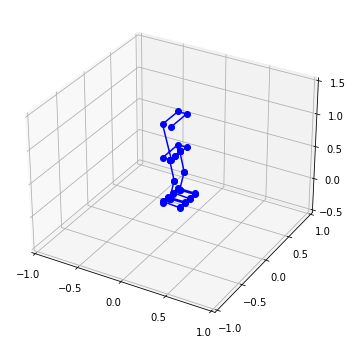

th 1.5108553337242475e-07
sin(th) 1.5108553337242417e-07
wedge [[ 0.          0.3783232  -0.90395977]
 [-0.3783232   0.          0.19931955]
 [ 0.90395977 -0.19931955  0.        ]]
th 3.021735625075227e-07
sin(th) 3.0217356250751807e-07
wedge [[ 0.          0.37832263 -0.90396094]
 [-0.37832263  0.          0.19931534]
 [ 0.90396094 -0.19931534  0.        ]]
th 4.5318467867875616e-07
sin(th) 4.5318467867874064e-07
wedge [[ 0.          0.37835333 -0.90394624]
 [-0.37835333  0.          0.19932374]
 [ 0.90394624 -0.19932374  0.        ]]
th 6.04039478986742e-07
sin(th) 6.040394789867053e-07
wedge [[ 0.          0.37841533 -0.90391565]
 [-0.37841533  0.          0.19934476]
 [ 0.90391565 -0.19934476  0.        ]]
th 7.546585680269823e-07
sin(th) 7.546585680269107e-07
wedge [[ 0.          0.3785087  -0.90386913]
 [-0.3785087   0.          0.19937845]
 [ 0.90386913 -0.19937845  0.        ]]
th 9.049625595856997e-07
sin(th) 9.049625595855762e-07
wedge [[ 0.          0.37863355 -0.9038066 ]
 

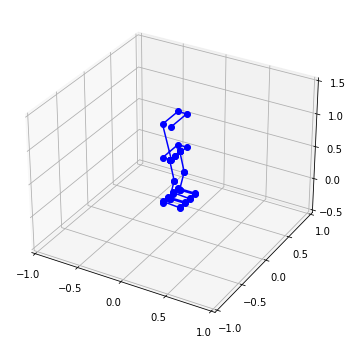

th 1.6489784069710951e-06
sin(th) 1.6489784069703478e-06
wedge [[ 0.          0.37973638 -0.90324969]
 [-0.37973638  0.          0.19985064]
 [ 0.90324969 -0.19985064  0.        ]]
th 1.7957254474477028e-06
sin(th) 1.7957254474467376e-06
wedge [[ 0.          0.38005449 -0.90308826]
 [-0.38005449  0.          0.19997547]
 [ 0.90308826 -0.19997547  0.        ]]
th 1.941602101467599e-06
sin(th) 1.9416021014663794e-06
wedge [[ 0.          0.38040592 -0.90290961]
 [-0.38040592  0.          0.20011391]
 [ 0.90290961 -0.20011391  0.        ]]
th 2.086529127081267e-06
sin(th) 2.086529127079753e-06
wedge [[ 0.          0.38079108 -0.90271347]
 [-0.38079108  0.          0.20026618]
 [ 0.90271347 -0.20026618  0.        ]]
th 2.2304273112475068e-06
sin(th) 2.2304273112456573e-06
wedge [[ 0.          0.38121045 -0.90249953]
 [-0.38121045  0.          0.2004325 ]
 [ 0.90249953 -0.2004325   0.        ]]
th 2.3732174729032737e-06
sin(th) 2.373217472901046e-06
wedge [[ 0.          0.38166455 -0.9022674

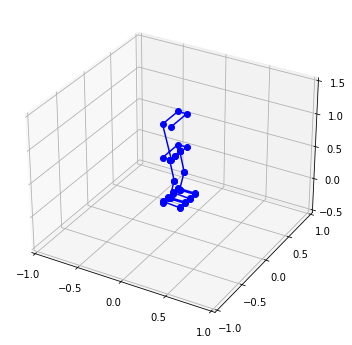

th 3.0677792908363033e-06
sin(th) 3.0677792908314913e-06
wedge [[ 0.          0.38447723 -0.90082049]
 [-0.38447723  0.          0.20174169]
 [ 0.90082049 -0.20174169  0.        ]]
th 3.2022607657883968e-06
sin(th) 3.2022607657829237e-06
wedge [[ 0.          0.38515317 -0.90047043]
 [-0.38515317  0.          0.20201493]
 [ 0.90047043 -0.20201493  0.        ]]
th 3.3350811673988924e-06
sin(th) 3.33508116739271e-06
wedge [[ 0.          0.38586883 -0.90009885]
 [-0.38586883  0.          0.20230497]
 [ 0.90009885 -0.20230497  0.        ]]
th 3.466161719333399e-06
sin(th) 3.4661617193264585e-06
wedge [[ 0.          0.38662513 -0.8997051 ]
 [-0.38662513  0.          0.20261227]
 [ 0.8997051  -0.20261227  0.        ]]
th 3.595423720719828e-06
sin(th) 3.5954237207120815e-06
wedge [[ 0.          0.38742308 -0.8992885 ]
 [-0.38742308  0.          0.20293733]
 [ 0.8992885  -0.20293733  0.        ]]
th 3.722788553458165e-06
sin(th) 3.7227885534495657e-06
wedge [[ 0.          0.38826372 -0.89884829

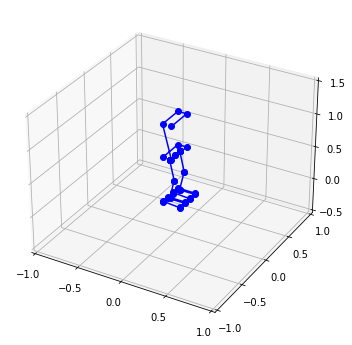

th 4.328410419193823e-06
sin(th) 4.328410419180308e-06
wedge [[ 0.          0.39314956 -0.89626355]
 [-0.39314956  0.          0.20529266]
 [ 0.89626355 -0.20529266  0.        ]]
th 4.442747001061724e-06
sin(th) 4.442747001047108e-06
wedge [[ 0.          0.39427276 -0.89566304]
 [-0.39427276  0.          0.20575887]
 [ 0.89566304 -0.20575887  0.        ]]
th 4.554639178886482e-06
sin(th) 4.554639178870735e-06
wedge [[ 0.          0.39544819 -0.89503209]
 [-0.39544819  0.          0.20624812]
 [ 0.89503209 -0.20624812  0.        ]]
th 4.664009356235109e-06
sin(th) 4.664009356218199e-06
wedge [[ 0.          0.39667756 -0.89436943]
 [-0.39667756  0.          0.20676128]
 [ 0.89436943 -0.20676128  0.        ]]
th 4.770780124818632e-06
sin(th) 4.770780124800535e-06
wedge [[ 0.          0.39796271 -0.89367371]
 [-0.39796271  0.          0.20729926]
 [ 0.89367371 -0.20729926  0.        ]]
th 4.874874282334305e-06
sin(th) 4.8748742823149965e-06
wedge [[ 0.          0.39930555 -0.89294347]
 [-0

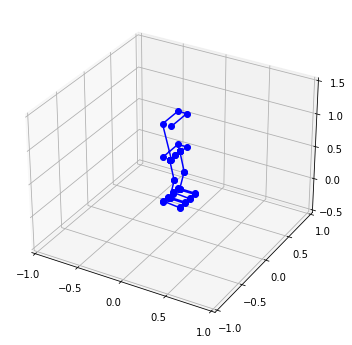

th 5.352510866668242e-06
sin(th) 5.352510866642685e-06
wedge [[ 0.          0.4069609  -0.8887164 ]
 [-0.4069609   0.          0.21110658]
 [ 0.8887164  -0.21110658  0.        ]]
th 5.438938356719709e-06
sin(th) 5.438938356692893e-06
wedge [[ 0.          0.40869726 -0.88774244]
 [-0.40869726  0.          0.21184881]
 [ 0.88774244 -0.21184881  0.        ]]
th 5.522156487880588e-06
sin(th) 5.522156487852522e-06
wedge [[ 0.          0.41050842 -0.88672051]
 [-0.41050842  0.          0.21262542]
 [ 0.88672051 -0.21262542  0.        ]]
th 5.602090591762071e-06
sin(th) 5.602090591732769e-06
wedge [[ 0.          0.41239747 -0.8856481 ]
 [-0.41239747  0.          0.21343796]
 [ 0.8856481  -0.21343796  0.        ]]
th 5.678666467565858e-06
sin(th) 5.6786664675353375e-06
wedge [[ 0.          0.41436767 -0.8845225 ]
 [-0.41436767  0.          0.21428808]
 [ 0.8845225  -0.21428808  0.        ]]
th 5.751810427313495e-06
sin(th) 5.75181042728178e-06
wedge [[ 0.          0.41642248 -0.8833408 ]
 [-0.

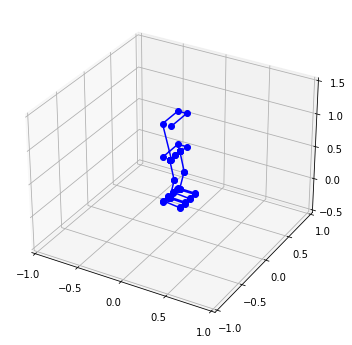

th 6.063515035870787e-06
sin(th) 6.063515035833632e-06
wedge [[ 0.          0.42810273 -0.87647201]
 [-0.42810273  0.          0.22028361]
 [ 0.87647201 -0.22028361  0.        ]]
th 6.1145557480458455e-06
sin(th) 6.114555748007744e-06
wedge [[ 0.          0.43075105 -0.87487851]
 [-0.43075105  0.          0.2214523 ]
 [ 0.87487851 -0.2214523   0.        ]]
th 6.161668001185207e-06
sin(th) 6.161668001146218e-06
wedge [[ 0.          0.43351517 -0.87320099]
 [-0.43351517  0.          0.22267606]
 [ 0.87320099 -0.22267606  0.        ]]
th 6.204784519893146e-06
sin(th) 6.204784519853333e-06
wedge [[ 0.          0.43640076 -0.87143404]
 [-0.43640076  0.          0.22395778]
 [ 0.87143404 -0.22395778  0.        ]]
th 6.243839235574398e-06
sin(th) 6.2438392355338285e-06
wedge [[ 0.          0.43941388 -0.8695718 ]
 [-0.43941388  0.          0.22530051]
 [ 0.8695718  -0.22530051  0.        ]]
th 6.2787674117960996e-06
sin(th) 6.278767411754845e-06
wedge [[ 0.          0.44256099 -0.8676079 ]
 [

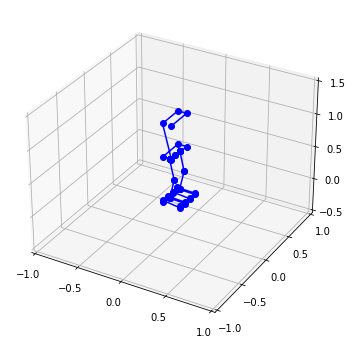

th 6.389356743337358e-06
sin(th) 6.3893567432938845e-06
wedge [[ 0.          0.46056464 -0.85599717]
 [-0.46056464  0.          0.23483838]
 [ 0.85599717 -0.23483838  0.        ]]
th 6.398260684377209e-06
sin(th) 6.3982606843335534e-06
wedge [[ 0.          0.46467806 -0.85325313]
 [-0.46467806  0.          0.23671374]
 [ 0.85325313 -0.23671374  0.        ]]
th 6.40263633468278e-06
sin(th) 6.402636334639035e-06
wedge [[ 0.          0.46898489 -0.85034305]
 [-0.46898489  0.          0.23868362]
 [ 0.85034305 -0.23868362  0.        ]]
th 6.4024363395698724e-06
sin(th) 6.402436339526132e-06
wedge [[ 0.          0.47349614 -0.84725385]
 [-0.47349614  0.          0.24075366]
 [ 0.84725385 -0.24075366  0.        ]]
th 6.397616754523199e-06
sin(th) 6.397616754479557e-06
wedge [[ 0.          0.47822361 -0.84397112]
 [-0.47822361  0.          0.24292988]
 [ 0.84397112 -0.24292988  0.        ]]
th 6.388137446357724e-06
sin(th) 6.388137446314275e-06
wedge [[ 0.          0.48317995 -0.84047897]
 [-

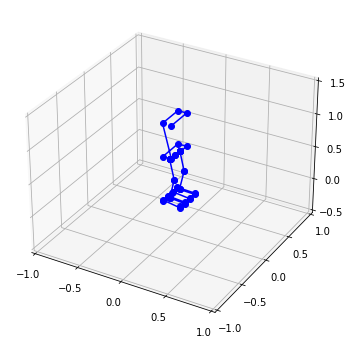

th 6.269770135408107e-06
sin(th) 6.269770135367029e-06
wedge [[ 0.          0.51190383 -0.81919062]
 [-0.51190383  0.          0.25861399]
 [ 0.81919062 -0.25861399  0.        ]]
th 6.231769201238813e-06
sin(th) 6.231769201198478e-06
wedge [[ 0.          0.51855386 -0.81399776]
 [-0.51855386  0.          0.26174327]
 [ 0.81399776 -0.26174327  0.        ]]
th 6.188981785691923e-06
sin(th) 6.188981785652413e-06
wedge [[ 0.          0.52555013 -0.8084231 ]
 [-0.52555013  0.          0.26504557]
 [ 0.8084231  -0.26504557  0.        ]]
th 6.1414213277480946e-06
sin(th) 6.1414213277094885e-06
wedge [[ 0.          0.53291427 -0.80242937]
 [-0.53291427  0.          0.26853208]
 [ 0.80242937 -0.26853208  0.        ]]
th 6.089112489174059e-06
sin(th) 6.089112489136431e-06
wedge [[ 0.          0.54066931 -0.79597476]
 [-0.54066931  0.          0.27221476]
 [ 0.79597476 -0.27221476  0.        ]]
th 6.032092709238019e-06
sin(th) 6.032092709201438e-06
wedge [[ 0.          0.54883963 -0.78901228]
 [-

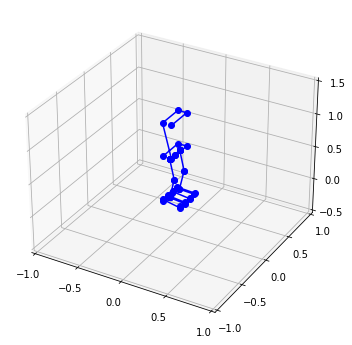

th 5.678787390609766e-06
sin(th) 5.678787390579244e-06
wedge [[ 0.          0.59686319 -0.74447251]
 [-0.59686319  0.          0.2991906 ]
 [ 0.74447251 -0.2991906   0.        ]]
th 5.5952713714663425e-06
sin(th) 5.595271371437147e-06
wedge [[ 0.          0.60810416 -0.73307844]
 [-0.60810416  0.          0.30463969]
 [ 0.73307844 -0.30463969  0.        ]]
th 5.507858840585572e-06
sin(th) 5.507858840557724e-06
wedge [[ 0.          0.61995916 -0.72062512]
 [-0.61995916  0.          0.31040309]
 [ 0.72062512 -0.31040309  0.        ]]
th 5.416785953399205e-06
sin(th) 5.416785953372715e-06
wedge [[ 0.          0.63245568 -0.70698663]
 [-0.63245568  0.          0.316496  ]
 [ 0.70698663 -0.316496    0.        ]]
th 5.322333648158969e-06
sin(th) 5.322333648133841e-06
wedge [[ 0.          0.64561822 -0.6920201 ]
 [-0.64561822  0.          0.32293235]
 [ 0.6920201  -0.32293235  0.        ]]
th 5.2248346918713675e-06
sin(th) 5.2248346918475955e-06
wedge [[ 0.          0.65946633 -0.67556372]
 [

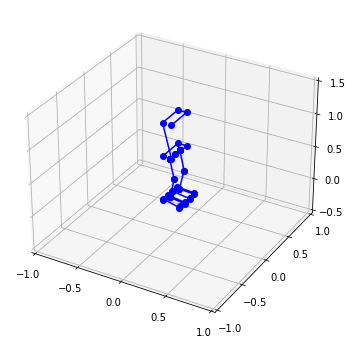

th 4.708049001139084e-06
sin(th) 4.708049001121691e-06
wedge [[ 0.          0.73894239 -0.56369167]
 [-0.73894239  0.          0.36907432]
 [ 0.56369167 -0.36907432  0.        ]]
th 4.603349449445406e-06
sin(th) 4.603349449429148e-06
wedge [[ 0.          0.7566073  -0.53360198]
 [-0.7566073   0.          0.37790782]
 [ 0.53360198 -0.37790782  0.        ]]
th 4.500230630064037e-06
sin(th) 4.500230630048847e-06
wedge [[ 0.          0.77462146 -0.50022964]
 [-0.77462146  0.          0.38695206]
 [ 0.50022964 -0.38695206  0.        ]]
th 4.3998389682827935e-06
sin(th) 4.399838968268598e-06
wedge [[ 0.          0.79278405 -0.46323742]
 [-0.79278405  0.          0.39611179]
 [ 0.46323742 -0.39611179  0.        ]]
th 4.303485506136366e-06
sin(th) 4.3034855061230825e-06
wedge [[ 0.          0.81082458 -0.4222914 ]
 [-0.81082458  0.          0.4052573 ]
 [ 0.4222914  -0.4052573   0.        ]]
th 4.212656576730322e-06
sin(th) 4.2126565767178625e-06
wedge [[ 0.          0.82839126 -0.3770822 ]
 [

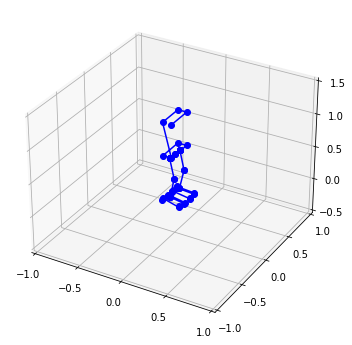

th 3.9053721176893056e-06
sin(th) 3.905372117679378e-06
wedge [[ 0.          0.8906362  -0.08236911]
 [-0.8906362   0.          0.44719402]
 [ 0.08236911 -0.44719402  0.        ]]
th 3.887858269863384e-06
sin(th) 3.88785826985359e-06
wedge [[ 0.          0.89338731 -0.01107974]
 [-0.89338731  0.          0.44915071]
 [ 0.01107974 -0.44915071  0.        ]]
th 3.889986232694897e-06
sin(th) 3.889986232685087e-06
wedge [[ 0.          0.89141846  0.06276872]
 [-0.89141846  0.          0.44881311]
 [-0.06276872 -0.44881311  0.        ]]
th 3.913659433189753e-06
sin(th) 3.9136594331797624e-06
wedge [[ 0.          0.88433858  0.13801763]
 [-0.88433858  0.          0.44597804]
 [-0.13801763 -0.44597804  0.        ]]
th 3.960492019068608e-06
sin(th) 3.960492019058254e-06
wedge [[ 0.          0.87200136  0.21335116]
 [-0.87200136  0.          0.44056204]
 [-0.21335116 -0.44056204  0.        ]]
th 4.031730682651629e-06
sin(th) 4.031730682640707e-06
wedge [[ 0.          0.85454045  0.28740338]
 [-0

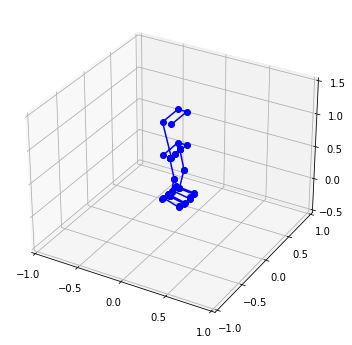

th 4.7689022028152975e-06
sin(th) 4.768902202797222e-06
wedge [[ 0.          0.71121819  0.60077508]
 [-0.71121819  0.          0.3650178 ]
 [-0.60077508 -0.3650178   0.        ]]
th 4.990536943419847e-06
sin(th) 4.990536943399132e-06
wedge [[ 0.          0.67701306  0.64812709]
 [-0.67701306  0.          0.34868982]
 [-0.64812709 -0.34868982  0.        ]]
th 5.235131015563792e-06
sin(th) 5.23513101553988e-06
wedge [[ 0.          0.6427395   0.69026023]
 [-0.6427395   0.          0.3323052 ]
 [-0.69026023 -0.3323052   0.        ]]
th 5.501709421821265e-06
sin(th) 5.50170942179351e-06
wedge [[ 0.          0.60894567  0.72749035]
 [-0.60894567  0.          0.31613757]
 [-0.72749035 -0.31613757  0.        ]]
th 5.7892956004047444e-06
sin(th) 5.7892956003724056e-06
wedge [[ 0.          0.57604948  0.76021632]
 [-0.57604948  0.          0.30039665]
 [-0.76021632 -0.30039665  0.        ]]
th 6.096947897284488e-06
sin(th) 6.096947897246715e-06
wedge [[ 0.          0.54435004  0.78887568]
 [-0

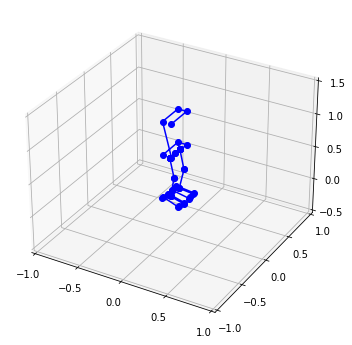

th 7.907942555079516e-06
sin(th) 7.907942554997094e-06
wedge [[ 0.          0.40822546  0.88588226]
 [-0.40822546  0.          0.22037376]
 [-0.88588226 -0.22037376  0.        ]]
th 8.320115071968533e-06
sin(th) 8.32011507187254e-06
wedge [[ 0.          0.38558461  0.89853537]
 [-0.38558461  0.          0.2096633 ]
 [-0.89853537 -0.2096633   0.        ]]
th 8.747767099159529e-06
sin(th) 8.747767099047961e-06
wedge [[ 0.          0.36436336  0.90960233]
 [-0.36436336  0.          0.19965705]
 [-0.90960233 -0.19965705  0.        ]]
th 9.190523881518585e-06
sin(th) 9.190523881389204e-06
wedge [[ 0.          0.34448645  0.91929742]
 [-0.34448645  0.          0.19031904]
 [-0.91929742 -0.19031904  0.        ]]
th 9.64806480465895e-06
sin(th) 9.648064804509267e-06
wedge [[ 0.          0.3258746   0.92780557]
 [-0.3258746   0.          0.18161104]
 [-0.92780557 -0.18161104  0.        ]]
th 9.489049146045225e-06
sin(th) 9.489049145902824e-06
wedge [[ 0.          0.24089298  0.97032843]
 [-0.24

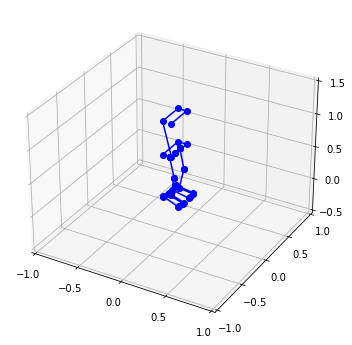

th 1.1766477110544986e-05
sin(th) 1.1766477110273475e-05
wedge [[ 0.          0.05824742  0.97904394]
 [-0.05824742  0.         -0.19514148]
 [-0.97904394  0.19514148  0.        ]]
th 1.2339235276393366e-05
sin(th) 1.2339235276080243e-05
wedge [[ 0.          0.05665778  0.98198984]
 [-0.05665778  0.         -0.18023829]
 [-0.98198984  0.18023829  0.        ]]
th 1.292704176351344e-05
sin(th) 1.2927041763153403e-05
wedge [[ 0.          0.05524352  0.98453099]
 [-0.05524352  0.         -0.1662735 ]
 [-0.98453099  0.1662735   0.        ]]
th 1.3529816501242927e-05
sin(th) 1.352981650083014e-05
wedge [[ 0.          0.05398777  0.98672432]
 [-0.05398777  0.         -0.15316803]
 [-0.98672432  0.15316803  0.        ]]
th 1.4147500152649355e-05
sin(th) 1.4147500152177414e-05
wedge [[ 0.          0.05287536  0.98861796]
 [-0.05287536  0.         -0.14085004]
 [-0.98861796  0.14085004  0.        ]]
th 1.4780051355414666e-05
sin(th) 1.478005135487655e-05
wedge [[ 0.          0.05189264  0.990252

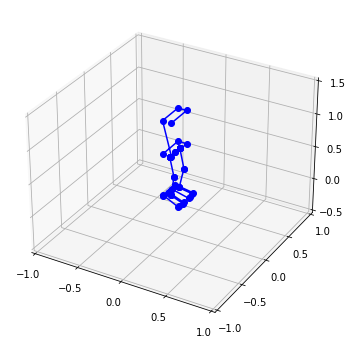

th 1.8165358890421738e-05
sin(th) 1.8165358889422703e-05
wedge [[ 0.          0.04853383  0.99559466]
 [-0.04853383  0.         -0.08022312]
 [-0.99559466  0.08022312  0.        ]]
th 1.8886992817372332e-05
sin(th) 1.888699281624944e-05
wedge [[ 0.          0.04810914  0.99625131]
 [-0.04810914  0.         -0.07189469]
 [-0.99625131  0.07189469  0.        ]]
th 1.9623545205457575e-05
sin(th) 1.9623545204198125e-05
wedge [[ 0.          0.04774934  0.99680862]
 [-0.04774934  0.         -0.0639732 ]
 [-0.99680862  0.0639732   0.        ]]
th 2.0375055659598462e-05
sin(th) 2.03750556581887e-05
wedge [[ 0.          0.04744827  0.99727855]
 [-0.04744827  0.         -0.05642838]
 [-0.99727855  0.05642838  0.        ]]
th 2.1141569008336078e-05
sin(th) 2.1141569006761152e-05
wedge [[ 0.          0.04720031  0.99767143]
 [-0.04720031  0.         -0.04923262]
 [-0.99767143  0.04923262  0.        ]]
th 2.192313463127271e-05
sin(th) 2.192313462951658e-05
wedge [[ 0.          0.04700029  0.99799626

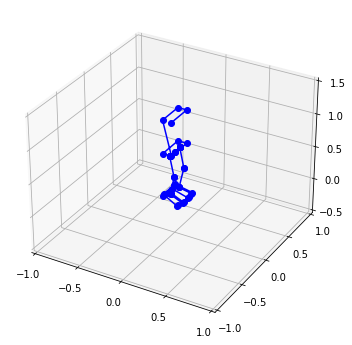

th 2.6058723831741964e-05
sin(th) 2.6058723828792738e-05
wedge [[ 0.          0.04656547  0.99884177]
 [-0.04656547  0.         -0.01211525]
 [-0.99884177  0.01211525  0.        ]]
th 2.693182737096222e-05
sin(th) 2.6931827367706505e-05
wedge [[ 0.          0.04656508  0.99889236]
 [-0.04656508  0.         -0.0067637 ]
 [-0.99889236  0.0067637   0.        ]]
th 2.7820413389638077e-05
sin(th) 2.7820413386049358e-05
wedge [[ 0.          0.04658587  0.99891299]
 [-0.04658587  0.         -0.00160941]
 [-0.99891299  0.00160941  0.        ]]
th 2.872455068556826e-05
sin(th) 2.8724550681618156e-05
wedge [[ 0.          0.04662495  0.99890681]
 [-0.04662495  0.          0.0033604 ]
 [-0.99890681 -0.0033604   0.        ]]
th 2.9644308951797782e-05
sin(th) 2.9644308947455952e-05
wedge [[ 0.          0.04667955  0.99887661]
 [-0.04667955  0.          0.00815752]
 [-0.99887661 -0.00815752  0.        ]]
th 3.057975852009072e-05
sin(th) 3.0579758515324755e-05
wedge [[ 0.          0.04674706  0.998824

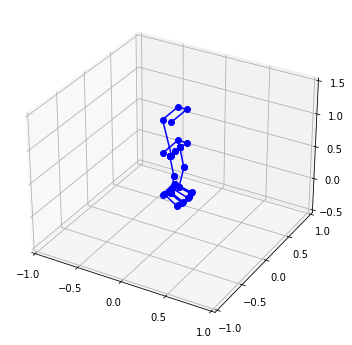

th 3.549485285362235e-05
sin(th) 3.549485284616911e-05
wedge [[ 0.          0.04719372  0.99831134]
 [-0.04719372  0.          0.03387057]
 [-0.99831134 -0.03387057  0.        ]]
th 3.65259340630416e-05
sin(th) 3.6525934054919795e-05
wedge [[ 0.          0.04728899  0.99816869]
 [-0.04728899  0.          0.03772278]
 [-0.99816869 -0.03772278  0.        ]]
th 3.757319792797014e-05
sin(th) 3.7573197919129505e-05
wedge [[ 0.          0.04738117  0.99801566]
 [-0.04738117  0.          0.04147008]
 [-0.99801566 -0.04147008  0.        ]]
th 3.8636712075688745e-05
sin(th) 3.863671206607596e-05
wedge [[ 0.          0.04746815  0.99785325]
 [-0.04746815  0.          0.04511845]
 [-0.99785325 -0.04511845  0.        ]]
th 3.971654292997094e-05
sin(th) 3.971654291952943e-05
wedge [[ 0.          0.04754784  0.99768236]
 [-0.04754784  0.          0.04867345]
 [-0.99768236 -0.04867345  0.        ]]
th 4.081275553387237e-05
sin(th) 4.08127555225422e-05
wedge [[ 0.          0.04761815  0.99750384]
 [-0

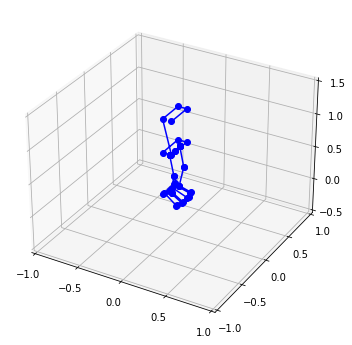

th 4.654170292252158e-05
sin(th) 4.6541702905719016e-05
wedge [[ 0.          0.04775453  0.99652067]
 [-0.04775453  0.          0.06830859]
 [-0.99652067 -0.06830859  0.        ]]
th 4.7737472994209806e-05
sin(th) 4.7737472976078584e-05
wedge [[ 0.          0.04772355  0.99630998]
 [-0.04772355  0.          0.07133639]
 [-0.99630998 -0.07133639  0.        ]]
th 4.8950027170480144e-05
sin(th) 4.895002715093191e-05
wedge [[ 0.          0.0476679   0.99609577]
 [-0.0476679   0.          0.07430342]
 [-0.99609577 -0.07430342  0.        ]]
th 5.017941342115248e-05
sin(th) 5.017941340009407e-05
wedge [[ 0.          0.04758522  0.99587844]
 [-0.04758522  0.          0.07721255]
 [-0.99587844 -0.07721255  0.        ]]
th 5.14256768840914e-05
sin(th) 5.142567686142468e-05
wedge [[ 0.          0.0474731   0.99565841]
 [-0.0474731   0.          0.08006646]
 [-0.99565841 -0.08006646  0.        ]]
th 5.268885972895932e-05
sin(th) 5.268885970458093e-05
wedge [[ 0.          0.04732906  0.99543604]
 [

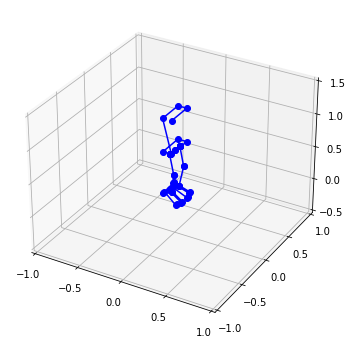

th 5.925981774337662e-05
sin(th) 5.9259817708692576e-05
wedge [[ 0.          0.04603801  0.99430108]
 [-0.04603801  0.          0.0961554 ]
 [-0.99430108 -0.0961554   0.        ]]
th 6.0625221657562845e-05
sin(th) 6.062522162042568e-05
wedge [[ 0.          0.04564609  0.99407162]
 [-0.04564609  0.          0.09868158]
 [-0.99407162 -0.09868158  0.        ]]
th 6.200774790689529e-05
sin(th) 6.200774786715906e-05
wedge [[ 0.          0.04520269  0.99384199]
 [-0.04520269  0.          0.10116729]
 [-0.99384199 -0.10116729  0.        ]]
th 6.34074114751285e-05
sin(th) 6.340741143264026e-05
wedge [[ 0.          0.04470466  0.99361245]
 [-0.04470466  0.          0.10361364]
 [-0.99361245 -0.10361364  0.        ]]
th 6.48242237948566e-05
sin(th) 6.48242237494561e-05
wedge [[ 0.          0.04414876  0.99338326]
 [-0.04414876  0.          0.1060216 ]
 [-0.99338326 -0.1060216   0.        ]]
th 6.625819280063632e-05
sin(th) 6.625819275215578e-05
wedge [[ 0.          0.04353165  0.99315466]
 [-0.0

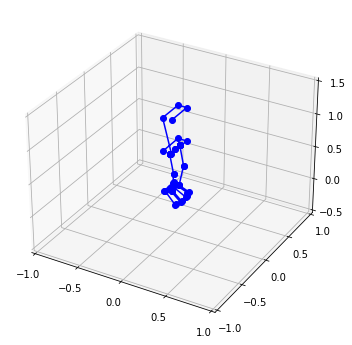

th 7.368543540762113e-05
sin(th) 7.368543534094142e-05
wedge [[ 0.          0.03940527  0.99202788]
 [-0.03940527  0.          0.11969926]
 [-0.99202788 -0.11969926  0.        ]]
th 7.522233147715432e-05
sin(th) 7.522233140621466e-05
wedge [[ 0.          0.0383461   0.99180707]
 [-0.0383461   0.          0.12185362]
 [-0.99180707 -0.12185362  0.        ]]
th 7.677635447751596e-05
sin(th) 7.67763544020882e-05
wedge [[ 0.          0.03720008  0.99158814]
 [-0.03720008  0.          0.12397223]
 [-0.99158814 -0.12397223  0.        ]]
th 7.834749115759939e-05
sin(th) 7.834749107744561e-05
wedge [[ 0.          0.03596325  0.99137119]
 [-0.03596325  0.          0.12605482]
 [-0.99137119 -0.12605482  0.        ]]
th 7.99357271984131e-05
sin(th) 7.993572711328527e-05
wedge [[ 0.          0.03463167  0.99115629]
 [-0.03463167  0.          0.12810094]
 [-0.99115629 -0.12810094  0.        ]]
th 8.154104774287027e-05
sin(th) 8.154104765250997e-05
wedge [[ 0.          0.03320135  0.99094351]
 [-0.03

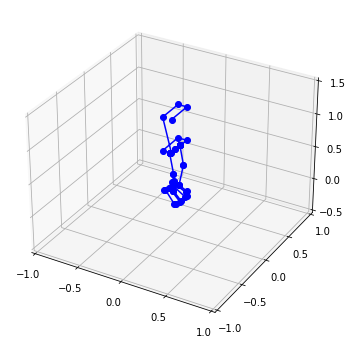

th 8.982343769084401e-05
sin(th) 8.982343757005769e-05
wedge [[ 0.          0.02442999  0.98991075]
 [-0.02442999  0.          0.13957035]
 [-0.98991075 -0.13957035  0.        ]]
th 9.153100220935565e-05
sin(th) 9.153100208154902e-05
wedge [[ 0.          0.02232477  0.98970972]
 [-0.02232477  0.          0.14133746]
 [-0.98970972 -0.14133746  0.        ]]
th 9.325558643790479e-05
sin(th) 9.325558630273697e-05
wedge [[ 0.          0.02009403  0.98951007]
 [-0.02009403  0.          0.14305963]
 [-0.98951007 -0.14305963  0.        ]]
th 9.499719534411061e-05
sin(th) 9.499719520122743e-05
wedge [[ 0.          0.01773442  0.98931149]
 [-0.01773442  0.          0.14473515]
 [-0.98931149 -0.14473515  0.        ]]
th 9.675583960591828e-05
sin(th) 9.675583945495189e-05
wedge [[ 0.          0.01524279  0.98911362]
 [-0.01524279  0.          0.14636222]
 [-0.98911362 -0.14636222  0.        ]]
th 9.853153622239804e-05
sin(th) 9.853153606296639e-05
wedge [[ 0.          0.01261624  0.98891603]
 [-0.

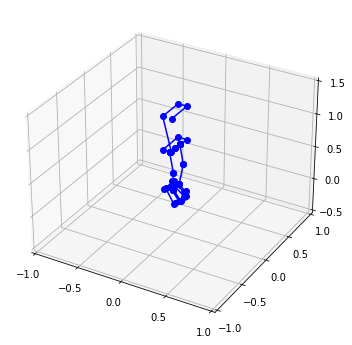

th 0.00010766689387394765
sin(th) 0.00010766689366593233
wedge [[ 0.         -0.002619    0.98791277]
 [ 0.002619    0.          0.1549887 ]
 [-0.98791277 -0.1549887   0.        ]]
th 0.00010954566001317567
sin(th) 0.00010954565979407976
wedge [[ 0.         -0.00609681  0.98770427]
 [ 0.00609681  0.          0.15621495]
 [-0.98770427 -0.15621495  0.        ]]
th 0.00011144179589268682
sin(th) 0.00011144179566201579
wedge [[ 0.         -0.00971944  0.98749127]
 [ 0.00971944  0.          0.15737382]
 [-0.98749127 -0.15737382  0.        ]]
th 0.0001133553715199499
sin(th) 0.00011335537127719105
wedge [[ 0.         -0.01348635  0.98727288]
 [ 0.01348635  0.          0.15846253]
 [-0.98727288 -0.15846253  0.        ]]
th 0.00011528645982119922
sin(th) 0.00011528645956582111
wedge [[ 0.         -0.01739642  0.98704815]
 [ 0.01739642  0.          0.15947823]
 [-0.98704815 -0.15947823  0.        ]]
th 0.00011723513457979304
sin(th) 0.00011723513431124493
wedge [[ 0.         -0.02144787  0.9868

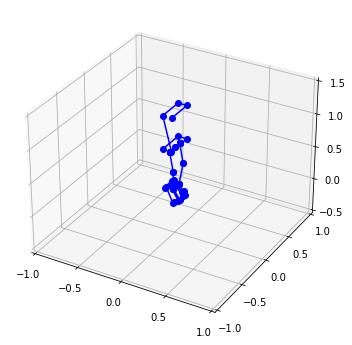

th 0.00012724459086881017
sin(th) 0.0001272445905254367
wedge [[ 0.         -0.04371793  0.98551165]
 [ 0.04371793  0.          0.16387658]
 [-0.98551165 -0.16387658  0.        ]]
th 0.00012930000537598026
sin(th) 0.00012930000501569676
wedge [[ 0.         -0.04854352  0.98521521]
 [ 0.04854352  0.          0.16430007]
 [-0.98521521 -0.16430007  0.        ]]
th 0.00013137327651250474
sin(th) 0.00013137327613461087
wedge [[ 0.         -0.05347956  0.9849049 ]
 [ 0.05347956  0.          0.16462769]
 [-0.9849049  -0.16462769  0.        ]]
th 0.0001334643557642143
sin(th) 0.0001334643553679868
wedge [[ 0.         -0.05851908  0.98457998]
 [ 0.05851908  0.          0.16485684]
 [-0.98457998 -0.16485684  0.        ]]
th 0.00013557315711727988
sin(th) 0.00013557315670197228
wedge [[ 0.         -0.06365457  0.98423982]
 [ 0.06365457  0.          0.16498505]
 [-0.98423982 -0.16498505  0.        ]]
th 0.00013769955125529827
sin(th) 0.0001376995508201409
wedge [[ 0.         -0.06887804  0.9838838

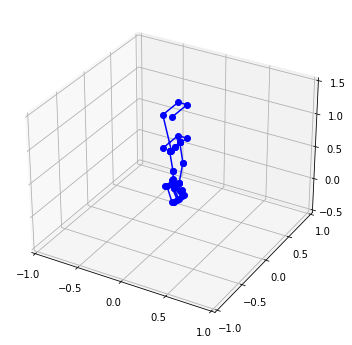

th 0.00014858713322395196
sin(th) 0.00014858713267719748
wedge [[ 0.         -0.09601064  0.98185781]
 [ 0.09601064  0.          0.16351515]
 [-0.98185781 -0.16351515  0.        ]]
th 0.00015081322930303424
sin(th) 0.0001508132287313357
wedge [[ 0.         -0.10157678  0.98140309]
 [ 0.10157678  0.          0.16288076]
 [-0.98140309 -0.16288076  0.        ]]
th 0.00015305433590158415
sin(th) 0.00015305433530401845
wedge [[ 0.         -0.10716831  0.98093236]
 [ 0.10716831  0.          0.16213162]
 [-0.98093236 -0.16213162  0.        ]]
th 0.00015530978881429393
sin(th) 0.00015530978818991932
wedge [[ 0.         -0.11277657  0.98044604]
 [ 0.11277657  0.          0.1612669 ]
 [-0.98044604 -0.1612669   0.        ]]
th 0.0001575788404023902
sin(th) 0.00015757883975024776
wedge [[ 0.         -0.11839328  0.97994462]
 [ 0.11839328  0.          0.16028593]
 [-0.97994462 -0.16028593  0.        ]]
th 0.00015986065825459447
sin(th) 0.00015986065757370982
wedge [[ 0.         -0.12401072  0.97942

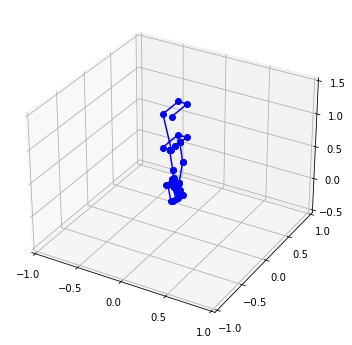

th 0.00017142617821824894
sin(th) 0.00017142617737863397
wedge [[ 0.         -0.15188897  0.97664853]
 [ 0.15188897  0.          0.15194536]
 [-0.97664853 -0.15194536  0.        ]]
th 0.000173762404253764
sin(th) 0.0001737624033793518
wedge [[ 0.         -0.15739165  0.97605515]
 [ 0.15739165  0.          0.15014728]
 [-0.97605515 -0.15014728  0.        ]]
th 0.00017610325388709453
sin(th) 0.00017610325297686506
wedge [[ 0.         -0.16286469  0.97544956]
 [ 0.16286469  0.          0.14823378]
 [-0.97544956 -0.14823378  0.        ]]
th 0.0001784472630064776
sin(th) 0.00017844726205941557
wedge [[ 0.         -0.16830826  0.97483141]
 [ 0.16830826  0.          0.14620553]
 [-0.97483141 -0.14620553  0.        ]]
th 0.00018079290407826563
sin(th) 0.0001807929030933639
wedge [[ 0.         -0.1737239   0.97420007]
 [ 0.1737239   0.          0.14406329]
 [-0.97420007 -0.14406329  0.        ]]
th 0.000183138591084675
sin(th) 0.0001831385900609381
wedge [[ 0.         -0.17911458  0.97355456]
 

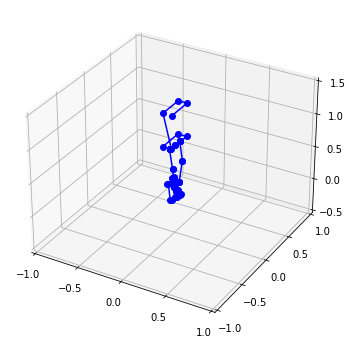

th 0.00019480878259363758
sin(th) 0.00019480878136145704
wedge [[ 0.         -0.20590173  0.97005054]
 [ 0.20590173  0.          0.12886592]
 [-0.97005054 -0.12886592  0.        ]]
th 0.00019711884529291857
sin(th) 0.0001971188440163822
wedge [[ 0.         -0.21128935  0.96927447]
 [ 0.21128935  0.          0.12595161]
 [-0.96927447 -0.12595161  0.        ]]
th 0.00019941667926258618
sin(th) 0.00019941667794088526
wedge [[ 0.         -0.21671565  0.96846386]
 [ 0.21671565  0.          0.12293118]
 [-0.96846386 -0.12293118  0.        ]]
th 0.0002017004391339864
sin(th) 0.0002017004377663543
wedge [[ 0.         -0.22219612  0.96761328]
 [ 0.22219612  0.          0.11980578]
 [-0.96761328 -0.11980578  0.        ]]
th 0.00020396827966364376
sin(th) 0.0002039682782493597
wedge [[ 0.         -0.22774789  0.9667165 ]
 [ 0.22774789  0.          0.11657661]
 [-0.9667165  -0.11657661  0.        ]]
th 0.00020621836597219313
sin(th) 0.0002062183645105856
wedge [[ 0.         -0.23338973  0.96576644

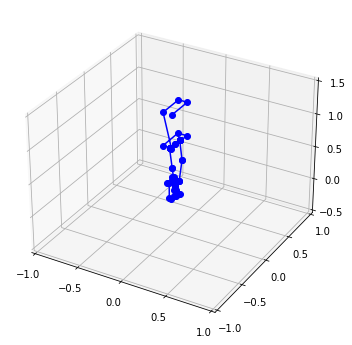

th 0.00021714069007496364
sin(th) 0.00021714068836859685
wedge [[ 0.         -0.26371521  0.95990134]
 [ 0.26371521  0.          0.09509836]
 [-0.95990134 -0.09509836  0.        ]]
th 0.00021924811228413543
sin(th) 0.00021924811052760233
wedge [[ 0.         -0.27037705  0.9584268 ]
 [ 0.27037705  0.          0.09118287]
 [-0.9584268  -0.09118287  0.        ]]
th 0.00022132655797137227
sin(th) 0.00022132655616440895
wedge [[ 0.         -0.2773016   0.95681978]
 [ 0.2773016   0.          0.08717648]
 [-0.95681978 -0.08717648  0.        ]]
th 0.00022337494402614543
sin(th) 0.0002233749421685458
wedge [[ 0.         -0.28451817  0.9550638 ]
 [ 0.28451817  0.          0.08308152]
 [-0.9550638  -0.08308152  0.        ]]
th 0.00022539242119822055
sin(th) 0.00022539241928983255
wedge [[ 0.         -0.29205667  0.95314092]
 [ 0.29205667  0.          0.07890051]
 [-0.95314092 -0.07890051  0.        ]]
th 0.0002273784207084521
sin(th) 0.0002273784187491722
wedge [[ 0.         -0.29994721  0.951031

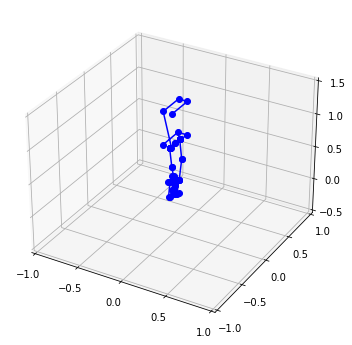

th 0.0002368426436333221
sin(th) 0.00023684264141906293
wedge [[ 0.         -0.34568975  0.93689672]
 [ 0.34568975  0.          0.05218359]
 [-0.93689672 -0.05218359  0.        ]]
th 0.0002386502557307341
sin(th) 0.00023865025346538852
wedge [[ 0.         -0.35627259  0.93317422]
 [ 0.35627259  0.          0.04749441]
 [-0.93317422 -0.04749441  0.        ]]
th 0.00024043473015259969
sin(th) 0.00024043472783605676
wedge [[ 0.         -0.3673768   0.92908922]
 [ 0.3673768   0.          0.04274951]
 [-0.92908922 -0.04274951  0.        ]]
th 0.0002421995756568636
sin(th) 0.00024219957328893349
wedge [[ 0.         -0.37901061  0.92461368]
 [ 0.37901061  0.          0.03795381]
 [-0.92461368 -0.03795381  0.        ]]
th 0.00024394893034489343
sin(th) 0.0002439489279252827
wedge [[ 0.         -0.39117506  0.91972042]
 [ 0.39117506  0.          0.03311235]
 [-0.91972042 -0.03311235  0.        ]]
th 0.00024568751623799535
sin(th) 0.00024568751376628247
wedge [[ 0.         -0.40386275  0.9143839

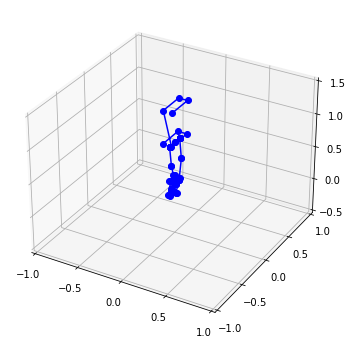

th 0.0002544104931064982
sin(th) 0.00025441049036205776
wedge [[ 0.         -0.47417689  0.88042317]
 [ 0.47417689  0.          0.00336499]
 [-0.88042317 -0.00336499  0.        ]]
th 0.00025619983790006246
sin(th) 0.0002561998350973064
wedge [[ 0.         -0.48926295  0.87213472]
 [ 0.48926295  0.         -0.00167527]
 [-0.87213472  0.00167527  0.        ]]
th 0.00025801497922056817
sin(th) 0.0002580149763578176
wedge [[ 0.         -0.50452121  0.86337303]
 [ 0.50452121  0.         -0.00673408]
 [-0.86337303  0.00673408  0.        ]]
th 0.00025985864338008637
sin(th) 0.0002598586404555283
wedge [[ 0.         -0.5198607   0.85416938]
 [ 0.5198607   0.         -0.0118119 ]
 [-0.85416938  0.0118119   0.        ]]
th 0.00026173208056472967
sin(th) 0.00026173207757646113
wedge [[ 0.         -0.53518454  0.84456589]
 [ 0.53518454  0.         -0.01691033]
 [-0.84456589  0.01691033  0.        ]]
th 0.00026363486147403014
sin(th) 0.0002636348584201129
wedge [[ 0.         -0.55039265  0.8346152 

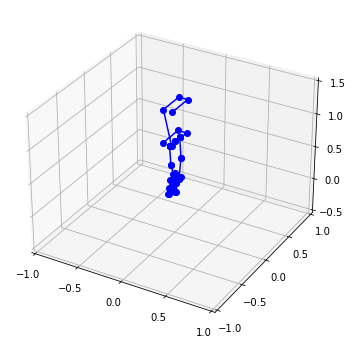

th 0.00027345048448614126
sin(th) 0.000273450481078257
wedge [[ 0.         -0.62134285  0.78206004]
 [ 0.62134285  0.         -0.04811616]
 [-0.78206004  0.04811616  0.        ]]
th 0.00027542483429385755
sin(th) 0.00027542483081162287
wedge [[ 0.         -0.63394161  0.77153159]
 [ 0.63394161  0.         -0.0534513 ]
 [-0.77153159  0.0534513   0.        ]]
th 0.0002773817668403974
sin(th) 0.00027738176328340875
wedge [[ 0.         -0.64586804  0.76117908]
 [ 0.64586804  0.         -0.0588292 ]
 [-0.76117908  0.0588292   0.        ]]
th 0.00027931150208599205
sin(th) 0.0002793114984542482
wedge [[ 0.         -0.65708599  0.75107269]
 [ 0.65708599  0.         -0.06424805]
 [-0.75107269  0.06424805  0.        ]]
th 0.0002812045958163009
sin(th) 0.00028120459211021065
wedge [[ 0.         -0.66757152  0.74127567]
 [ 0.66757152  0.         -0.06970398]
 [-0.74127567  0.06970398  0.        ]]
th 0.0002830522611089649
sin(th) 0.0002830522573293406
wedge [[ 0.         -0.67731206  0.73184334]


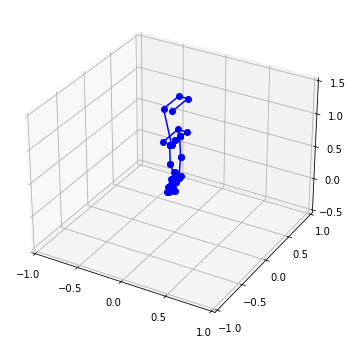

th 0.00029137320319089303
sin(th) 0.00029137319906804264
wedge [[ 0.         -0.71502865  0.69150208]
 [ 0.71502865  0.         -0.10275655]
 [-0.69150208  0.10275655  0.        ]]
th 0.000292823174531969
sin(th) 0.00029282317034726174
wedge [[ 0.         -0.72050204  0.6849581 ]
 [ 0.72050204  0.         -0.10820915]
 [-0.6849581   0.10820915  0.        ]]
th 0.0002941968762092069
sin(th) 0.00029419687196532865
wedge [[ 0.         -0.7253465   0.67894434]
 [ 0.7253465   0.         -0.11360912]
 [-0.67894434  0.11360912  0.        ]]
th 0.0002954942519147547
sin(th) 0.0002954942476144834
wedge [[ 0.         -0.72959218  0.67345973]
 [ 0.72959218  0.         -0.11894218]
 [-0.67345973  0.11894218  0.        ]]
th 0.00029671605910503546
sin(th) 0.00029671605475120106
wedge [[ 0.         -0.73326971  0.66849928]
 [ 0.73326971  0.         -0.12419442]
 [-0.66849928  0.12419442  0.        ]]
th 0.00029786374928251867
sin(th) 0.0002978637448779671
wedge [[ 0.         -0.7364096   0.66405485]

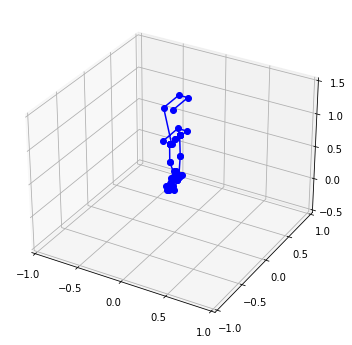

th 0.0003025762028416118
sin(th) 0.0003025761982246843
wedge [[ 0.         -0.74505923  0.64913765]
 [ 0.74505923  0.         -0.15332011]
 [-0.64913765  0.15332011  0.        ]]
th 0.0003033353414378107
sin(th) 0.0003033353367860455
wedge [[ 0.         -0.74556595  0.64750914]
 [ 0.74556595  0.         -0.15768106]
 [-0.64750914  0.15768106  0.        ]]
th 0.00030404159882308206
sin(th) 0.00030404159413874895
wedge [[ 0.         -0.74572093  0.6462934 ]
 [ 0.74572093  0.         -0.16188002]
 [-0.6462934   0.16188002  0.        ]]
th 0.00030469871245333716
sin(th) 0.00030469870773856616
wedge [[ 0.         -0.74554536  0.6454731 ]
 [ 0.74554536  0.         -0.16591144]
 [-0.6454731   0.16591144  0.        ]]
th 0.0003053104490589545
sin(th) 0.0003053104443157292
wedge [[ 0.         -0.74505909  0.64503089]
 [ 0.74505909  0.         -0.16977074]
 [-0.64503089  0.16977074  0.        ]]
th 0.0003058805747939635
sin(th) 0.0003058805700241166
wedge [[ 0.         -0.74428068  0.64494951]
 

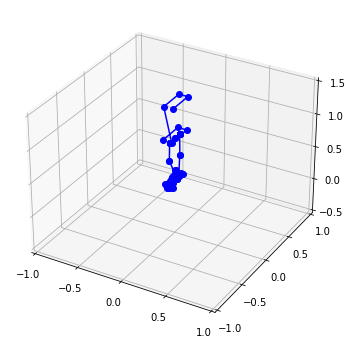

th 0.0003082360752873373
sin(th) 0.0003082360704064459
wedge [[ 0.         -0.73657251  0.64936623]
 [ 0.73657251  0.         -0.18916775]
 [-0.64936623  0.18916775  0.        ]]
th 0.00030863300710520564
sin(th) 0.0003086330022054338
wedge [[ 0.         -0.734366    0.65110085]
 [ 0.734366    0.         -0.19176618]
 [-0.65110085  0.19176618  0.        ]]
th 0.0003090130928024785
sin(th) 0.00030901308788458195
wedge [[ 0.         -0.73196628  0.65308311]
 [ 0.73196628  0.         -0.19418503]
 [-0.65308311  0.19418503  0.        ]]
th 0.0003093795053664919
sin(th) 0.0003093795004310804
wedge [[ 0.         -0.72938391  0.65529831]
 [ 0.72938391  0.         -0.19642616]
 [-0.65529831  0.19642616  0.        ]]
th 0.00030973530734094214
sin(th) 0.0003097353023884831
wedge [[ 0.         -0.72662877  0.65773216]
 [ 0.72662877  0.         -0.1984919 ]
 [-0.65773216  0.1984919   0.        ]]
th 0.0003100834476962164
sin(th) 0.00031008344272703906
wedge [[ 0.         -0.72371008  0.6603708 ]
 

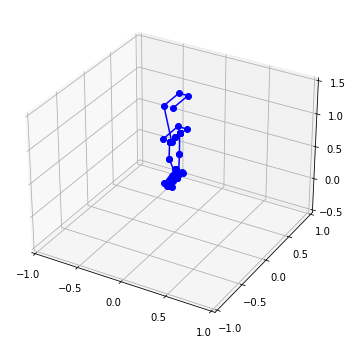

th 0.0003118042638758709
sin(th) 0.0003118042588235038
wedge [[ 0.         -0.70694886  0.67617871]
 [ 0.70694886  0.         -0.20737807]
 [-0.67617871  0.20737807  0.        ]]
th 0.0003121618043905401
sin(th) 0.0003121617993207727
wedge [[ 0.         -0.70321383  0.67977747]
 [ 0.70321383  0.         -0.20830961]
 [-0.67977747  0.20830961  0.        ]]
th 0.000312529038715127
sin(th) 0.00031252903362744596
wedge [[ 0.         -0.69936639  0.68349522]
 [ 0.69936639  0.         -0.20909554]
 [-0.68349522  0.20909554  0.        ]]
th 0.00031290797745501105
sin(th) 0.00031290797234880127
wedge [[ 0.         -0.6954124   0.68732127]
 [ 0.6954124   0.         -0.20974047]
 [-0.68732127  0.20974047  0.        ]]
th 0.0003133005172448892
sin(th) 0.00031330051211943825
wedge [[ 0.         -0.69135752  0.69124531]
 [ 0.69135752  0.         -0.21024915]
 [-0.69124531  0.21024915  0.        ]]
th 0.00031370844256201736
sin(th) 0.0003137084374165199
wedge [[ 0.         -0.68720714  0.69525742]
 

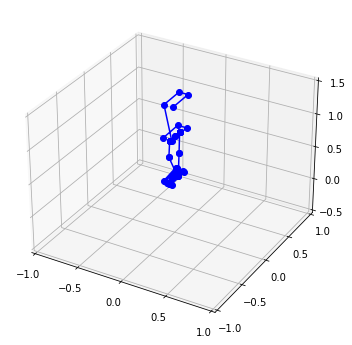

th 0.00031603372915702807
sin(th) 0.0003160337238962612
wedge [[ 0.         -0.66519928  0.71631691]
 [ 0.66519928  0.         -0.2107131 ]
 [-0.71631691  0.2107131   0.        ]]
th 0.0003165654392078101
sin(th) 0.0003165654339204456
wedge [[ 0.         -0.66057969  0.72066921]
 [ 0.66057969  0.         -0.21040521]
 [-0.72066921  0.21040521  0.        ]]
th 0.00031712207776620063
sin(th) 0.00031712207245089574
wedge [[ 0.         -0.65589793  0.72505016]
 [ 0.65589793  0.         -0.21000042]
 [-0.72505016  0.21000042  0.        ]]
th 0.00031770461852858786
sin(th) 0.0003177046131839371
wedge [[ 0.         -0.65115826  0.72945265]
 [ 0.65115826  0.         -0.20950358]
 [-0.72945265  0.20950358  0.        ]]
th 0.0003183139464251976
sin(th) 0.0003183139410497362
wedge [[ 0.         -0.64636491  0.73386992]
 [ 0.64636491  0.         -0.20891947]
 [-0.73386992  0.20891947  0.        ]]
th 0.0003189508606509257
sin(th) 0.0003189508552431324
wedge [[ 0.         -0.64152199  0.73829553]
 

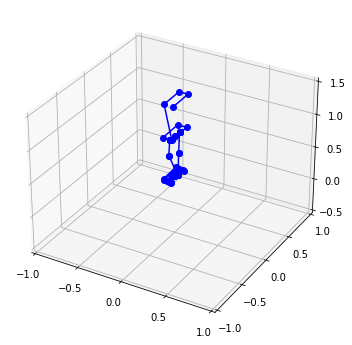

th 0.0003225715841489989
sin(th) 0.00032257157855493954
wedge [[ 0.         -0.61670332  0.76034593]
 [ 0.61670332  0.         -0.20384085]
 [-0.76034593  0.20384085  0.        ]]
th 0.00032338638566233464
sin(th) 0.0003233863800257771
wedge [[ 0.         -0.61164573  0.76470425]
 [ 0.61164573  0.         -0.20277306]
 [-0.76470425  0.20277306  0.        ]]
th 0.000324232225644583
sin(th) 0.00032423221996368126
wedge [[ 0.         -0.60656555  0.76903464]
 [ 0.60656555  0.         -0.20165305]
 [-0.76903464  0.20165305  0.        ]]
th 0.0003251093280013611
sin(th) 0.00032510932227423114
wedge [[ 0.         -0.60146638  0.7733331 ]
 [ 0.60146638  0.         -0.20048467]
 [-0.7733331   0.20048467  0.        ]]
th 0.0003260178583400489
sin(th) 0.0003260178525647706
wedge [[ 0.         -0.59635175  0.77759591]
 [ 0.59635175  0.         -0.19927163]
 [-0.77759591  0.19927163  0.        ]]
th 0.0003269579268751616
sin(th) 0.00032695792104978023
wedge [[ 0.         -0.59122515  0.78181961]
 

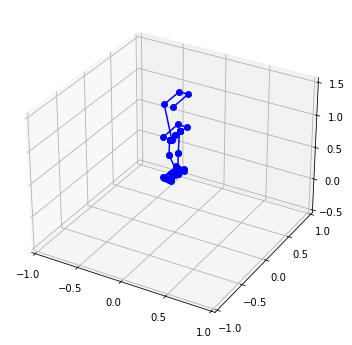

th 0.00033213167676919027
sin(th) 0.00033213167066286915
wedge [[ 0.         -0.56552927  0.80224818]
 [ 0.56552927  0.         -0.19124462]
 [-0.80224818  0.19124462  0.        ]]
th 0.00033326053859025377
sin(th) 0.00033326053242145755
wedge [[ 0.         -0.56039991  0.80617863]
 [ 0.56039991  0.         -0.18981034]
 [-0.80617863  0.18981034  0.        ]]
th 0.00033442039076806476
sin(th) 0.00033442038453463605
wedge [[ 0.         -0.55528094  0.8100526 ]
 [ 0.55528094  0.         -0.18835566]
 [-0.8100526   0.18835566  0.        ]]
th 0.00033561099762252844
sin(th) 0.00033561099132228546
wedge [[ 0.         -0.55017528  0.8138685 ]
 [ 0.55017528  0.         -0.18688292]
 [-0.8138685   0.18688292  0.        ]]
th 0.00033683209132632694
sin(th) 0.0003368320849570647
wedge [[ 0.         -0.54508573  0.81762491]
 [ 0.54508573  0.         -0.1853943 ]
 [-0.81762491  0.1853943   0.        ]]
th 0.0003380833741098703
sin(th) 0.0003380833676693613
wedge [[ 0.         -0.54001504  0.821320

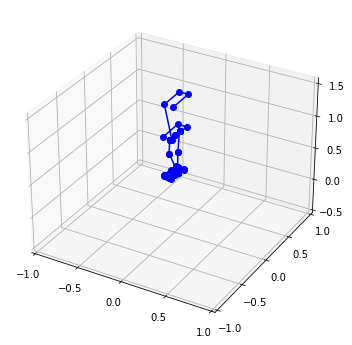

th 0.0003447803669529623
sin(th) 0.00034478036012208747
wedge [[ 0.         -0.51503479  0.83885742]
 [ 0.51503479  0.         -0.17623108]
 [-0.83885742  0.17623108  0.        ]]
th 0.00034620511145999486
sin(th) 0.0003462051045440874
wedge [[ 0.         -0.51013028  0.84217237]
 [ 0.51013028  0.         -0.17467913]
 [-0.84217237  0.17467913  0.        ]]
th 0.00034765729028100395
sin(th) 0.00034765728327770335
wedge [[ 0.         -0.50526153  0.84542247]
 [ 0.50526153  0.         -0.17312317]
 [-0.84542247  0.17312317  0.        ]]
th 0.00034913643566002883
sin(th) 0.00034913642856695845
wedge [[ 0.         -0.50043063  0.84860766]
 [ 0.50043063  0.         -0.17156404]
 [-0.84860766  0.17156404  0.        ]]
th 0.0003506420660722348
sin(th) 0.00035064205888700277
wedge [[ 0.         -0.49563959  0.85172799]
 [ 0.49563959  0.         -0.17000243]
 [-0.85172799  0.17000243  0.        ]]
th 0.0003521736876242306
sin(th) 0.0003521736803444304
wedge [[ 0.         -0.49089031  0.85478362

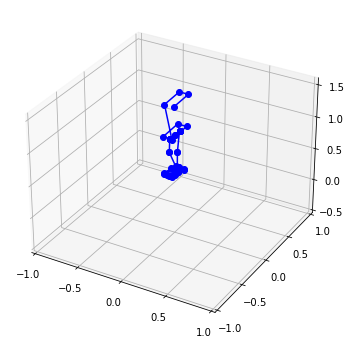

th 0.0003602036712704481
sin(th) 0.0003602036634812428
wedge [[ 0.         -0.46783224  0.86910261]
 [ 0.46783224  0.         -0.16060403]
 [-0.86910261  0.16060403  0.        ]]
th 0.0003618803330987244
sin(th) 0.0003618803252002413
wedge [[ 0.         -0.46336957  0.87177793]
 [ 0.46336957  0.         -0.15903424]
 [-0.87177793  0.15903424  0.        ]]
th 0.000363579284730593
sin(th) 0.00036357927672034173
wedge [[ 0.         -0.45895996  0.87439184]
 [ 0.45895996  0.         -0.15746325]
 [-0.87439184  0.15746325  0.        ]]
th 0.00036529997503539484
sin(th) 0.00036529996691087556
wedge [[ 0.         -0.45460473  0.87694505]
 [ 0.45460473  0.         -0.15589074]
 [-0.87694505  0.15589074  0.        ]]
th 0.0003670418499099653
sin(th) 0.0003670418416686695
wedge [[ 0.         -0.45030513  0.87943832]
 [ 0.45030513  0.         -0.15431631]
 [-0.87943832  0.15431631  0.        ]]
th 0.00036880435298846656
sin(th) 0.0003688043446278778
wedge [[ 0.         -0.44606236  0.88187245]
 [

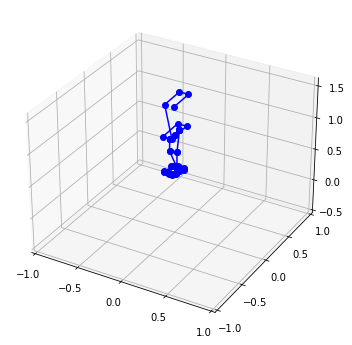

th 0.0003779067361916607
sin(th) 0.00037790672719663007
wedge [[ 0.         -0.42573804  0.8931857 ]
 [ 0.42573804  0.         -0.14479792]
 [-0.8931857   0.14479792  0.        ]]
th 0.00037978127131922364
sin(th) 0.0003797812621896735
wedge [[ 0.         -0.42185769  0.89528313]
 [ 0.42185769  0.         -0.14319291]
 [-0.89528313  0.14319291  0.        ]]
th 0.0003816725228014187
sin(th) 0.000381672513534797
wedge [[ 0.         -0.41804079  0.89732764]
 [ 0.41804079  0.         -0.14158037]
 [-0.89732764  0.14158037  0.        ]]
th 0.00038357993392725465
sin(th) 0.0003835799245210075
wedge [[ 0.         -0.41428806  0.89932018]
 [ 0.41428806  0.         -0.13995937]
 [-0.89932018  0.13995937  0.        ]]
th 0.00038550294914420786
sin(th) 0.0003855029395957802
wedge [[ 0.         -0.41060017  0.90126167]
 [ 0.41060017  0.         -0.13832897]
 [-0.90126167  0.13832897  0.        ]]
th 0.00038744101408100435
sin(th) 0.00038744100438784114
wedge [[ 0.         -0.40697776  0.90315306]


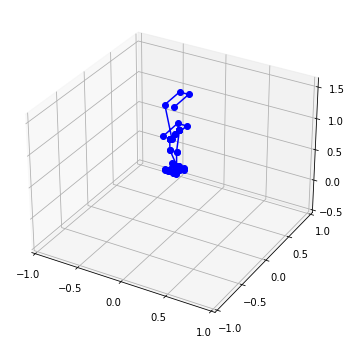

th 0.0003973377495941247
sin(th) 0.0003973377391390238
wedge [[ 0.         -0.38986628  0.91189097]
 [ 0.38986628  0.         -0.12829316]
 [-0.91189097  0.12829316  0.        ]]
th 0.00039935451876980135
sin(th) 0.00039935450815468997
wedge [[ 0.         -0.38664716  0.91350113]
 [ 0.38664716  0.         -0.12656881]
 [-0.91350113  0.12656881  0.        ]]
th 0.0004013824739854718
sin(th) 0.0004013824632078246
wedge [[ 0.         -0.38349655  0.91506755]
 [ 0.38349655  0.         -0.12482699]
 [-0.91506755  0.12482699  0.        ]]
th 0.0004034210605379477
sin(th) 0.00040342104959524886
wedge [[ 0.         -0.38041472  0.91659109]
 [ 0.38041472  0.         -0.12306671]
 [-0.91659109  0.12306671  0.        ]]
th 0.00040546972095931914
sin(th) 0.00040546970984906407
wedge [[ 0.         -0.37740186  0.91807259]
 [ 0.37740186  0.         -0.12128703]
 [-0.91807259  0.12128703  0.        ]]
th 0.00040752789404030184
sin(th) 0.0004075278827599988
wedge [[ 0.         -0.37445813  0.91951289]

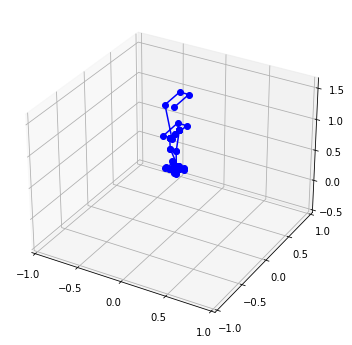

th 0.0004179413966317207
sin(th) 0.00041794138446440114
wedge [[ 0.         -0.36077796  0.92612412]
 [ 0.36077796  0.         -0.11015161]
 [-0.92612412  0.11015161  0.        ]]
th 0.0004200444971887092
sin(th) 0.0004200444848367842
wedge [[ 0.         -0.35824915  0.92733365]
 [ 0.35824915  0.         -0.10821205]
 [-0.92733365  0.10821205  0.        ]]
th 0.00042215296977784637
sin(th) 0.00042215295723897945
wedge [[ 0.         -0.35578896  0.92850732]
 [ 0.35578896  0.         -0.10624675]
 [-0.92850732  0.10624675  0.        ]]
th 0.00042426617373129727
sin(th) 0.00042426616100318585
wedge [[ 0.         -0.35339706  0.92964584]
 [ 0.35339706  0.         -0.10425516]
 [-0.92964584  0.10425516  0.        ]]
th 0.0004263834506142816
sin(th) 0.0004263834376946608
wedge [[ 0.         -0.35107303  0.9307499 ]
 [ 0.35107303  0.         -0.10223677]
 [-0.9307499   0.10223677  0.        ]]
th 0.00042850412220956383
sin(th) 0.00042850410909621065
wedge [[ 0.         -0.3488164   0.93182018

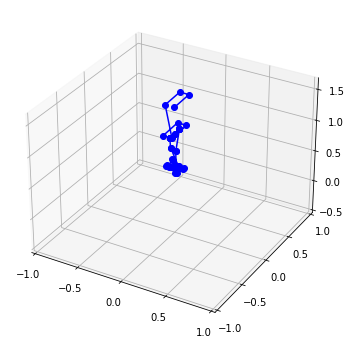

th 0.0004391330214324336
sin(th) 0.00043913300731885865
wedge [[ 0.         -0.33852027  0.93668876]
 [ 0.33852027  0.         -0.08954437]
 [-0.93668876  0.08954437  0.        ]]
th 0.000441258455469402
sin(th) 0.00044125844114990153
wedge [[ 0.         -0.33665228  0.93757062]
 [ 0.33665228  0.         -0.08733028]
 [-0.93757062  0.08733028  0.        ]]
th 0.00044338181501624255
sin(th) 0.00044338180048902713
wedge [[ 0.         -0.33484545  0.93842345]
 [ 0.33484545  0.         -0.08508797]
 [-0.93842345  0.08508797  0.        ]]
th 0.00044550219449261203
sin(th) 0.00044550217975597835
wedge [[ 0.         -0.33309842  0.93924794]
 [ 0.33309842  0.         -0.08281762]
 [-0.93924794  0.08281762  0.        ]]
th 0.0004476186534760255
sin(th) 0.0004476186385283633
wedge [[ 0.         -0.3314097   0.9400448 ]
 [ 0.3314097   0.         -0.08051949]
 [-0.9400448   0.08051949  0.        ]]
th 0.0004497302162721181
sin(th) 0.0004497302011119175
wedge [[ 0.         -0.32977767  0.94081475]


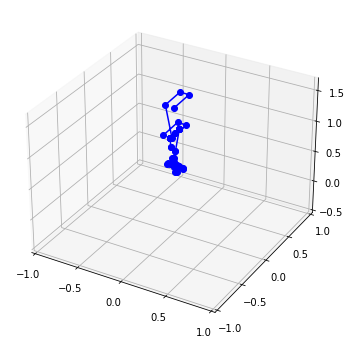

th 0.0004601780228418584
sin(th) 0.00046017800660034977
wedge [[ 0.         -0.32240105  0.94428745]
 [ 0.32240105  0.         -0.06617223]
 [-0.94428745  0.06617223  0.        ]]
th 0.0004622378232575624
sin(th) 0.0004622378067969805
wedge [[ 0.         -0.32106708  0.94491218]
 [ 0.32106708  0.         -0.06369382]
 [-0.94491218  0.06369382  0.        ]]
th 0.0004642849900949936
sin(th) 0.000464284973414739
wedge [[ 0.         -0.31977446  0.9455156 ]
 [ 0.31977446  0.         -0.06119266]
 [-0.9455156   0.06119266  0.        ]]
th 0.00046631832022469395
sin(th) 0.00046631830332432525
wedge [[ 0.         -0.31852045  0.94609861]
 [ 0.31852045  0.         -0.05866973]
 [-0.94609861  0.05866973  0.        ]]
th 0.00046833659980180975
sin(th) 0.0004683365826810497
wedge [[ 0.         -0.3173022   0.94666212]
 [ 0.3173022   0.         -0.05612607]
 [-0.94666212  0.05612607  0.        ]]
th 0.00047033861083176266
sin(th) 0.000470338593490503
wedge [[ 0.         -0.31611677  0.94720706]
 [

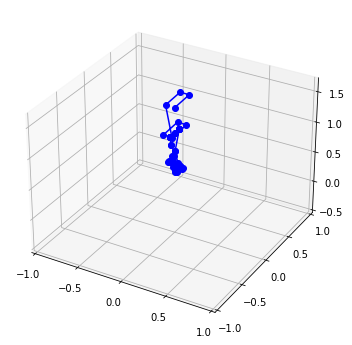

th 0.0004800626903364805
sin(th) 0.00048006267189725784
wedge [[ 0.         -0.31057323  0.94968646]
 [ 0.31057323  0.         -0.04049573]
 [-0.94968646  0.04049573  0.        ]]
th 0.00048194227553704133
sin(th) 0.0004819422568803848
wedge [[ 0.         -0.30951894  0.95014001]
 [ 0.30951894  0.         -0.03784148]
 [-0.95014001  0.03784148  0.        ]]
th 0.00048379763390126086
sin(th) 0.00048379761502830325
wedge [[ 0.         -0.30847535  0.95058169]
 [ 0.30847535  0.         -0.03517692]
 [-0.95058169  0.03517692  0.        ]]
th 0.00048562781855244716
sin(th) 0.0004856277994644916
wedge [[ 0.         -0.30743935  0.95101239]
 [ 0.30743935  0.         -0.0325035 ]
 [-0.95101239  0.0325035   0.        ]]
th 0.0004874319576125268
sin(th) 0.00048743193831104093
wedge [[ 0.         -0.30640791  0.95143302]
 [ 0.30640791  0.         -0.02982271]
 [-0.95143302  0.02982271  0.        ]]
th 0.0004892092624743385
sin(th) 0.0004892092429609469
wedge [[ 0.         -0.30537812  0.95184444]

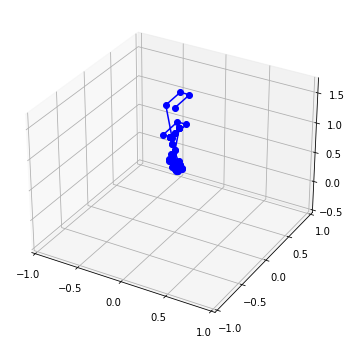

th 0.0004976723661280637
sin(th) 0.0004976723455843325
wedge [[ 0.         -0.30016264  0.95379014]
 [ 0.30016264  0.         -0.01366575]
 [-0.95379014  0.01366575  0.        ]]
th 0.0004992775880339575
sin(th) 0.0004992775672907955
wedge [[ 0.         -0.29909058  0.95416161]
 [ 0.29909058  0.         -0.0109744 ]
 [-0.95416161  0.0109744   0.        ]]
th 0.0005008532866260754
sin(th) 0.0005008532656858994
wedge [[ 0.         -0.29800468  0.95452844]
 [ 0.29800468  0.         -0.00828718]
 [-0.95452844  0.00828718  0.        ]]
th 0.0005023995182353461
sin(th) 0.0005023994971006315
wedge [[ 0.         -0.29690359  0.95489101]
 [ 0.29690359  0.         -0.00560539]
 [-0.95489101  0.00560539  0.        ]]
th 0.0005039164486382572
sin(th) 0.0005039164273115234
wedge [[ 0.         -0.29578625  0.95524966]
 [ 0.29578625  0.         -0.00293029]
 [-0.95524966  0.00293029  0.        ]]
th 0.0005054043496763282
sin(th) 0.0005054043281601234
wedge [[ 0.00000000e+00 -2.94651808e-01  9.5560464

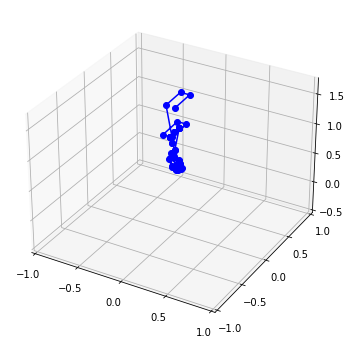

th 0.0005124247128534407
sin(th) 0.0005124246904281055
wedge [[ 0.         -0.28871094  0.95732918]
 [ 0.28871094  0.          0.01291663]
 [-0.95732918 -0.01291663  0.        ]]
th 0.0005137494116963814
sin(th) 0.0005137493890966771
wedge [[ 0.         -0.28746969  0.95766407]
 [ 0.28746969  0.          0.01551455]
 [-0.95766407 -0.01551455  0.        ]]
th 0.0005150494739115756
sin(th) 0.0005150494511398686
wedge [[ 0.         -0.2862119   0.95799542]
 [ 0.2862119   0.          0.01809784]
 [-0.95799542 -0.01809784  0.        ]]
th 0.0005163257957911106
sin(th) 0.000516325772849695
wedge [[ 0.         -0.28493838  0.95832304]
 [ 0.28493838  0.          0.0206658 ]
 [-0.95832304 -0.0206658   0.        ]]
th 0.000517579316992894
sin(th) 0.0005175792938839828
wedge [[ 0.         -0.28365011  0.95864673]
 [ 0.28365011  0.          0.0232178 ]
 [-0.95864673 -0.0232178   0.        ]]
th 0.0005188110126758337
sin(th) 0.0005188109894015511
wedge [[ 0.         -0.28234817  0.95896626]
 [ 0.28

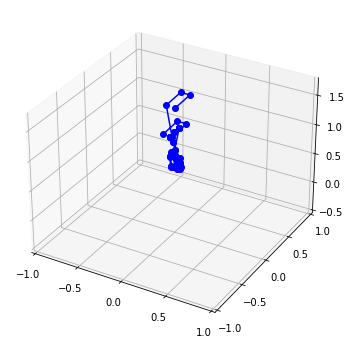

th 0.0005246778029881435
sin(th) 0.0005246777789153318
wedge [[ 0.         -0.27567653  0.96049244]
 [ 0.27567653  0.          0.03816698]
 [-0.96049244 -0.03816698  0.        ]]
th 0.0005258001095513402
sin(th) 0.0005258000853237199
wedge [[ 0.         -0.27431907  0.96078151]
 [ 0.27431907  0.          0.04059472]
 [-0.96078151 -0.04059472  0.        ]]
th 0.0005269078286687987
sin(th) 0.0005269078042877323
wedge [[ 0.         -0.27295703  0.96106459]
 [ 0.27295703  0.          0.04300365]
 [-0.96106459 -0.04300365  0.        ]]
th 0.0005280019847734058
sin(th) 0.0005280019602401375
wedge [[ 0.         -0.27159171  0.96134144]
 [ 0.27159171  0.          0.04539365]
 [-0.96134144 -0.04539365  0.        ]]
th 0.0005290835868609192
sin(th) 0.000529083562176574
wedge [[ 0.         -0.27022437  0.96161184]
 [ 0.27022437  0.          0.04776467]
 [-0.96161184 -0.04776467  0.        ]]
th 0.0005301536254891086
sin(th) 0.0005301536006546927
wedge [[ 0.         -0.26885621  0.96187559]
 [ 0.2

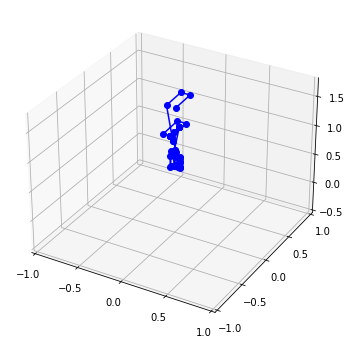

th 0.0005353634671988528
sin(th) 0.000535363441625072
wedge [[ 0.         -0.26203993  0.96308939]
 [ 0.26203993  0.          0.06159466]
 [-0.96308939 -0.06159466  0.        ]]
th 0.0005363836334386731
sin(th) 0.0005363836077184166
wedge [[ 0.         -0.26068772  0.96331045]
 [ 0.26068772  0.          0.06383486]
 [-0.96331045 -0.06383486  0.        ]]
th 0.0005373984967199775
sin(th) 0.0005373984708534526
wedge [[ 0.         -0.25934079  0.96352416]
 [ 0.25934079  0.          0.06605708]
 [-0.96352416 -0.06605708  0.        ]]
th 0.0005384088438548582
sin(th) 0.0005384088178421662
wedge [[ 0.         -0.25799965  0.96373053]
 [ 0.25799965  0.          0.06826159]
 [-0.96373053 -0.06826159  0.        ]]
th 0.0005394154340723935
sin(th) 0.0005394154079135313
wedge [[ 0.         -0.25666466  0.96392958]
 [ 0.25666466  0.          0.07044868]
 [-0.96392958 -0.07044868  0.        ]]
th 0.0005404189992967496
sin(th) 0.0005404189729916125
wedge [[ 0.         -0.25533614  0.96412136]
 [ 0.2

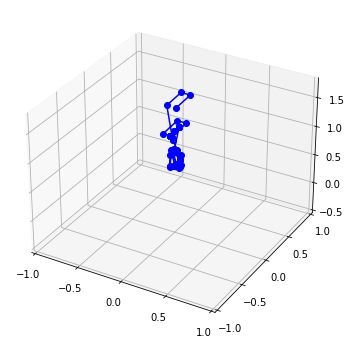

th 0.0005454152159234952
sin(th) 0.0005454151888820129
wedge [[ 0.         -0.24879429  0.96497425]
 [ 0.24879429  0.          0.08322313]
 [-0.96497425 -0.08322313  0.        ]]
th 0.0005464145351362959
sin(th) 0.0005464145079459036
wedge [[ 0.         -0.24750571  0.96512449]
 [ 0.24750571  0.          0.08529734]
 [-0.96512449 -0.08529734  0.        ]]
th 0.0005474152327862641
sin(th) 0.0005474152054462095
wedge [[ 0.         -0.24622326  0.9652683 ]
 [ 0.24622326  0.          0.0873568 ]
 [-0.9652683  -0.0873568   0.        ]]
th 0.0005484178429771222
sin(th) 0.0005484178154865695
wedge [[ 0.         -0.24494664  0.96540585]
 [ 0.24494664  0.          0.08940185]
 [-0.96540585 -0.08940185  0.        ]]
th 0.0005494228781590592
sin(th) 0.000549422850517091
wedge [[ 0.         -0.24367548  0.96553731]
 [ 0.24367548  0.          0.09143281]
 [-0.96553731 -0.09143281  0.        ]]
th 0.0005504308297960545
sin(th) 0.0005504308020016742
wedge [[ 0.         -0.24240938  0.96566288]
 [ 0.2

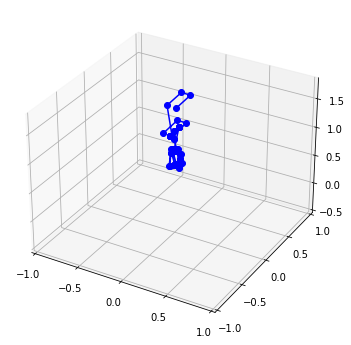

th 0.000555530145044579
sin(th) 0.00055553011647054
wedge [[ 0.         -0.23613898  0.9662087 ]
 [ 0.23613898  0.          0.10333988]
 [-0.9662087  -0.10333988  0.        ]]
th 0.000556564817613249
sin(th) 0.0005565647888792553
wedge [[ 0.         -0.23489359  0.96630276]
 [ 0.23489359  0.          0.10528043]
 [-0.96630276 -0.10528043  0.        ]]
th 0.0005576053090425324
sin(th) 0.0005576052801470837
wedge [[ 0.         -0.23364999  0.96639221]
 [ 0.23364999  0.          0.107209  ]
 [-0.96639221 -0.107209    0.        ]]
th 0.0005586519632807934
sin(th) 0.0005586519342223242
wedge [[ 0.         -0.23240773  0.96647722]
 [ 0.23240773  0.          0.10912577]
 [-0.96647722 -0.10912577  0.        ]]
th 0.000559705107924158
sin(th) 0.0005597050787010398
wedge [[ 0.         -0.23116636  0.96655794]
 [ 0.23116636  0.          0.11103089]
 [-0.96655794 -0.11103089  0.        ]]
th 0.000560765054596198
sin(th) 0.0005607650252067406
wedge [[ 0.         -0.22992548  0.96663454]
 [ 0.229925

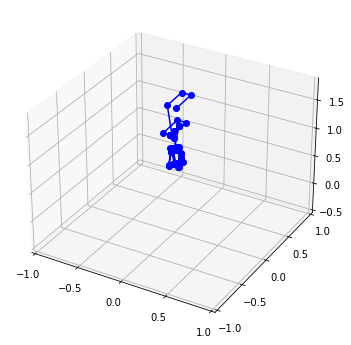

th 0.0005661766519115487
sin(th) 0.0005661766216629952
wedge [[ 0.         -0.22371654  0.96696062]
 [ 0.22371654  0.          0.12222137]
 [-0.96696062 -0.12222137  0.        ]]
th 0.0005672831047851778
sin(th) 0.0005672830743589375
wedge [[ 0.         -0.22247198  0.96701533]
 [ 0.22247198  0.          0.12404664]
 [-0.96701533 -0.12404664  0.        ]]
th 0.0005683981231099091
sin(th) 0.0005683980925039039
wedge [[ 0.         -0.22122606  0.9670668 ]
 [ 0.22122606  0.          0.12586042]
 [-0.9670668  -0.12586042  0.        ]]
th 0.0005695219031285639
sin(th) 0.0005695218723406661
wedge [[ 0.         -0.21997868  0.96711511]
 [ 0.21997868  0.          0.12766264]
 [-0.96711511 -0.12766264  0.        ]]
th 0.0005706546281822388
sin(th) 0.0005706545972102729
wedge [[ 0.         -0.2187298   0.96716036]
 [ 0.2187298   0.          0.12945316]
 [-0.96716036 -0.12945316  0.        ]]
th 0.0005717964690646331
sin(th) 0.0005717964379063765
wedge [[ 0.         -0.2174794   0.96720262]
 [ 0.

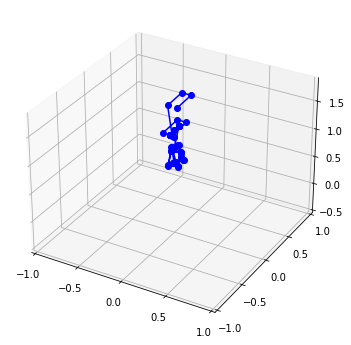

th 0.0005776475570887869
sin(th) 0.000577647524964199
wedge [[ 0.         -0.21120718  0.96737167]
 [ 0.21120718  0.          0.13994132]
 [-0.96737167 -0.13994132  0.        ]]
th 0.0005788470241196818
sin(th) 0.0005788469917945609
wedge [[ 0.         -0.20994974  0.96739746]
 [ 0.20994974  0.          0.14164487]
 [-0.96739746 -0.14164487  0.        ]]
th 0.0005800564830918698
sin(th) 0.0005800564505637023
wedge [[ 0.         -0.20869181  0.96742069]
 [ 0.20869181  0.          0.14333505]
 [-0.96742069 -0.14333505  0.        ]]
th 0.0005812760183948642
sin(th) 0.0005812759856610993
wedge [[ 0.         -0.20743368  0.96744143]
 [ 0.20743368  0.          0.14501158]
 [-0.96744143 -0.14501158  0.        ]]
th 0.0005825057055120733
sin(th) 0.0005825056725701241
wedge [[ 0.         -0.20617565  0.96745971]
 [ 0.20617565  0.          0.14667417]
 [-0.96745971 -0.14667417  0.        ]]
th 0.0005837456114676965
sin(th) 0.0005837455783149412
wedge [[ 0.         -0.20491805  0.96747559]
 [ 0.2

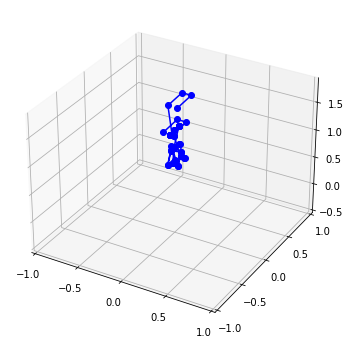

th 0.0005901002345741105
sin(th) 0.000590100200326829
wedge [[ 0.         -0.19864944  0.96752066]
 [ 0.19864944  0.          0.15633994]
 [-0.96752066 -0.15633994  0.        ]]
th 0.000591402444447939
sin(th) 0.0005914024099734302
wedge [[ 0.         -0.19740237  0.96752315]
 [ 0.19740237  0.          0.15789635]
 [-0.96752315 -0.15789635  0.        ]]
th 0.0005927151435459638
sin(th) 0.0005927151088413823
wedge [[ 0.         -0.1961585   0.96752359]
 [ 0.1961585   0.          0.15943634]
 [-0.96752359 -0.15943634  0.        ]]
th 0.0005940383475094075
sin(th) 0.0005940383125718785
wedge [[ 0.         -0.19491824  0.96752204]
 [ 0.19491824  0.          0.1609596 ]
 [-0.96752204 -0.1609596   0.        ]]
th 0.0005953720675541548
sin(th) 0.0005953720323807744
wedge [[ 0.         -0.19368202  0.96751855]
 [ 0.19368202  0.          0.16246581]
 [-0.96751855 -0.16246581  0.        ]]
th 0.0005967163108924864
sin(th) 0.0005967162754803222
wedge [[ 0.         -0.19245028  0.96751318]
 [ 0.19

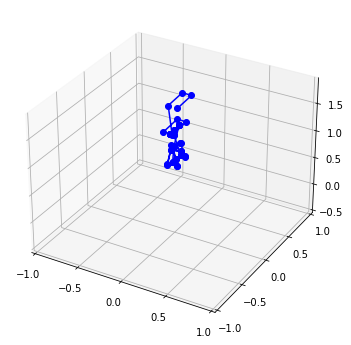

th 0.0006035954000383575
sin(th) 0.0006035953633873003
wedge [[ 0.         -0.18637337  0.96746054]
 [ 0.18637337  0.          0.17112879]
 [-0.96746054 -0.17112879  0.        ]]
th 0.0006050027607517229
sin(th) 0.0006050027238436974
wedge [[ 0.         -0.1851772   0.96744535]
 [ 0.1851772   0.          0.17250767]
 [-0.96744535 -0.17250767  0.        ]]
th 0.0006064206161832706
sin(th) 0.000606420579015149
wedge [[ 0.         -0.18398834  0.96742878]
 [ 0.18398834  0.          0.17386732]
 [-0.96742878 -0.17386732  0.        ]]
th 0.000607848955281239
sin(th) 0.0006078489178498654
wedge [[ 0.         -0.18280717  0.96741091]
 [ 0.18280717  0.          0.1752075 ]
 [-0.96741091 -0.1752075   0.        ]]
th 0.0006092877662244201
sin(th) 0.0006092877285266106
wedge [[ 0.         -0.18163404  0.96739182]
 [ 0.18163404  0.          0.176528  ]
 [-0.96739182 -0.176528    0.        ]]
th 0.0006107370367084342
sin(th) 0.0006107369987409768
wedge [[ 0.         -0.18046929  0.96737161]
 [ 0.18

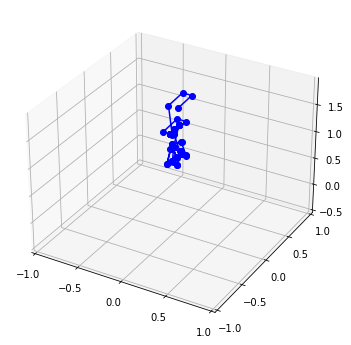

th 0.0006181398505968667
sin(th) 0.0006181398112319833
wedge [[ 0.         -0.17478233  0.96725656]
 [ 0.17478233  0.          0.18402687]
 [-0.96725656 -0.18402687  0.        ]]
th 0.0006196516250676501
sin(th) 0.0006196515854132376
wedge [[ 0.         -0.1736743   0.96723138]
 [ 0.1736743   0.          0.18520446]
 [-0.96723138 -0.18520446  0.        ]]
th 0.000621173780246543
sin(th) 0.0006211737402991825
wedge [[ 0.         -0.17257666  0.96720569]
 [ 0.17257666  0.          0.18636106]
 [-0.96720569 -0.18636106  0.        ]]
th 0.0006227063084430355
sin(th) 0.0006227062681992767
wedge [[ 0.         -0.17148964  0.96717958]
 [ 0.17148964  0.          0.18749655]
 [-0.96717958 -0.18749655  0.        ]]
th 0.0006242492033856671
sin(th) 0.0006242491628420276
wedge [[ 0.         -0.17041344  0.96715315]
 [ 0.17041344  0.          0.18861085]
 [-0.96715315 -0.18861085  0.        ]]
th 0.0006258024603645462
sin(th) 0.0006258024195175111
wedge [[ 0.         -0.16934826  0.96712647]
 [ 0.1

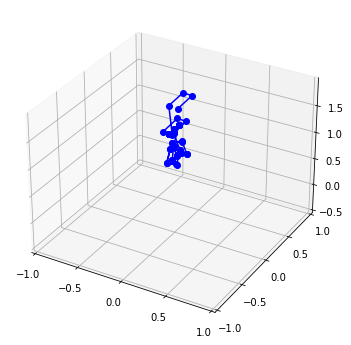

th 0.0006337241357751909
sin(th) 0.0006337240933572596
wedge [[ 0.         -0.16419358  0.96699269]
 [ 0.16419358  0.          0.19484764]
 [-0.96699269 -0.19484764  0.        ]]
th 0.0006353395685698359
sin(th) 0.000635339525826693
wedge [[ 0.         -0.16319784  0.96696648]
 [ 0.16319784  0.          0.19581189]
 [-0.96696648 -0.19581189  0.        ]]
th 0.0006369653837568667
sin(th) 0.0006369653406847482
wedge [[ 0.         -0.1622141   0.96694064]
 [ 0.1622141   0.          0.1967546 ]
 [-0.96694064 -0.1967546   0.        ]]
th 0.0006386015929350149
sin(th) 0.0006386015495301176
wedge [[ 0.         -0.16124244  0.96691528]
 [ 0.16124244  0.          0.1976758 ]
 [-0.96691528 -0.1976758   0.        ]]
th 0.0006402482100793867
sin(th) 0.0006402481663378678
wedge [[ 0.         -0.16028291  0.96689046]
 [ 0.16028291  0.          0.19857549]
 [-0.96689046 -0.19857549  0.        ]]
th 0.0006419052515912361
sin(th) 0.0006419052075092121
wedge [[ 0.         -0.15933559  0.96686627]
 [ 0.1

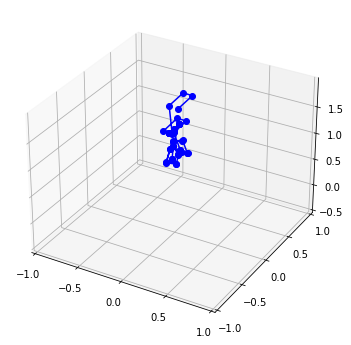

th 0.0006503475736399409
sin(th) 0.0006503475277956443
wedge [[ 0.         -0.1547831   0.96675749]
 [ 0.1547831   0.          0.20352431]
 [-0.96675749 -0.20352431  0.        ]]
th 0.000652067646553879
sin(th) 0.0006520676003448654
wedge [[ 0.         -0.15390948  0.96673868]
 [ 0.15390948  0.          0.2042748 ]
 [-0.96673868 -0.2042748   0.        ]]
th 0.0006537983296630096
sin(th) 0.0006537982830850821
wedge [[ 0.         -0.15304812  0.96672101]
 [ 0.15304812  0.          0.20500428]
 [-0.96672101 -0.20500428  0.        ]]
th 0.000655539659980941
sin(th) 0.0006555396130298537
wedge [[ 0.         -0.15219898  0.96670455]
 [ 0.15219898  0.          0.20571284]
 [-0.96670455 -0.20571284  0.        ]]
th 0.0006572916771970521
sin(th) 0.0006572916298685085
wedge [[ 0.         -0.15136201  0.96668937]
 [ 0.15136201  0.          0.2064006 ]
 [-0.96668937 -0.2064006   0.        ]]
th 0.0006590544236917481
sin(th) 0.0006590543759814007
wedge [[ 0.         -0.15053715  0.96667551]
 [ 0.15

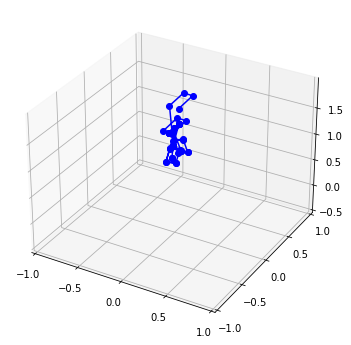

th 0.000668030768842487
sin(th) 0.0006680307191560175
wedge [[ 0.         -0.1465917   0.96662821]
 [ 0.1465917   0.          0.21009706]
 [-0.96662821 -0.21009706  0.        ]]
th 0.0006698589335094259
sin(th) 0.000669858883413916
wedge [[ 0.         -0.14583767  0.96662351]
 [ 0.14583767  0.          0.21064274]
 [-0.96662351 -0.21064274  0.        ]]
th 0.0006716982006864497
sin(th) 0.0006716981501771562
wedge [[ 0.         -0.14509505  0.9666205 ]
 [ 0.14509505  0.          0.21116872]
 [-0.9666205  -0.21116872  0.        ]]
th 0.0006735486348195955
sin(th) 0.0006735485838917128
wedge [[ 0.         -0.14436368  0.96661924]
 [ 0.14436368  0.          0.21167515]
 [-0.96661924 -0.21167515  0.        ]]
th 0.00067541030319272
sin(th) 0.0006754102518413797
wedge [[ 0.         -0.14364343  0.96661976]
 [ 0.14364343  0.          0.21216222]
 [-0.96661976 -0.21216222  0.        ]]
th 0.0006772832759505469
sin(th) 0.0006772832241708153
wedge [[ 0.         -0.14293411  0.9666221 ]
 [ 0.1429

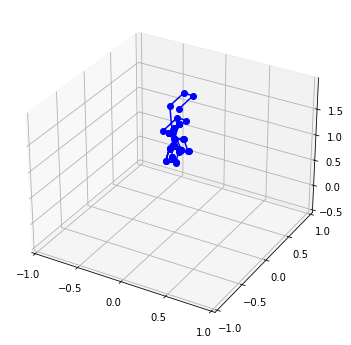

th 0.000686820364210968
sin(th) 0.000686820310212899
wedge [[ 0.         -0.13954531  0.96666239]
 [ 0.13954531  0.          0.214688  ]
 [-0.96666239 -0.214688    0.        ]]
th 0.00068876280000101
sin(th) 0.000688762745543499
wedge [[ 0.         -0.13889766  0.96667638]
 [ 0.13889766  0.          0.21504467]
 [-0.96667638 -0.21504467  0.        ]]
th 0.0006907171137130058
sin(th) 0.0006907170587906207
wedge [[ 0.         -0.13825953  0.96669242]
 [ 0.13825953  0.          0.21538352]
 [-0.96669242 -0.21538352  0.        ]]
th 0.0006926833994891635
sin(th) 0.0006926833440963941
wedge [[ 0.         -0.13763066  0.96671054]
 [ 0.13763066  0.          0.21570475]
 [-0.96671054 -0.21570475  0.        ]]
th 0.0006946617546465199
sin(th) 0.0006946616987777762
wedge [[ 0.         -0.13701079  0.96673075]
 [ 0.13701079  0.          0.21600858]
 [-0.96673075 -0.21600858  0.        ]]
th 0.0006966522797232266
sin(th) 0.0006966522233728366
wedge [[ 0.         -0.13639966  0.96675307]
 [ 0.13639

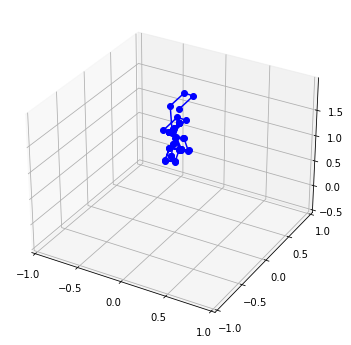

th 0.0007067912043343725
sin(th) 0.0007067911454876678
wedge [[ 0.         -0.13346464  0.96689711]
 [ 0.13346464  0.          0.21747913]
 [-0.96689711 -0.21747913  0.        ]]
th 0.0007088570467673929
sin(th) 0.000708856987403179
wedge [[ 0.         -0.13289955  0.96693251]
 [ 0.13289955  0.          0.2176677 ]
 [-0.96693251 -0.2176677   0.        ]]
th 0.0007109358572030392
sin(th) 0.0007109357973150136
wedge [[ 0.         -0.13234095  0.96697015]
 [ 0.13234095  0.          0.21784078]
 [-0.96697015 -0.21784078  0.        ]]
th 0.0007130277637180023
sin(th) 0.0007130277032997637
wedge [[ 0.         -0.13178848  0.96701003]
 [ 0.13178848  0.          0.21799862]
 [-0.96701003 -0.21799862  0.        ]]
th 0.0007151328980425528
sin(th) 0.0007151328370875985
wedge [[ 0.         -0.13124177  0.96705216]
 [ 0.13124177  0.          0.2181415 ]
 [-0.96705216 -0.2181415   0.        ]]
th 0.0007172513955983261
sin(th) 0.0007172513341000497
wedge [[ 0.         -0.13070042  0.96709656]
 [ 0.1

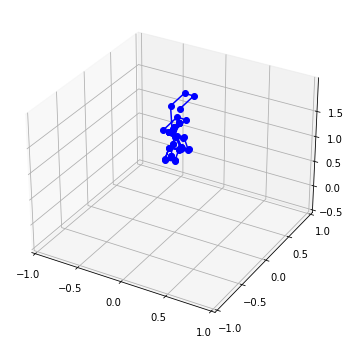

th 0.0007280493334733137
sin(th) 0.0007280492691555162
wedge [[ 0.         -0.12805947  0.96735273]
 [ 0.12805947  0.          0.21869951]
 [-0.96735273 -0.21869951  0.        ]]
th 0.0007302510641192983
sin(th) 0.0007302509992162143
wedge [[ 0.         -0.12754135  0.96741083]
 [ 0.12754135  0.          0.21874526]
 [-0.96741083 -0.21874526  0.        ]]
th 0.0007324672110197959
sin(th) 0.0007324671455240183
wedge [[ 0.         -0.12702551  0.96747123]
 [ 0.12702551  0.          0.21877828]
 [-0.96747123 -0.21877828  0.        ]]
th 0.0007346979395615671
sin(th) 0.0007346978734655631
wedge [[ 0.         -0.12651146  0.96753393]
 [ 0.12651146  0.          0.21879888]
 [-0.96753393 -0.21879888  0.        ]]
th 0.0007369434187554664
sin(th) 0.0007369433520515747
wedge [[ 0.         -0.12599871  0.96759892]
 [ 0.12599871  0.          0.21880735]
 [-0.96759892 -0.21880735  0.        ]]
th 0.0007392038211553134
sin(th) 0.0007392037538357411
wedge [[ 0.         -0.12548675  0.9676662 ]
 [ 0.

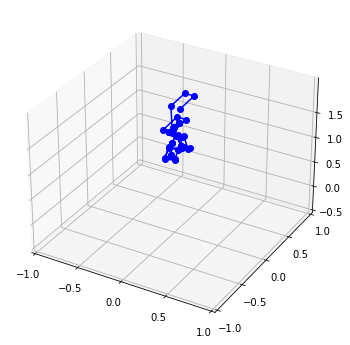

th 0.0007507359537537497
sin(th) 0.0007507358832340615
wedge [[ 0.         -0.12292072  0.96803684]
 [ 0.12292072  0.          0.21862106]
 [-0.96803684 -0.21862106  0.        ]]
th 0.0007530897014944458
sin(th) 0.0007530896303093845
wedge [[ 0.         -0.12240258  0.96811776]
 [ 0.12240258  0.          0.21855347]
 [-0.96811776 -0.21855347  0.        ]]
th 0.000755459667812999
sin(th) 0.0007554595959537644
wedge [[ 0.         -0.12188155  0.9682009 ]
 [ 0.12188155  0.          0.21847632]
 [-0.9682009  -0.21847632  0.        ]]
th 0.0007578460477771256
sin(th) 0.0007578459752347612
wedge [[ 0.         -0.1213571   0.96828626]
 [ 0.1213571   0.          0.21838994]
 [-0.96828626 -0.21838994  0.        ]]
th 0.0007602490381092233
sin(th) 0.000760248964874613
wedge [[ 0.         -0.12082869  0.96837383]
 [ 0.12082869  0.          0.21829465]
 [-0.96837383 -0.21829465  0.        ]]
th 0.0007626688368212148
sin(th) 0.0007626687628850805
wedge [[ 0.         -0.12029582  0.96846357]
 [ 0.12

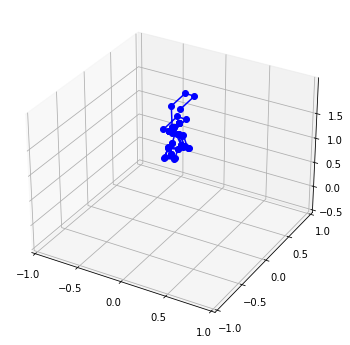

th 0.000775026923593891
sin(th) 0.0007750268460050783
wedge [[ 0.         -0.11754671  0.96894409]
 [ 0.11754671  0.          0.21755489]
 [-0.96894409 -0.21755489  0.        ]]
th 0.0007775517484816746
sin(th) 0.0007775516701320999
wedge [[ 0.         -0.11697661  0.96904633]
 [ 0.11697661  0.          0.21740672]
 [-0.96904633 -0.21740672  0.        ]]
th 0.0007800947661910874
sin(th) 0.0007800946870702585
wedge [[ 0.         -0.11639872  0.96915054]
 [ 0.11639872  0.          0.21725234]
 [-0.96915054 -0.21725234  0.        ]]
th 0.0007826561679285642
sin(th) 0.0007826560880258058
wedge [[ 0.         -0.11581266  0.96925666]
 [ 0.11581266  0.          0.21709206]
 [-0.96925666 -0.21709206  0.        ]]
th 0.0007852361414716134
sin(th) 0.0007852360607760651
wedge [[ 0.         -0.11521806  0.96936465]
 [ 0.11521806  0.          0.21692621]
 [-0.96936465 -0.21692621  0.        ]]
th 0.0007878348705236704
sin(th) 0.0007878347890242849
wedge [[ 0.         -0.11461458  0.96947445]
 [ 0.1

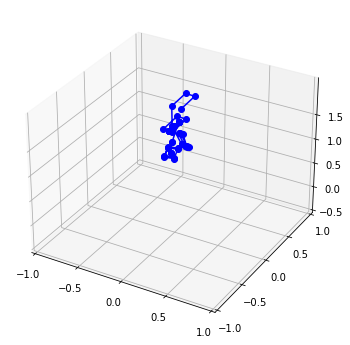

th 0.000801115910044778
sin(th) 0.0008011158243538578
wedge [[ 0.         -0.11145481  0.97004874]
 [ 0.11145481  0.          0.21583156]
 [-0.97004874 -0.21583156  0.        ]]
th 0.0008038307190541932
sin(th) 0.0008038306324891535
wedge [[ 0.         -0.11079308  0.9701682 ]
 [ 0.11079308  0.          0.21563526]
 [-0.9701682  -0.21563526  0.        ]]
th 0.0008065654005062043
sin(th) 0.0008065653130546567
wedge [[ 0.         -0.11012119  0.97028901]
 [ 0.11012119  0.          0.21543573]
 [-0.97028901 -0.21543573  0.        ]]
th 0.0008093200822869251
sin(th) 0.0008093199939362878
wedge [[ 0.         -0.10943912  0.97041112]
 [ 0.10943912  0.          0.21523323]
 [-0.97041112 -0.21523323  0.        ]]
th 0.0008120948826699556
sin(th) 0.0008120947934074534
wedge [[ 0.         -0.10874693  0.97053442]
 [ 0.10874693  0.          0.215028  ]
 [-0.97053442 -0.215028    0.        ]]
th 0.0008148899098536233
sin(th) 0.0008148898196662878
wedge [[ 0.         -0.10804469  0.97065885]
 [ 0.1

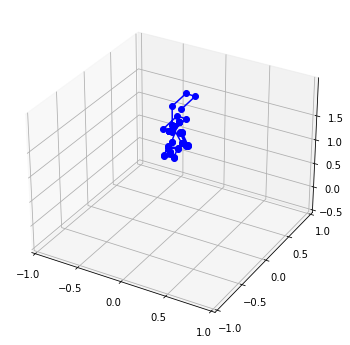

th 0.0008291714834749168
sin(th) 0.0008291713884621845
wedge [[ 0.         -0.10438925  0.97129471]
 [ 0.10438925  0.          0.21375094]
 [-0.97129471 -0.21375094  0.        ]]
th 0.0008320895362485798
sin(th) 0.0008320894402291955
wedge [[ 0.         -0.10363126  0.97142399]
 [ 0.10363126  0.          0.21353218]
 [-0.97142399 -0.21353218  0.        ]]
th 0.0008350282652344236
sin(th) 0.0008350281681940939
wedge [[ 0.         -0.10286516  0.97155375]
 [ 0.10286516  0.          0.21331214]
 [-0.97155375 -0.21331214  0.        ]]
th 0.0008379876890963307
sin(th) 0.000837987591020578
wedge [[ 0.         -0.10209142  0.9716839 ]
 [ 0.10209142  0.          0.21309092]
 [-0.9716839  -0.21309092  0.        ]]
th 0.0008409678153125385
sin(th) 0.0008409677161867032
wedge [[ 0.         -0.10131052  0.97181434]
 [ 0.10131052  0.          0.21286865]
 [-0.97181434 -0.21286865  0.        ]]
th 0.0008439686404408492
sin(th) 0.0008439685402500909
wedge [[ 0.         -0.100523    0.97194499]
 [ 0.1

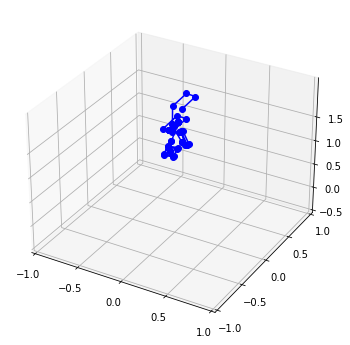

th 0.0008592824139184794
sin(th) 0.0008592823081742919
wedge [[ 0.         -0.09650667  0.9725981 ]
 [ 0.09650667  0.          0.21151689]
 [-0.9725981  -0.21151689  0.        ]]
th 0.0008624068005982393
sin(th) 0.0008624066936963819
wedge [[ 0.         -0.09569214  0.9727281 ]
 [ 0.09569214  0.          0.21128902]
 [-0.9727281  -0.21128902  0.        ]]
th 0.0008655515936556875
sin(th) 0.0008655514855800977
wedge [[ 0.         -0.09487543  0.97285771]
 [ 0.09487543  0.          0.21106048]
 [-0.97285771 -0.21106048  0.        ]]
th 0.0008687167201032737
sin(th) 0.0008687166108377191
wedge [[ 0.         -0.09405724  0.97298685]
 [ 0.09405724  0.          0.21083126]
 [-0.97298685 -0.21083126  0.        ]]
th 0.0008719021012917494
sin(th) 0.0008719019908198284
wedge [[ 0.         -0.09323827  0.97311546]
 [ 0.09323827  0.          0.21060135]
 [-0.97311546 -0.21060135  0.        ]]
th 0.0008751076536994755
sin(th) 0.0008751075420046177
wedge [[ 0.         -0.09241923  0.97324346]
 [ 0.

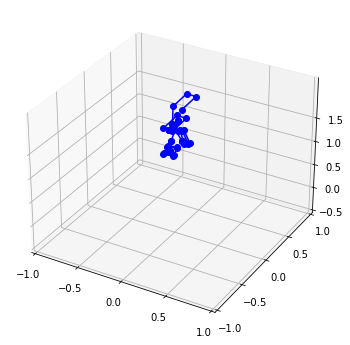

th 0.0008914348212418367
sin(th) 0.0008914347031778305
wedge [[ 0.         -0.08834734  0.97387246]
 [ 0.08834734  0.          0.20920609]
 [-0.97387246 -0.20920609  0.        ]]
th 0.0008947594756412657
sin(th) 0.0008947593562513485
wedge [[ 0.         -0.08754235  0.97399571]
 [ 0.08754235  0.          0.20897055]
 [-0.97399571 -0.20897055  0.        ]]
th 0.0008981036476395602
sin(th) 0.0008981035269059706
wedge [[ 0.         -0.086742    0.97411803]
 [ 0.086742    0.          0.20873402]
 [-0.97411803 -0.20873402  0.        ]]
th 0.0009014672433687739
sin(th) 0.000901467121273576
wedge [[ 0.         -0.08594689  0.97423938]
 [ 0.08594689  0.          0.20849645]
 [-0.97423938 -0.20849645  0.        ]]
th 0.0009048501710135131
sin(th) 0.0009048500475385941
wedge [[ 0.         -0.08515761  0.97435973]
 [ 0.08515761  0.          0.20825777]
 [-0.97435973 -0.20825777  0.        ]]
th 0.0009082523414565107
sin(th) 0.0009082522165835783
wedge [[ 0.         -0.08437472  0.97447906]
 [ 0.0

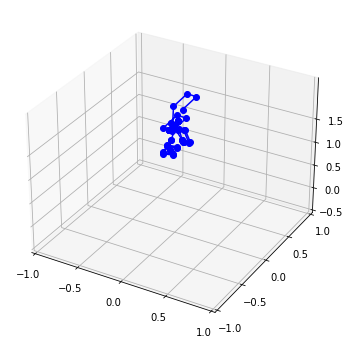

th 0.0009255489783219759
sin(th) 0.0009255488461781282
wedge [[ 0.         -0.0805738   0.97505996]
 [ 0.0805738   0.          0.20679926]
 [-0.97505996 -0.20679926  0.        ]]
th 0.0009290649563161179
sin(th) 0.000929064822660577
wedge [[ 0.         -0.07983947  0.97517294]
 [ 0.07983947  0.          0.20655119]
 [-0.97517294 -0.20655119  0.        ]]
th 0.0009325996744576772
sin(th) 0.0009325995392708083
wedge [[ 0.         -0.07911466  0.97528485]
 [ 0.07911466  0.          0.20630155]
 [-0.97528485 -0.20630155  0.        ]]
th 0.0009361530834763065
sin(th) 0.0009361529467382676
wedge [[ 0.         -0.07839972  0.9753957 ]
 [ 0.07839972  0.          0.20605027]
 [-0.9753957  -0.20605027  0.        ]]
th 0.0009397251407209877
sin(th) 0.0009397250024117244
wedge [[ 0.         -0.07769493  0.97550549]
 [ 0.07769493  0.          0.2057973 ]
 [-0.97550549 -0.2057973   0.        ]]
th 0.0009433158103860158
sin(th) 0.0009433156704852567
wedge [[ 0.         -0.07700058  0.97561425]
 [ 0.0

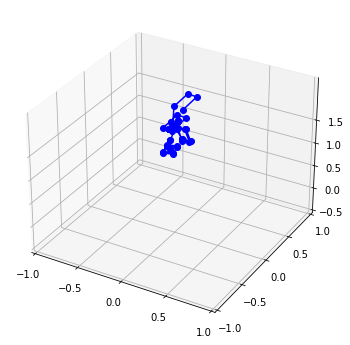

th 0.0009615475917814329
sin(th) 0.0009615474436111592
wedge [[ 0.         -0.07369279  0.97614291]
 [ 0.07369279  0.          0.20424102]
 [-0.97614291 -0.20424102  0.        ]]
th 0.0009652495867795994
sin(th) 0.0009652494368913448
wedge [[ 0.         -0.07306515  0.97624575]
 [ 0.07306515  0.          0.20397479]
 [-0.97624575 -0.20397479  0.        ]]
th 0.0009689701468043145
sin(th) 0.0009689699951761352
wedge [[ 0.         -0.07244905  0.97634769]
 [ 0.07244905  0.          0.20370648]
 [-0.97634769 -0.20370648  0.        ]]
th 0.0009727092948573438
sin(th) 0.0009727091414670333
wedge [[ 0.         -0.07184457  0.97644873]
 [ 0.07184457  0.          0.20343607]
 [-0.97644873 -0.20343607  0.        ]]
th 0.0009764670613754087
sin(th) 0.0009764669062004912
wedge [[ 0.         -0.07125174  0.97654891]
 [ 0.07125174  0.          0.2031635 ]
 [-0.97654891 -0.2031635   0.        ]]
th 0.000980243484175542
sin(th) 0.0009802433271932662
wedge [[ 0.         -0.07067057  0.97664826]
 [ 0.0

In [234]:
# biped robot simulation
#  単位ベクトル法による動力学シミュレーション
#  床面との接触反力は足の長方形板の頂点のめり込みを簡易的に計算しているだけ．
#　剛体の接触力計算については．．．いい方法があれば教えて下さい．

G = 9.8;  # 重力加速度

arr = [0]*14;
SetupRobot(arr);# ロボットの初期設定

# 胴体の空間速度・加速度の初期化
BODY=1;
arr[BODY].vo = np.array([0., 0., 0.]);
arr[BODY].w  = np.array([0., 0., 0.]);
arr[BODY].dvo = np.array([0., 0., 0.]);
arr[BODY].dw  = np.array([0., 0., 0.]);

# 関節トルク
u_joint = np.zeros(len(arr)-1); # 全関節トルクを0に設定
#u_joint[RLEG_J2] = -10.0;   # 右股関節ピッチ軸にトルクを与える　[Nm]

# シミュレーション設定
Dtime = 0.001; # 1msでシミュレーションしないと簡易な接触力計算では発散してしまう．ルンゲクッタにすればましになるか？
EndTime = 0.7; # 0.7秒だけのトルクゼロの崩れるシミュレーション．
time = EndTime//Dtime+1; # 刻み数：最後の１は時刻ゼロも含めるため
com_m = np.zeros((int(time),3)); # 重心位置の初期化 プロットに使う？？


for k in range(int(time)):
    ForwardDynamics(u_joint); # 順運動学計算
    IntegrateEuler(1,Dtime); # 順運動学で求めたトルクから全関節のパラメータ更新
    com = calcCoM;  # 重心位置計算
    #com_m[k,:] = com;
    if k%10==0:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'}) #ここで図を用意

        print(k)
        DrawAllJoints(1); # ロボットの簡易描画
        
        ax.set_xticks(np.linspace(-1.0, 1.0, 5)) # X軸の表示範囲
        ax.set_yticks(np.linspace(-1.0, 1.0, 5)) # Y軸の表示範囲
        ax.set_zticks(np.linspace(-0.5, 1.5, 5)) # Z軸の表示範囲
        plt.show();

In [ ]:
# biped robot simulation  アニメーション保存バージョン
#  単位ベクトル法による動力学シミュレーション
#  床面との接触反力は足の長方形板の頂点のめり込みを簡易的に計算しているだけ．
#　剛体の接触力計算については．．．いい方法があれば教えて下さい．

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter

G = 9.8;  # 重力加速度

arr = [0]*14;
SetupRobot(arr);# ロボットの初期設定

# 胴体の空間速度・加速度の初期化
BODY=1;
arr[BODY].vo = np.array([0., 0., 0.]);
arr[BODY].w  = np.array([0., 0., 0.]);
arr[BODY].dvo = np.array([0., 0., 0.]);
arr[BODY].dw  = np.array([0., 0., 0.]);

# 関節トルク
u_joint = np.zeros(len(arr)-1); # 全関節トルクを0に設定
#u_joint[RLEG_J2] = -10.0;   # 右股関節ピッチ軸にトルクを与える　[Nm]

# シミュレーション設定
Dtime = 0.001; # 1msでシミュレーションしないと簡易な接触力計算では発散してしまう．ルンゲクッタにすればましになるか？
EndTime = 0.5; # 0.5秒だけのトルクゼロの崩れるシミュレーション．
time = EndTime//Dtime+1; # 刻み数：最後の１は時刻ゼロも含めるため
com_m = np.zeros((int(time),3)); # 重心位置の初期化 プロットに使う？？

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'}); #ここで図を用意

ims = []; # 空のイメージ保存用の配列用意
n = 0;
for k in range(int(time)):
    ForwardDynamics(u_joint); # 順運動学計算
    IntegrateEuler(1,Dtime); # 順運動学で求めたトルクから全関節のパラメータ更新
    com = calcCoM;  # 重心位置計算
    #com_m[k,:] = com;
    if k%10==0:
        print(k)
        #fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'}); #ここで図を用意
        DrawAllJoints(1); # ロボットの簡易描画
        ax.set_xticks(np.linspace(-1.0, 1.0, 5)) # X軸の表示範囲
        ax.set_yticks(np.linspace(-1.0, 1.0, 5)) # Y軸の表示範囲
        ax.set_zticks(np.linspace(-0.5, 1.5, 5)) # Z軸の表示範囲
        fig.savefig('./biped/'+str(n)+'.png'.format(0, 0)); # bipedディレクトリを作成しておくこと．bipedディレクトリに図を順番に保存
        ax.cla();
        n+=1;
        frames = n;
        #print(frames);
 
from PIL import Image, ImageFilter
for n in range(frames):
    exec('a'+str(n)+'=Image.open("./biped/'+str(n)+'.png");');
    ims.append(eval('a'+str(n)));

ims[0].save('./biped_robot_sim.gif'.format(0,0), save_all=True, append_images=ims[1:], duration=100, loop=0);

In [ ]:
def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))

In [ ]:
# 機構慣性の計算 2022/5/15
def AB():

    #const int n = subBody->numLinks();
    nDoF = len(arr)-1; #13次元

    #for(int i = n-1; i >= 0; --i){  for k in range(int(time)):
    for i in range(nDoF, 0, -1):
        #auto link = subBody->link(i); //n番目のリンクを初期化
        #link->pf()   -= link->f_ext(); // 外力を先に足しておく：もとはゼロのはず
        #link->ptau() -= link->tau_ext(); // 外力を先に足しておく
        # pf, ptauはバイアス項らしい？

        # compute articulated inertia (Eq.(6.48) of Kajita's textbook)
        #for(DyLink* child = link->child(); child; child = child->sibling()){ //子供と兄弟リンクを2回ループするだけ 

        for k in range(2): # //0: 子供, 1:兄弟リンクを2回ループするだけ #ここのループが怪しいか？ choreonoidだとsisterがゼロになるまでループしているっぽい。
            if k == 0:
                childsister = arr[i].child;
            elif k == 1:
                chidlsister = arr[i].sister;

            #if(child->isFreeJoint()){
            if childsister == 0:
                continue;
            elif hasattr(arr[childsister], 'isFixedJoint') and arr[childsister].isFixedJoint == 1: #isFixedJointメンバ変数を持っているかのチェック
                #if arr[childsister].isFixedJoint == 1:
                arr[i].Ivv += arr[childsister].Ivv;
                arr[i].Iwv += arr[childsister].Iwv;
                arr[i].Iww += arr[childsister].Iww;
            else:
                #### ここから6.48式の更新らしいが．．． ###
                #const Vector3 hhv_dd = child->hhv() / child->dd();
                #arr[i].hhv_dd = np.array([0, 0, 0]);#この初期化必要か？いらないならコメントアウト．
                hhv_dd = arr[childsister].hhv / arr[childsister].dd;#hhv/dd ただし，dd=s^T*I^A*s, hhv=I^A*s は 3x1の縦ベクトル
                hhw_dd = arr[childsister].hhw / arr[childsister].dd;#hhw/dd
                arr[i].Ivv += arr[childsister].Ivv - arr[childsister].hhv @ hhv_dd.T;#hhv*hhv_dd.tranで縦の3x1ベクトルと横の1x3ベクトルで３ｘ３の行列を生成．演算子は「@」
                arr[i].Iwv += arr[childsister].Iwv - arr[childsister].hhw @ hhv_dd.T;
                arr[i].Iww += arr[childsister].Iww - arr[childsister].hhw @ hhw_dd.T;
                #### ここまで6.48式の更新 ###
            
            # 式6.44の右辺第2項のバイアス項の計算？　P=I^s・\itaを計算しかしてない？運動量Pがpfで角運動量Lがptauのはず．
            arr[i].pf   += np.matmul(arr[childsister].Ivv, arr[childsister].cv) + np.matmul(arr[childsister].Iwv.T, arr[childsister].cw) + arr[childsister].pf;
            arr[i].ptau += np.matmul(arr[childsister].Iwv, arr[childsister].cv) + np.matmul(arr[childsister].Iww, arr[childsister].cw) + arr[childsister].ptau;


            if hasattr(arr[childsister], 'isFixedJoint') and arr[childsister].isFixedJoint == 1: #isFixedJointメンバ変数を持っているかのチェック
                uu_dd = arr[childsister].uu / arr[childsister].dd; #uu/dd
                arr[i].pf   += uu_dd * arr[childsister].hhv; #固定されているから理想の力がそのまま加わるということかな？
                arr[i].ptau += uu_dd * arr[childsister].hhw;



        #if(i > 0){
        if(i>1):
            #if(!link->isFixedJoint()){ #固定関節ではないとき
            if arr[i].isFixedJoint != 1: #固定関節ではないとき
                #// hh = Ia * s  6.48式の第3項で使うためなのか？
                #I^A・sの更新：hhv(I^A・sの上)とhhw(I^A・sの下)とddを更新
                arr[i].hhv = np.matmul(arr[i].Ivv, arr[i].hv) + np.matmul(arr[i].Iwv.T, arr[i].hw); # sv -> hv, sw -> hw
                arr[i].hhw = np.matmul(arr[i].Iwv, arr[i].hv) + np.matmul(arr[i].Iww, arr[i].hw);
                #// dd = Ia * s * s^T この式がわからんs^T * Ia * sならわかるが．6.48式の第3項の時には使うが？上のddはs^T*I^A*sと思っていたけど．．．
                arr[i].dd = arr[i].hv.dot(arr[i].hhv) + arr[i].hw.dot(arr[i].hhw);# + arr[i].Jm2; # ddとはなんだ？ Jm2とは？->/// Equivalent rotor inertia: n^2*Jm [kg.m^2] Link.hより nはギア比か？Jm2はスカラのはず sv -> hw, sw -> hw
                #print("arr[",i,"].dd",arr[i].dd) #ddはスカラになるはず。
                #print("Ivv ",arr[i].Ivv)
                #print("hhv ",arr[i].hhv)
                #print("Iwv ",arr[i].Iwv)
                #print("Iwv.T ",arr[i].Iwv.T)
                #print("Iww ",arr[i].Iww)
                #print("hhw ",arr[i].hhw)
                #// uu = u - hh^T*c + s^T*pp このuuってなんだ？この式もわからん．hh^T*cは6.49の第2項を展開したものでS^T*I^A*\dot{\ita}
                # clampは第2引数下限，第2引数上限を与えて，超えていたら上下限の値を返す関数．
                arr[i].uu = clamp(arr[i].u, arr[i].u_lower, arr[i].u_upper) - np.dot(arr[i].hhv, arr[i].cv) + np.dot(arr[i].hhw, arr[i].cw) + np.dot(arr[i].hv, arr[i].pf) + np.dot(arr[i].hw, arr[i].ptau); #ここはバイアス項：式6.49のb_2だが，式6.46のを見たほうが良い．
                    ## uuは式6.49の分子か？uのupperの意味？？ddで割れば式6.49の関節の角加速度が求まる！
    
    #return u


In [ ]:
# ForwardDynamics_ab
# Articurated Body Dynamicsを使った順動力学の計算
def ForwardDynamics_ab(joint):

    ForwardAllKinematics(1);
    [f,t] = InverseDynamics(1,Dtime);

    AB();

    # AB_phaze3
    # 加速度の計算
    #auto root = subBody->rootLink();
    #if(!root->isFreeJoint()){
    if arr[BODY].isFixedJoint == 1 : #固定関節
        arr[BODY].dvo =  [0., 0., 0.]; #root->dvo().setZero();
        arr[BODY].dw = [0., 0., 0.]; #root->dw().setZero();
    else:
        # - | Ivv  trans(Iwv) | * | dvo | = | pf   |
        #   | Iwv     Iww     |   | dw  |   | ptau |

        #Eigen::Matrix<double, 6, 6> M;
        #M << root->Ivv(), root->Iwv().transpose(),
        #    root->Iwv(), root->Iww();
        
        #Eigen::Matrix<double, 6, 1> f;
        #f << root->pf(),
        #    root->ptau();
        #f *= -1.0;

        #Eigen::Matrix<double, 6, 1> a(M.colPivHouseholderQr().solve(f));

        #root->dvo() = a.head<3>();
        #root->dw() = a.tail<3>();
        SE3dynamics(BODY,arr[BODY].pf, arr[BODY].ptau); #pfとptauの入力はどうする？
        #arr[BODY].dvo =  arr[BODY].dvo + np.array([0., 0., G]); #梶田さんのはこれでうまくいっているが、これやると吹っ飛ぶ。

    #const int n = subBody->numLinks();
    n = len(arr); # n = 13 
    for i in range(2,n): # (int i=1; i < n; ++i){ #2 から 13まで
        # auto link = subBody->link(i);
        # auto parent = link->parent();
        #if(link->isFixedJoint()){
        if arr[i].isFixedJoint == 1 : 
            arr[i].ddq = 0.0;
            arr[i].dvo = arr[arr[i].mother].dvo;
            arr[i].dw  = arr[arr[i].mother].dw; 
        else :
            #link->ddq() = (link->uu() - (link->hhv().dot(parent->dvo()) + link->hhw().dot(parent->dw()))) / link->dd();
            #link->dvo().noalias() = parent->dvo() + link->cv() + link->sv() * link->ddq();
            #link->dw().noalias()  = parent->dw()  + link->cw() + link->sw() * link->ddq();
            #print("arr[",i,"].dd=", arr[i].dd)
            arr[i].ddq = (arr[i].uu - np.dot(arr[i].hhv, arr[arr[i].mother].dvo) + np.dot(arr[i].hhw, arr[arr[i].mother].dw)) / arr[i].dd;
            arr[i].dvo = arr[arr[i].mother].dvo + arr[i].cv + arr[i].hv * arr[i].ddq; # sv -> hv 
            arr[i].dw  = arr[arr[i].mother].dw  + arr[i].cw + arr[i].hw * arr[i].ddq; # sw -> hw




In [ ]:
# biped robot simulation
#  Articulated Body Dynamicsを使ったシミュレーション
G = 9.8;  # 重力加速度

arr = [0]*14;
SetupRobot(arr);# ロボットの初期設定

# 胴体の空間速度・加速度の初期化
BODY=1;
arr[BODY].vo = np.array([0., 0., 0.]);
arr[BODY].w  = np.array([0., 0., 0.]);
arr[BODY].dvo = np.array([0., 0., 0.]);
arr[BODY].dw  = np.array([0., 0., 0.]);

# 関節トルク
#u_joint = np.zeros(len(arr)-1); # 全関節トルクを0に設定
#u_joint[RLEG_J2] = -10.0;   # 右股関節ピッチ軸にトルクを与える　[Nm]

# シミュレーション設定
Dtime = 0.001; # 1msでシミュレーションしないと簡易な接触力計算では発散してしまう．ルンゲクッタにすればましになるか？
EndTime = 0.7; # 0.7秒だけのトルクゼロの崩れるシミュレーション．
time = EndTime//Dtime+1; # 刻み数：最後の１は時刻ゼロも含めるため
com_m = np.zeros((int(time),3)); # 重心位置の初期化 プロットに使う？？

# 初期化
number = len(arr);
for i in range(0,number):
    arr[i].isFixedJoint = 0;
    arr[i].u_lower = -100;
    arr[i].u_upper = 100;

for k in range(int(time)):
    ForwardDynamics_ab(0); # 順運動学計算
    IntegrateEuler(1,Dtime); # 順運動学で求めたトルクから全関節のパラメータ更新
    com = calcCoM;  # 重心位置計算
    #com_m[k,:] = com;
    if k%10==0:
        fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection' : '3d'}) #ここで図を用意

        print(k)
        DrawAllJoints(1); # ロボットの簡易描画
        
        ax.set_xticks(np.linspace(-1.0, 1.0, 5)) # X軸の表示範囲
        ax.set_yticks(np.linspace(-1.0, 1.0, 5)) # Y軸の表示範囲
        ax.set_zticks(np.linspace(-0.5, 1.5, 5)) # Z軸の表示範囲
        plt.show();